<a href="https://colab.research.google.com/github/tblackfd/Thesis/blob/main/BrandtModelReplication_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background
This notebook intends to replicate the Lifecycle Assessment (LCA) of geologic hydrogen produced by Brandt (2023) in order to perform a review of its methods and assumptions, as well as the conclusions published in the associated paper.

It also builds on top of Brandt's work in three ways. First, it incorporates assessments of sensitivity to uncertainty regarding key assumptions. Second, it estimates costs of development, aligned with the scenarios assessed in the LCA portion. Finally, it estimates the value of the Production Tax Credits (PTC) that may be associated with each of the scenarios, under the United States' current PTC regime. 

# Import Python Packages

In [228]:
#Import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import statistics
import multiprocessing as mp
from itertools import repeat
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed


In [229]:
# Set seaborn whitegrid style
sns.set_style("whitegrid")

# Input Data Specific to Geologic H2

The following section establishes input data specific to the estimation of emissions from production of geologic hydrogen.

Key assumptions are:
* Well pressure calculated as depth (in ft) by a factor 0.42
* Initial Baseline raw gas rate is given (23,100 MSCFD) and declines at a manually-defined rate.
* Low pressure case is assumed to be 75% of baseline
* High pressure case is assumed to be 125% of baseline
* "High productivity" wellhead pressure is assumed to be 200% of baseline
* "Deep" and "Shallow" pressures are calculated based on assumed depths of 12,000 and 1,500 ft, respectively.

# Constants/Assumptions for Calculations

In [230]:
GWP_H2_default = 5 #Global Warming Potential of H2, relative to CO2, to enable CO2e calculations. From Brandt OPGEE file: "Low value from Derwent et al. 2020, of 5.0. High value of 10.9 from Warwick et al. 2022."
GWP_CH4 = 25 #Global Warming Potential of methane. 100-year basis, IPCC 2007 AR4, per Brand OPGEE file.

LHV_H2 = 113.958057395143 #mmbtu/tonne. Lower Heating Value of hydrogen. OPGEE source listed as Mechanical engineer's handbook - Energy & Power (3rd edition). John Wiley & Sons. Chapter 17: Gaseous Fuels, Table 2
LHV_CH4 = 47.5055187637969 #mmbtu/tonne. Lower Heating Value of methane. 

#LHV Energy Densities for gases:
data = {
    'Gas': ['N2', 'O2', 'CO2', 'H2O', 'CH4', 'C2H6', 'C3H8', 'C4H10', 'CO', 'H2', 'H2S', 'SO2'],
    'LHV (MJ/kg)': [
        0.0000000000,  # LHV for N2, Ar
        0.0000000000,  # LHV for O2
        0.0000000000,  # LHV for CO2
        0.0000000000,  # LHV for H2O
        50.1206975717,  # LHV for CH4
        47.5867143488,  # LHV for C2H6
        46.4501483444,  # LHV for C3H8
        45.8352847682,  # LHV for C4H10
        10.1242877483,  # LHV for CO
        120.2314484547,  # LHV for H2
        15.2434928256,  # LHV for H2S
        0.0000000000   # LHV for SO2
    ]
}
# Create the DataFrame
LHV_density_gases_metric = pd.DataFrame(data)
# Set 'Gas' as the index instead of a column
LHV_density_gases_metric.set_index('Gas', inplace=True)

steel_density = 0.30 #lb/in^3
mmbtu_to_MJ = 1055.05585 #conversion factor

#Factors related to drilling calculations:
heavy_duty_truck_diesel_intensity = 969 #btu LHV/ton mi (Paper does not cite source of this figure)
weight_land_survey = 25 #tonnes. Weight of land survey vehicle. Default assumption of OPGEE model.
distance_survey = 10000 #miles. Distance of travel for survey. Default assumption of OPGEE model. "Estimate accounting for long-distance travel of specialized equipment"
emissions_factor_trucks = 78908.518237706 #gCO2eq./mmbtu. OPGEE quoting GREET.
emissions_factor_diesel_exploration = 78823.3589186562 #g GHGs/mmbtu LHV. OPGEE quoting GREET, but using the values for "Barge diesel" rather than "Truck Diesel". It is unclear to me why this is the case.
emissions_factor_diesel_drilling = 78490.5078472298 #g GHGs/mmbtu LHV. OPGEE quoting GREET, but using the values for "Barge diesel" rather than "Truck Diesel". It is unclear to me why this is the case.  

#Pre-production Wells:
number_dry_wells = 1 #Number of dry wells drilled per discovered field.
number_exploration_wells = 3 #Number of exploratory/scientific wells drilled after discovery of the field.
diesel_energy_density = 128450 #LHV btu/gal. Source: GREET1_2016, obtained from "Fuel_Specs" worksheet.

#Production Wells:
number_production_wells_default = 50 #Key assumption
#Injection Wells:
number_injection_wells_default = math.ceil(0.25*number_production_wells_default) #Assumption is the number of injection wells is 25% of the number of production wells. Rounding up, as you can't drill a fraction of a well.
#Total Wells:
total_number_wells_default = number_production_wells_default + number_injection_wells_default 
# print(total_number_wells)

#Liquid unloading considerations:
wells_LUnp = 0.068996621 #Fraction of wells with non-plunger liquids unloadings. Default assumption in OPGEE model, "from US EPA (2020) Greenhouse Gas Inventory, based on RY2015"
wells_LUp = 0.1 #Fraction of wells with plunger liquids unloadings

PSA_unit_slippage_rate = 0.1 #Brandt assumes that the PSA unit only separates 90% of the H2 from the gas stream.

drilling_fuel_per_foot_vertical = 0.325964356060972 #gal diesel fuel/ft. This figure taken direct from OPGEE model and assumes Moderate complexity wells drilled at Medium efficiency.

steel_emissions_intensity = 2747.8545357015 / 2.204 #gCO2/lb. This is the emissions intensity of steel production, as calculated in the OPGEE model. Conversion factor of 2.204 is used to convert from kg to lb.

cement_emissions_intensity = 36587.7935725105 #gCO2/ft^3. This is the emissions intensity of cement production, as calculated in the OPGEE model.

# Key Variables / Inputs

In [231]:
### Gas Densities. Define a dataframe:

# Define the data as a dictionary
data = {
    'Gas': ['N2','CO2', 'CH4', 'H2'],
    'Density tonne/MMSCF': [33.480353, 52.605153, 19.1738073, 2.4097248]
}

# Create the DataFrame
gas_densities = pd.DataFrame(data)

# Set 'Gas' as the index instead of a column
gas_densities.set_index('Gas', inplace=True)

#Brandt's OPGEE model assumes all cases produce 0.1 bbl/day of oil. The significance of this assumption will be checked via sensitivity analysis.
oil_production_default = 0.1 #bbl/day
water_production_default = 1 #bbl/mmscf of gas

field_lifespan_default = 30 #years

small_source_emissions_percentage_default = 10 #%

# Define/Assume Reservoir Conditions for Analysis

In [232]:
# Data for the Reservoir Conditions DataFrame
reservoir_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'Raw Gas EUR, BCF': [67, 33, 167, 67, 67, 33, 67, 67, 67, 67, 33],
    'H2 EUR, BCF': [57, 28, 142, 57, 57, 28, 57, 57, 57, 57, 28],
    'Depth, ft': [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 12000, 1500],
    'Initial Reservoir Pressure, psi': [2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 2520, 5040, 630]
}

# Data for the Gas Composition DataFrame
gas_composition_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'H2': [85.0, 85.0, 85.0, 85.0, 85.0, 75.0, 75.0, 75.0, 95.0, 85.0, 85.0],
    'N2': [12.0, 12.0, 12.0, 1.5, 8.5, 20.0, 0.0, 22.5, 4.0, 12.0, 12.0],
    'CH4': [1.5, 1.5, 1.5, 12.0, 5.0, 2.5, 22.5, 0.0, 0.5, 1.5, 1.5],
    'C2+': [0.0] * 11,
    'CO2': [0.0] * 11,
    'Ar/oth inert': [1.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 0.5, 1.5, 1.5]
}

# Data for the Development Parameters DataFrame
development_params_data = {
    'Case': ['Baseline', 'Low Productivity', 'High Productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'],
    'Total Producing Wells': [50] * 11,
    'No. of Compressors': [2] * 11,
    'No. of Purification Plants': [1] * 11,
    'Water Cut (bbl/mmscf)': [1] * 11,
    'H2 purification loss rate': [10] * 11,
    'BCF per well': [1.3, 0.33, 2.0, 1.0, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.0]
}

#Extract the number of total producing wells, water cut, and H2 purification loss rate as default values from development_params_data:
number_production_wells_default = development_params_data['Total Producing Wells'][0]
water_cut_default = development_params_data['Water Cut (bbl/mmscf)'][0]
h2_purification_loss_rate_default = development_params_data['H2 purification loss rate'][0]

# Creating the DataFrames & setting 'Case' as the index to make slicing based on Case easier
reservoir_df = pd.DataFrame(reservoir_data)
reservoir_df.set_index('Case', inplace=True)

gas_composition_df = pd.DataFrame(gas_composition_data)
gas_composition_df.set_index('Case', inplace=True)

development_params_df = pd.DataFrame(development_params_data)
development_params_df.set_index('Case', inplace=True)

#Extract the list of cases into a separate list to help with iteration in future functions:
cases = reservoir_data['Case']

# # Display the DataFrames (Optional)
# print("Reservoir Conditions DataFrame:")
# print(reservoir_df)
# print("\nGas Composition DataFrame:")
# print(gas_composition_df)
# print("\nDevelopment Parameters DataFrame:")
# print(development_params_df)


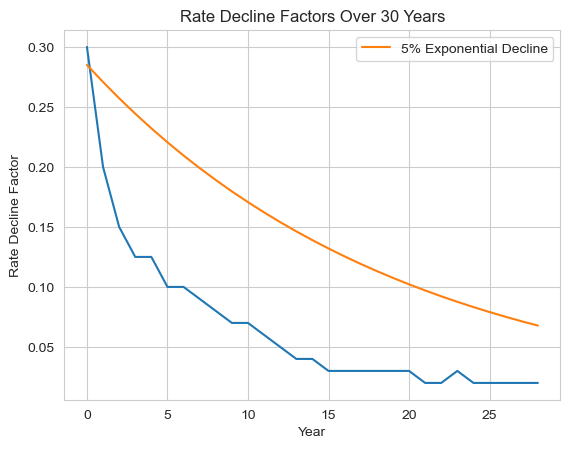

/var/folders/qy/z7337b5132l170hg74tn22yw0000gn/T/ipykernel_99160/3936876692.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '16169.999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  production_profile_df.loc[year, 'Baseline Raw Gas Rate, MSCFD'] = production_profile_df.loc[year - 1, 'Baseline Raw Gas Rate, MSCFD'] * (1 - rate_decline_factors[year-1])


,Year,"Baseline Raw Gas Rate, MSCFD","Baseline Wellhead Pressure, PSI","Deep Pressure, PSI","Shallow Pressure, PSI","Low Pressure Wellhead Pressure, PSI","High Pressure Wellhead Pressure, PSI","Low Productivity Raw Gas Rate, MSCFD","High Productivity Raw Gas Rate, MSCFD","Baseline GOR, SCF/BBL",...,"Low H2 GOR, SCF/BBL","High CH4 GOR, SCF/BBL","Mixed GOR, SCF/BBL","Low H2 w/ CH4 GOR, SCF/BBL","Low H2 w/ N2 GOR, SCF/BBL","High H2 GOR, SCF/BBL","Deep GOR, SCF/BBL","Shallow GOR, SCF/BBL","Water Production, BBL/D",Baseline WOR
0,1,23100.00,2520.00000,5160.00000,645.000000,1890.000000,3150.000000,5775.0000,46200.0,231000000.0,...,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,23.10000,231.0000
1,2,16170.00,2394.00000,4902.00000,612.750000,1795.500000,2992.500000,4042.5000,32340.0,161700000.0,...,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,16.17000,161.7000
2,3,12936.00,2274.30000,4656.90000,582.112500,1705.725000,2842.875000,3234.0000,25872.0,129360000.0,...,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,12.93600,129.3600
3,4,10995.60,2160.58500,4424.05500,553.006875,1620.438750,2700.731250,2748.9000,21991.2,109956000.0,...,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,10.99560,109.9560
4,5,9621.15,2052.55575,4202.85225,525.356531,1539.416812,2565.694687,2405.2875,19242.3,96211500.0,...,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,9.62115,96.2115


In [233]:
#Now define the assumed production profile over the life of each well. This comes from the OPGEE model, and is based on the assumption that the well will produce 1.3 BCF over its lifetime.

# Constants
pressure_coefficient = 0.42
pressure_decline_rate = 0.95
pressure_decline_rate_default = pressure_decline_rate
rate_decline_factors = np.array([
    0.3, 0.2, 0.15, 0.125, 0.125, 0.1, 0.1, 0.09, 0.08, 0.07,
    0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03,
    0.03, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02
])
rate_decline_factors = rate_decline_factors[:30]  # Ensure it has exactly 30 elements

#plot the rate decline factors
plt.plot(range(0, 29),rate_decline_factors)
plt.xlabel('Year')
plt.ylabel('Rate Decline Factor')
plt.title('Rate Decline Factors Over 30 Years')

#Add a plot of a line showing 5% exponential decline starting at 0.3 for comparison
plt.plot(range(0, 29), [0.3 * (0.95 ** i) for i in range(1, 30)], label='5% Exponential Decline')

plt.legend()

plt.show()


# Extract depths for Baseline, Deep, and Shallow from the reservoir_df
depths = reservoir_df['Depth, ft']

# Initial values calculated by depth
initial_wellhead_pressure_baseline = depths['Baseline'] * pressure_coefficient
initial_deep_pressure = depths['Deep'] * 0.43 # The OPGEE model uses a slightly different coefficient for deep and shallow wells.
initial_shallow_pressure = depths['Shallow'] * 0.43

# DataFrame initialization
production_profile_df = pd.DataFrame({
    'Year': range(1, 31),
    'Baseline Raw Gas Rate, MSCFD': [23100] * 30,  # Baseline raw gas rate
    'Baseline Wellhead Pressure, PSI': [initial_wellhead_pressure_baseline] * 30,
    'Deep Pressure, PSI': [initial_deep_pressure] * 30,
    'Shallow Pressure, PSI': [initial_shallow_pressure] * 30
})

# Calculate the baseline raw gas rate and wellhead pressure for each year
for year in range(1, 30):  # Skip the first year as the initial values are already set
    production_profile_df.loc[year, 'Baseline Raw Gas Rate, MSCFD'] = production_profile_df.loc[year - 1, 'Baseline Raw Gas Rate, MSCFD'] * (1 - rate_decline_factors[year-1])
    production_profile_df.loc[year, 'Baseline Wellhead Pressure, PSI'] = production_profile_df.loc[year - 1, 'Baseline Wellhead Pressure, PSI'] * pressure_decline_rate
    production_profile_df.loc[year, 'Deep Pressure, PSI'] = production_profile_df.loc[year - 1, 'Deep Pressure, PSI'] * pressure_decline_rate
    production_profile_df.loc[year, 'Shallow Pressure, PSI'] = production_profile_df.loc[year - 1, 'Shallow Pressure, PSI'] * pressure_decline_rate

# Update other pressures based on the baseline wellhead pressure
production_profile_df['Low Pressure Wellhead Pressure, PSI'] = production_profile_df['Baseline Wellhead Pressure, PSI'] * 0.75
production_profile_df['High Pressure Wellhead Pressure, PSI'] = production_profile_df['Baseline Wellhead Pressure, PSI'] * 1.25

# Update the low and high productivity raw gas rate values
production_profile_df['Low Productivity Raw Gas Rate, MSCFD'] = production_profile_df['Baseline Raw Gas Rate, MSCFD'] * 0.25
production_profile_df['High Productivity Raw Gas Rate, MSCFD'] = production_profile_df['Baseline Raw Gas Rate, MSCFD'] * 2

# Calculate the baseline Gas Oil Ratio (GOR)
production_profile_df['Baseline GOR, SCF/BBL'] = production_profile_df['Baseline Raw Gas Rate, MSCFD'] * 1000 / oil_production_default
# Calculate the low productivity Gas Oil Ratio (GOR)
production_profile_df['Low Productivity GOR, SCF/BBL'] = production_profile_df['Low Productivity Raw Gas Rate, MSCFD'] * 1000 / oil_production_default
# Calculate the high productivity Gas Oil Ratio (GOR)
production_profile_df['High Productivity GOR, SCF/BBL'] = production_profile_df['High Productivity Raw Gas Rate, MSCFD'] * 1000 / oil_production_default
# Assume the Gas Oil Ratio (GOR) for the remaining cases ('High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow') are the same as the baseline GOR
production_profile_df['Low H2 GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']
production_profile_df['High CH4 GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']
production_profile_df['Mixed GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']
production_profile_df['Low H2 w/ CH4 GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']
production_profile_df['Low H2 w/ N2 GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']
production_profile_df['High H2 GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']
production_profile_df['Deep GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']
production_profile_df['Shallow GOR, SCF/BBL'] = production_profile_df['Baseline GOR, SCF/BBL']

# Calculate baseline water production in barrels per day
production_profile_df['Water Production, BBL/D'] = production_profile_df['Baseline Raw Gas Rate, MSCFD']/1000 * water_production_default

# Calculate the baseline Water Oil Ratio (WOR)
production_profile_df['Baseline WOR'] = production_profile_df['Water Production, BBL/D'] / oil_production_default

# Print the DataFrame
production_profile_df.head()

# Sources of Emissions per Brandt Paper:
Brandt's paper considers that the following categories of emissions contribute to the total emissions associated with a geologic hydrogen development:

1.  Operational Combustion
1.  Operational Venting, Flaring and Fugitive Emissions (VFF)
1.  Drilling energy-use and VFF
1.  Emissions embodied in wellbore construction materials and surface equipment
1.  "Other" offsite emissions
1.  "Small sources" of emissions, not significant enough to be modelled individually but included as course, aggregated estimates.

The following sections will consider each of these emissions categories and replicate the accounting for these sources.







# 1: Operational Combustion Emissions

Total operational combustion emissions are those associated with combustion during operation. These are only relevant in certain cases. In the baseline case, it is assumed that a portion of the produced H2 is used to provide power for compression (both upstream of gas treatment and upstream of waste gas re-injection), dehydration, and pressure-swing adsorption (PSA) separation.

Hydrogen combustion is assumed to have no CO2e emissions, so the baseline case has no Operational Combustion Emissions.

Other cases (e.g. high CH4 fields, where the CH4 is "self used" for the processes listed above) will have Operational Combustion Emissions. These will be assessed after replicating the baseline conditions.

In [234]:
baseline_operational_combustion_emissions = 0 #kg CO2e/d



# 2: Operational Venting, Flaring and Fugitive Emissions (VFF)

Brandt paper: "VFF emissions include all purposeful (vented) and un-purposeful (fugitive) emissions from process units and piping."

Each of sub-category (i.e. venting, flaring, or fugitive) is calculated individually, per each of the following process stages:

1.   Production & Extraction
2.   Surface Processing

The following two sub-categories are associated with VFF-type emissions, however these are separated out into a separate section. See Section 3, below.

3.   Exploration
4.   Drilling & Development

The following sub-categories are included in the full OPGEE analysis model, but are not considered relevant to geologic H2 production:

5.   Liquefied Natural Gas
6.   Maintenance
7.   Waste disposal
8.   Crude oil transport and storage
9.   Other Gas transport, storage, and distribution
10.  Electricity generation

Note also that the baseline case does not include any flaring, so it is sufficient to only consider Venting and Fugitive emissions for this specific case.

The following sections detail Venting and Flaring calculations for each of the relevant items above (i.e. Exploration and Drilling & Development).



### 2.1.1 Production & Extraction Venting

The OPGEE tool considers the following potential sources of vented emissions.

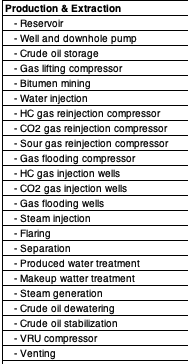

Of these, Brandt's baseline case shows emissions from the "Well and downhole pump", "HC gas reinjection compressor", "HC gas injection wells", and "Separation" process stages. Thus, these calculations are replicated below.

The basis of this calculation is to take the weighted sum (in terms of Global Warming Potential, i.e. ensuring CO2-equivalence) of emissions in each component associated with the "well & downhole pump" part of the system. These components are:


* Fugitives - Completions
    * OPGEE labels this as fugitive, but logic actually classifies these emissions as vents
    * "Total gas lost during completions divided by gas production"
    * OPGEE uses a database of tonnes of fugitive emissions per activity in terms of CO2 and CH4. For Geologic H2, Brandt assumes that total mass of emissions per activity are consistent with the database values, but that the composition of the emissions are aligned with the assumptions regarding the reservoir composition (i.e. high H2, low CH4 and CO2).
* Fugitives - Workovers
    * "Total gas lost during workovers divided by gas production"
    * Assumes total gas for all workovers over field life and then calculates a loss rate as this total divided by total gas production. Loss is apportioned per reservoir composition.
* Pneumatic controllers
    * 0.0000%
    * Loss rate calculated in same manner as wellhead, above.
* Liquids unloadings
    * This loss rate is dependent on gas rate, so needs to be calculated for each year of field life.
* On-site tanks - vents
    * 0.000% - No tanks in design.



In [235]:
#Brandt's model shows that the loss rate at the well head increases as production decreases. These rates are extracted from Brandt's model as follows:

#Loss rates for this section are all based on flow rates downstream of the separator, so first calculate these rates. Create variables for all gases (CH4, H2, N2, CO2) downstream of the separator
#because these are required later, even if they are not considered for vented/fugitive emissions.

def calculate_total_production_vent_emissions(case, sensitivity_variables =None):
    if sensitivity_variables:
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        oil_production = oil_production_default
        GWP_H2 = GWP_H2_default
    
    #Error handling. Valid cases are 'Baseline', 'Low productivity', 'High productivity', 'High CH4', 'Mixed', 'Low H2', 'Low H2 w/ CH4', 'Low H2 w/ N2', 'High H2', 'Deep', 'Shallow'

    CH4_after_separator = (
        gas_composition_df.loc[case, 'CH4'] / 100 *
        oil_production *
        production_profile_df[f'{case} GOR, SCF/BBL'] / 1E6 *
        gas_densities.loc['CH4', 'Density tonne/MMSCF']
    )
    H2_after_separator = (
        gas_composition_df.loc[case, 'H2'] / 100 *
        oil_production *
        production_profile_df[f'{case} GOR, SCF/BBL'] / 1E6 *
        gas_densities.loc['H2', 'Density tonne/MMSCF']
    )
    N2_after_separator = (
        gas_composition_df.loc[case, 'N2'] / 100 *
        oil_production *
        production_profile_df[f'{case} GOR, SCF/BBL'] / 1E6 *
        gas_densities.loc['N2', 'Density tonne/MMSCF']
    )
    CO2_after_separator = (
        gas_composition_df.loc[case, 'CO2'] / 100 *
        oil_production *
        production_profile_df[f'{case} GOR, SCF/BBL'] / 1E6 *
        gas_densities.loc['CO2', 'Density tonne/MMSCF']
    )

    #First consider venting associated with completions. Calculate CH4 and H2 separately, then calculate their sum.
    production_vent_completions_CH4 = 0.0000508137868256929 * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * Gas Rate

    production_vent_completions_H2 = 0.0000508137868256929 * GWP_H2 * H2_after_separator #Loss Rate * GWP * Gas Rate

    production_vent_completions_emissions = production_vent_completions_CH4 + production_vent_completions_H2 #This gives a series of 30 results. i.e. per year of field life.

    #Now consider venting associated with workovers. Logic identical to above, but with a slightly different loss rate of 0.0048%
    production_vent_workovers_CH4 = 0.000048324093465614 * GWP_CH4 * CH4_after_separator

    production_vent_workovers_H2 = 0.000048324093465614 * GWP_H2 * H2_after_separator

    production_vent_workovers_emissions = production_vent_workovers_CH4 + production_vent_workovers_H2

    #Now looking at the vents associated with Liquids Unloadings:

    #Liquids unloadings vary according to rate of production from the field, so baseline loss rates have been extracted from Brandt's model for each year of field life:

    liquids_unloadings_percentages = np.array([
        0.022286, 0.035370, 0.045185, 0.045185, 0.047776, 0.069842, 0.075147, 0.075147, 0.075147,
        0.075147, 0.075147, 0.075147, 0.075147, 0.075147, 0.093191, 0.103238, 0.103238, 0.103238,
        0.103238, 0.114288, 0.114288, 0.114288, 0.114288, 0.114288, 0.114288, 0.114498, 0.114498,
        0.114498, 0.114498, 0.114498
    ])

    #Instead of taking results from Brandt's model, the following section replicates the underlying calculations.

    # liquids_unloading_plunger_loss_rate = 
    
    # liquids_unloading_non_plunger_loss_rate = 

    # liquids_unloading_rates = wells_LUp * liquids_unloading_plunger_loss_rate + wells_LUnp * liquids_unloading_non_plunger_loss_rate

    liquids_unloading_rates = liquids_unloadings_percentages / 100

    # Create the DataFrame
    df_liquids_unloadings = pd.DataFrame({
        'Year': range(1, 31),
        'Liquids Unloadings %': liquids_unloading_rates
    })

    production_vent_liquids_CH4 = df_liquids_unloadings['Liquids Unloadings %'] * GWP_CH4 * CH4_after_separator #Ratios are stored as decimals, not percentages, so no need to divide by 100.
    production_vent_liquids_H2 = df_liquids_unloadings['Liquids Unloadings %'] * GWP_H2 * H2_after_separator

    production_vent_liquids_emissions = production_vent_liquids_CH4 + production_vent_liquids_H2

    total_production_vent_emissions = production_vent_completions_emissions + production_vent_workovers_emissions + production_vent_liquids_emissions #tCO2e/day

    return {
        'case': case,
        'total_production_vent_emissions': total_production_vent_emissions,
        'production_vent_completions_emissions': production_vent_completions_emissions,
        'production_vent_workovers_emissions': production_vent_workovers_emissions,
        'production_vent_liquids_emissions': production_vent_liquids_emissions,
        'CH4_after_separator': CH4_after_separator,
        'H2_after_separator': H2_after_separator,
        'N2_after_separator': N2_after_separator,
        'CO2_after_separator': CO2_after_separator
    }
        
# #Test the function:
# total_production_vent_emissions = calculate_total_production_vent_emissions('High H2')
# print(f"Case: {total_production_vent_emissions['case']}, Total Production Vent Emissions: {total_production_vent_emissions['total_production_vent_emissions']}")
       


### 2.1.2 Production & Extraction Fugitive

* Fugitives - Wellhead
    * Calculated as fractional loss rate. This loss rate is calculated as the average of emissions of this component under different flowrates (divided into 10 "tranches"), weighted against the relative volume of gas produced in each flowrate tranche.
* On-site meter
    * Loss rate calculated in same manner as wellhead, above.
* On-site dehydrator
    * Loss rate calculated in same manner as wellhead, above.
* On-site reciprocating compressor
    * Loss rate calculated in same manner as wellhead, above.
* On-site heater
    * Loss rate calculated in same manner as wellhead, above.
* On-site header
    * 0.0000%
    * Loss rate calculated in same manner as wellhead, above.
* Chemical injection pumps
    * Loss rate calculated in same manner as wellhead, above.
* On-site tanks - leaks
    * 0.000% - No tanks in design.

In [236]:
#Create a helper function to calculate fugitive emissions from the production phase of the field:
def calculate_total_production_fugitive_emissions(case, sensitivity_variables =None):
    if sensitivity_variables:
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        oil_production = oil_production_default
        GWP_H2 = GWP_H2_default

    # First, retrieve the CH4 and H2 values after the separator from the vents calculation
    vent_outputs = calculate_total_production_vent_emissions(case)
    CH4_after_separator = vent_outputs['CH4_after_separator']
    H2_after_separator = vent_outputs['H2_after_separator']
        
    wellhead_fugitive_percentages= np.array([
        0.073042, 0.102432, 0.130786, 0.130786, 0.134990, 0.179778, 0.195050, 0.195050, 0.195050,
        0.195050, 0.195050, 0.195050, 0.195050, 0.195050, 0.220065, 0.244452, 0.244452, 0.244452,
        0.244452, 0.274038, 0.274038, 0.274038, 0.274038, 0.274038, 0.274038, 0.274519, 0.274519,
        0.274519, 0.274519, 0.274519
    ])

    wellhead_fugitive_loss_rates = wellhead_fugitive_percentages / 100 #Convert percentages to decimals, to be consistent with other calculations elsewhere in the model.

    # Create the DataFrame
    df_wellhead_fugitive_loss_rates = pd.DataFrame({
        'Year': range(1, 31),
        'Wellhead Fugitive Losses %': wellhead_fugitive_loss_rates
    })

    production_fugitive_wellhead_CH4 = df_wellhead_fugitive_loss_rates['Wellhead Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_wellhead_H2 = df_wellhead_fugitive_loss_rates['Wellhead Fugitive Losses %'] * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_wellhead = production_fugitive_wellhead_CH4 + production_fugitive_wellhead_H2

    ### Now looking at the meter fugitive losses, which also change over the life of the field:

    # Meter fugitive loss rates extracted from Brandt's model
    meter_fugitive_percentages = np.array([
        0.045713, 0.063821, 0.085305, 0.085305, 0.090005, 0.117416, 0.127744, 0.127744, 0.127744,
        0.127744, 0.127744, 0.127744, 0.127744, 0.127744, 0.152734, 0.164370, 0.164370, 0.164370,
        0.164370, 0.197726, 0.197726, 0.197726, 0.197726, 0.197726, 0.197726, 0.198287, 0.198287,
        0.198287, 0.198287, 0.198287
    ])

    meter_fugitive_loss_rates = meter_fugitive_percentages / 100 #Convert percentages to decimals, to be consistent with other calculations elsewhere in the model.

    # Create the DataFrame for meter fugitive losses
    df_meter_fugitive_losses = pd.DataFrame({
        'Year': range(1, 31),
        'Meter Fugitive Losses %': meter_fugitive_loss_rates
    })

    production_fugitive_meter_CH4 = df_meter_fugitive_losses['Meter Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_meter_H2 = df_meter_fugitive_losses['Meter Fugitive Losses %']  * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_meter = production_fugitive_meter_CH4 + production_fugitive_meter_H2

    ### Dehydrator fugitive loss rates
    dehydrator_fugitive_percentages = np.array([
        0.001652, 0.002315, 0.003324, 0.003324, 0.003659, 0.004127, 0.005150, 0.005150, 0.005150,
        0.005150, 0.005150, 0.005150, 0.005150, 0.005150, 0.005773, 0.006185, 0.006185, 0.006185,
        0.006185, 0.010305, 0.010305, 0.010305, 0.010305, 0.010305, 0.010305, 0.010315, 0.010315,
        0.010315, 0.010315, 0.010315
    ])

    dehydrator_fugitive_loss_rates = dehydrator_fugitive_percentages / 100 #Convert percentages to decimals, to be consistent with other calculations elsewhere in the model.

    # Create the DataFrame for dehydrator fugitive losses
    df_dehydrator_fugitive_losses = pd.DataFrame({
        'Year': range(1, len(dehydrator_fugitive_loss_rates) + 1),
        'Dehydrator Fugitive Losses %': dehydrator_fugitive_loss_rates
    })

    # Calculate the CH4 and H2 components of fugitive emissions from dehydrators
    production_fugitive_dehydrator_CH4 = df_dehydrator_fugitive_losses['Dehydrator Fugitive Losses %']  * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_dehydrator_H2 = df_dehydrator_fugitive_losses['Dehydrator Fugitive Losses %'] * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
    # Sum the CH4 and H2 components to get the total fugitive emissions from dehydrators
    production_fugitive_dehydrator = production_fugitive_dehydrator_CH4 + production_fugitive_dehydrator_H2

    ### Compressor fugitive losses:

    # Compressor fugitive loss rates
    compressor_fugitive_percentages = np.array([
        0.006438, 0.009546, 0.012612, 0.012612, 0.012981, 0.019398, 0.020913, 0.020913, 0.020913,
        0.020913, 0.020913, 0.020913, 0.020913, 0.020913, 0.028692, 0.031455, 0.031455, 0.031455,
        0.031455, 0.033691, 0.033691, 0.033691, 0.033691, 0.033691, 0.033691, 0.033761, 0.033761,
        0.033761, 0.033761, 0.033761
    ])

    compressor_fugitive_loss_rates = compressor_fugitive_percentages / 100 #Convert percentages to decimals, to be consistent with other calculations elsewhere in the model.

    # Create the DataFrame for compressor fugitive losses
    df_compressor_fugitives = pd.DataFrame({
        'Year': range(1, len(compressor_fugitive_loss_rates) + 1),
        'Compressor Fugitive Losses %': compressor_fugitive_loss_rates
    })

    # Calculate the CH4 and H2 components of fugitive emissions from compressors
    production_fugitive_compressor_CH4 = df_compressor_fugitives['Compressor Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_compressor_H2 = df_compressor_fugitives['Compressor Fugitive Losses %'] * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
    # Sum the CH4 and H2 components to get the total fugitive emissions from compressors
    production_fugitive_compressor = production_fugitive_compressor_CH4 + production_fugitive_compressor_H2

    ### Heater fugitive losses:

    # Heater fugitive loss rates
    heater_fugitive_percentages = np.array([
        0.002672, 0.003710, 0.005876, 0.005876, 0.006623, 0.007484, 0.008829, 0.008829, 0.008829,
        0.008829, 0.008829, 0.008829, 0.008829, 0.008829, 0.010364, 0.011616, 0.011616, 0.011616,
        0.011616, 0.016787, 0.016787, 0.016787, 0.016787, 0.016787, 0.016787, 0.016800, 0.016800,
        0.016800, 0.016800, 0.016800
    ])

    heater_fugitive_loss_rates = heater_fugitive_percentages / 100 #Convert percentages to decimals, to be consistent with other calculations elsewhere in the model.

    # Create the DataFrame for heater fugitive losses
    df_production_fugitive_heater = pd.DataFrame({
        'Year': range(1, 31),
        'Heater Fugitive Losses %': heater_fugitive_loss_rates
    })

    # Calculate the CH4 and H2 components of fugitive emissions from heaters
    production_fugitive_heater_CH4 = df_production_fugitive_heater['Heater Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_heater_H2 = df_production_fugitive_heater['Heater Fugitive Losses %'] * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate
    # Sum the CH4 and H2 components to get the total fugitive emissions from heaters
    production_fugitive_heater = production_fugitive_heater_CH4 + production_fugitive_heater_H2

    ### Chemical Pump fugitive losses:

    # Chemical pumps fugitive loss rates
    chempumps_fugitive_loss_percentages = np.array([
        0.015471, 0.024089, 0.030308, 0.030308, 0.034018, 0.048136, 0.054173, 0.054173, 0.054173,
        0.054173, 0.054173, 0.054173, 0.054173, 0.054173, 0.068415, 0.080419, 0.080419, 0.080419,
        0.080419, 0.094304, 0.094304, 0.094304, 0.094304, 0.094304, 0.094304, 0.094402, 0.094402,
        0.094402, 0.094402, 0.094402
    ])

    chempumps_fugitive_loss_rates = chempumps_fugitive_loss_percentages / 100 #Convert percentages to decimals, to be consistent with other calculations elsewhere in the model.

    # Create the DataFrame for chemical pumps fugitive losses
    df_production_fugitive_chempumps = pd.DataFrame({
        'Year': range(1, 31),
        'Chemical Pumps Fugitive Losses %': chempumps_fugitive_loss_rates
    })

    # Calculate the CH4 and H2 components of fugitive emissions from chemical pumps
    production_fugitive_chempumps_CH4 = df_production_fugitive_chempumps['Chemical Pumps Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Loss Rate * GWP * gas rate
    production_fugitive_chempumps_H2 = df_production_fugitive_chempumps['Chemical Pumps Fugitive Losses %'] * GWP_H2 * H2_after_separator #Loss Rate * GWP * gas rate

    # Sum the CH4 and H2 components to get the total fugitive emissions from chemical pumps
    production_fugitive_chempumps = production_fugitive_chempumps_CH4 + production_fugitive_chempumps_H2

    total_production_fugitive_emissions = (
        production_fugitive_wellhead + production_fugitive_meter + production_fugitive_dehydrator +
        production_fugitive_compressor + production_fugitive_heater + production_fugitive_chempumps
    )
    #Add a heading to the output to indicate the case being considered so it can be returned by the function: 
    return {
        'case': case,
        'production_fugitive_wellhead': production_fugitive_wellhead,
        'production_fugitive_meter': production_fugitive_meter,
        'production_fugitive_dehydrator': production_fugitive_dehydrator,
        'production_fugitive_compressor': production_fugitive_compressor,
        'production_fugitive_heater': production_fugitive_heater,
        'production_fugitive_chempumps': production_fugitive_chempumps,
        'total_production_fugitive_emissions': total_production_fugitive_emissions
    }

# # Example usage:
# emissions_info = calculate_total_production_fugitive_emissions('High CH4')
# print(f"Case: {emissions_info['case']}, Total Fugitive Emissions: {emissions_info['total_production_fugitive_emissions']}")


## 2.2.1 Surface Processing Fugitives

Fugitive emissions via surface processing are assumed to only occur as part of 'gas gathering'. This is calculated similarly as in 2.1, above, with a fractional loss rate applied to the gas production rate at the relevant point in the process flow.

In [237]:
#Helper function for fugitive emissions from surface processing:

def calculate_gas_gathering_fugitives(case, sensitivity_variables =None):
    if sensitivity_variables:
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        GWP_H2 = GWP_H2_default
        

    # First, retrieve the CH4 and H2 values after the separator from the vents calculation
    vent_outputs = calculate_total_production_vent_emissions(case)
    CH4_after_separator = vent_outputs['CH4_after_separator']
    H2_after_separator = vent_outputs['H2_after_separator']

    gas_gathering_fugitive_rate = 0.00495897945648821 #Taken from OPGEE model. Does not vary with production rate.

    gas_gathering_fugitive_CH4 = gas_gathering_fugitive_rate * GWP_CH4 * CH4_after_separator
    gas_gathering_fugitive_H2 = gas_gathering_fugitive_rate * GWP_H2 * H2_after_separator
    gas_gathering_fugitives = gas_gathering_fugitive_CH4 + gas_gathering_fugitive_H2

    return {
        'case': case,
        'gas_gathering_fugitive_CH4': gas_gathering_fugitive_CH4,
        'gas_gathering_fugitive_H2': gas_gathering_fugitive_H2,
        'gas_gathering_fugitives': gas_gathering_fugitives
    }

# #Example usage:
# gas_gathering_fugitives_info = calculate_gas_gathering_fugitives('High CH4')
# print(f"Case: {gas_gathering_fugitives_info['case']}, Gas Gathering Fugitives: {gas_gathering_fugitives_info['gas_gathering_fugitives']}")

## 2.2.2 Surface Processing Venting

Vented emissions through surface processing are assumed to only occur as part of gas dehydration (i.e. the glycol unit).



In [238]:
#Helper function:
def calculate_gas_dehydration_vents(case, sensitivity_variables =None):
    if sensitivity_variables:
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        GWP_H2 = GWP_H2_default
    
    # First, retrieve the CH4 and H2 values after the separator from the vents calculation
    vent_outputs = calculate_total_production_vent_emissions(case)
    CH4_after_separator = vent_outputs['CH4_after_separator']
    H2_after_separator = vent_outputs['H2_after_separator']
    
    # Call the gas gathering fugitives function and store the results
    fugitives = calculate_gas_gathering_fugitives(case)

    # Extract the CH4 and H2 after accounting for fugitive losses
    CH4_after_gas_gathering = CH4_after_separator - fugitives['gas_gathering_fugitive_CH4'] / GWP_CH4
    H2_after_gas_gathering = H2_after_separator - fugitives['gas_gathering_fugitive_H2'] / GWP_H2

    # Calculate the vents rates downstream of gas gathering (i.e., upstream of dehydration)
    gas_dehydration_vent_rate = 0.000810912362269712  # Taken from OPGEE model. This value is a ratio/decimal, not a percentage, so no conversion is required.

    # Calculate CH4 and H2 emissions from dehydration venting
    gas_dehydration_vent_CH4 = gas_dehydration_vent_rate * GWP_CH4 * CH4_after_gas_gathering
    gas_dehydration_vent_H2 = gas_dehydration_vent_rate * GWP_H2 * H2_after_gas_gathering
    gas_dehydration_vents = gas_dehydration_vent_CH4 + gas_dehydration_vent_H2

    #For later use, now calculate the gas flows remaining downstream of the dehydration system:

    CH4_after_dehy = CH4_after_gas_gathering - gas_dehydration_vent_CH4/GWP_CH4
    H2_after_dehy = H2_after_gas_gathering - gas_dehydration_vent_H2/GWP_H2

    return {
        'case': case,
        'gas_dehydration_vents': gas_dehydration_vents,
        'CH4_after_dehy': CH4_after_dehy,
        'H2_after_dehy': H2_after_dehy
    }

# # Test usage
# gas_dehydration_vents_info = calculate_gas_dehydration_vents('High CH4')
# print(f"Case: {gas_dehydration_vents_info['case']}, Gas Dehydration Vents: {gas_dehydration_vents_info['gas_dehydration_vents']}")


## 2.3 HC gas reinjection compressor

The Brandt paper assumes that non-H2 captured waste streams are compressed and re-injected into the subsurface. This factor estimates the amount of fugitive emissions through the compressor sub-system.



In [247]:
def calculate_HC_gas_reinjection_compressor_fugitives(case, sensitivity_variables =None):
    if sensitivity_variables:
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        field_lifespan = field_lifespan_default
        GWP_H2 = GWP_H2_default
        

    # Take the loss rates for the baseline case from the OPGEE model:

    HC_gas_reinjection_compressor_loss_rates = np.array([
        0.000163391, 0.000163391, 0.000163391, 0.000163391, 0.000163391, 0.000163391, 0.000163391, 0.000163391,
        0.000163391, 0.000163391, 0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102,
        0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102,
        0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102, 0.000365102
    ])

    # Create the DataFrame
    df_HC_gas_reinjection_compressor_loss_rates = pd.DataFrame({
        'Year': range(1, len(HC_gas_reinjection_compressor_loss_rates) + 1),
        'HC Gas Reinjection Compressor Loss Rates': HC_gas_reinjection_compressor_loss_rates
    })

    # Call calculate_gas_dehydration_vents to get the CH4 and H2 values after dehydration and determine the mass flows to the reinjection compressors
    gas_dehydration_vents_info = calculate_gas_dehydration_vents(case)
    CH4_after_dehy = gas_dehydration_vents_info['CH4_after_dehy'] #CH4 to reinjection is the same as CH4 after dehydration
    CH4_to_reinjection = CH4_after_dehy

    H2_after_dehy = gas_dehydration_vents_info['H2_after_dehy']
    H2_to_reinjection = H2_after_dehy * PSA_unit_slippage_rate #All of non-product gas stream from PSA unit is sent to reinjection, so this includes all of the H2 that is not properly separated by the PSA unit.
    

    # Calculate the CH4 and H2 components of fugitive emissions from HC gas reinjection compressors
    HC_gas_reinjection_compressor_fugitives_CH4 = df_HC_gas_reinjection_compressor_loss_rates['HC Gas Reinjection Compressor Loss Rates'] * GWP_CH4 * CH4_to_reinjection 
    HC_gas_reinjection_compressor_fugitives_H2 = df_HC_gas_reinjection_compressor_loss_rates['HC Gas Reinjection Compressor Loss Rates'] * GWP_H2 * H2_to_reinjection #Note the Brandt model does not include H2 emissions from this source. It is unclear why this is the case.

    # Sum the CH4 and H2 components to get the total fugitive emissions from HC gas reinjection compressors
    HC_gas_reinjection_compressor_fugitives = HC_gas_reinjection_compressor_fugitives_CH4 + HC_gas_reinjection_compressor_fugitives_H2

    return {
        'case': case,
        'CH4_to_reinjection': CH4_to_reinjection,
        'H2_to_reinjection': H2_to_reinjection,
        'HC_gas_reinjection_compressor_fugitives_CH4': HC_gas_reinjection_compressor_fugitives_CH4,
        'HC_gas_reinjection_compressor_fugitives_H2': HC_gas_reinjection_compressor_fugitives_H2,
        'HC_gas_reinjection_compressor_fugitives': HC_gas_reinjection_compressor_fugitives
    }


#Test Usage:
HC_gas_reinjection_compressor_fugitives_info = calculate_HC_gas_reinjection_compressor_fugitives('Baseline')
# print(f"Case: {HC_gas_reinjection_compressor_fugitives_info['case']}, HC Gas Reinjection Compressor Fugitives: {HC_gas_reinjection_compressor_fugitives_info['CH4_to_reinjection']}") #Checked and confirmed aligned with Brandt's model
# print(f"Case: {HC_gas_reinjection_compressor_fugitives_info['case']}, HC Gas Reinjection Compressor Fugitives: {HC_gas_reinjection_compressor_fugitives_info['H2_to_reinjection']}") #Checked and confirmed aligned with Brandt's model
print(f"Case: {HC_gas_reinjection_compressor_fugitives_info['case']}, HC Gas Reinjection Compressor Fugitives: {HC_gas_reinjection_compressor_fugitives_info['HC_gas_reinjection_compressor_fugitives_CH4']}")
# print(f"Case: {HC_gas_reinjection_compressor_fugitives_info['case']}, HC Gas Reinjection Compressor Fugitives: {HC_gas_reinjection_compressor_fugitives_info['HC_gas_reinjection_compressor_fugitives_H2']}")
# print(f"Case: {HC_gas_reinjection_compressor_fugitives_info['case']}, HC Gas Reinjection Compressor Fugitives: {HC_gas_reinjection_compressor_fugitives_info['HC_gas_reinjection_compressor_fugitives']}")

# # Print the types of the outputs to ensure they are consistent with the expected types
# print(type(HC_gas_reinjection_compressor_fugitives_info['HC_gas_reinjection_compressor_fugitives']))

Case: Baseline, HC Gas Reinjection Compressor Fugitives: 0     0.026982
1     0.018887
2     0.015110
3     0.012843
4     0.011238
5     0.009833
6     0.008850
7     0.007965
8     0.007248
9     0.006668
10    0.013857
11    0.012887
12    0.012114
13    0.011508
14    0.011048
15    0.010606
16    0.010288
17    0.009979
18    0.009680
19    0.009389
20    0.009108
21    0.008835
22    0.008658
23    0.008485
24    0.008230
25    0.008066
26    0.007904
27    0.007746
28    0.007591
29    0.007439
dtype: float64


## 2.4 HC gas injection wells

Paper assumes certain amount of fugitive emissions downstream of the reinjection compressors, at the injection wells.

In [249]:
def calculate_HC_gas_reinjection_well_fugitives(case, sensitivity_variables =None):
    if sensitivity_variables:
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        field_lifespan = field_lifespan_default
        GWP_H2 = GWP_H2_default

    # #Contribution is small, so for the time being just take the number from the OPGEE model directly.
    # HC_gas_reinjection_well_fugitives = [0.0813978368107571] * field_lifespan #tCO2eq/d. Returning a series of values, one for each year of field life.
    # HC_gas_reinjection_well_fugitives = np.array(HC_gas_reinjection_well_fugitives)
    # return {
    #     'case': case,
    #     'HC_gas_reinjection_well_fugitives': HC_gas_reinjection_well_fugitives
    # }

    HC_gas_reinjection_well_loss_rates = np.array([
        0.001944255, 0.001944255, 0.001944255, 0.001944255, 0.001944255, 0.001944255, 0.001944255, 0.001944255,
        0.001944255, 0.001944255, 0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451,
        0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451,
        0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451, 0.005462451
    ])

    # Create the DataFrame
    df_HC_gas_reinjection_well_loss_rates = pd.DataFrame({
        'Year': range(1, len(HC_gas_reinjection_well_loss_rates) + 1),
        'HC Gas Reinjection Well Loss Rates': HC_gas_reinjection_well_loss_rates
    })

    # Call calculate_HC_gas_reinjection_compressor_fugitives to get the CH4 and H2 values to the reinjection wells
    HC_gas_reinjection_compressor_fugitives_info = calculate_HC_gas_reinjection_compressor_fugitives(case)
    CH4_to_reinjection = HC_gas_reinjection_compressor_fugitives_info['CH4_to_reinjection']
    H2_to_reinjection = HC_gas_reinjection_compressor_fugitives_info['H2_to_reinjection']

    # Calculate the CH4 and H2 components of fugitive emissions from HC gas reinjection wells
    HC_gas_reinjection_well_fugitives_CH4 = df_HC_gas_reinjection_well_loss_rates['HC Gas Reinjection Well Loss Rates'] * GWP_CH4 * CH4_to_reinjection
    HC_gas_reinjection_well_fugitives_H2 = df_HC_gas_reinjection_well_loss_rates['HC Gas Reinjection Well Loss Rates'] * GWP_H2 * H2_to_reinjection

    # Sum the CH4 and H2 components to get the total fugitive emissions from HC gas reinjection wells
    HC_gas_reinjection_well_fugitives = HC_gas_reinjection_well_fugitives_CH4 + HC_gas_reinjection_well_fugitives_H2

    return {
        'case': case,
        'HC_gas_reinjection_well_fugitives': HC_gas_reinjection_well_fugitives
    }


#Test Usage:
HC_gas_reinjection_well_fugitives_info = calculate_HC_gas_reinjection_well_fugitives('High CH4')
print(f"Case: {HC_gas_reinjection_well_fugitives_info['case']}, HC Gas Reinjection Well Fugitives: {HC_gas_reinjection_well_fugitives_info['HC_gas_reinjection_well_fugitives']}")

Case: High CH4, HC Gas Reinjection Well Fugitives: 0     2.614254
1     1.829978
2     1.463982
3     1.244385
4     1.088837
5     0.952732
6     0.857459
7     0.771713
8     0.702259
9     0.646078
10    1.688116
11    1.569948
12    1.475751
13    1.401964
14    1.345885
15    1.292050
16    1.253288
17    1.215690
18    1.179219
19    1.143842
20    1.109527
21    1.076241
22    1.054716
23    1.033622
24    1.002613
25    0.982561
26    0.962910
27    0.943652
28    0.924779
29    0.906283
dtype: float64


## 2.5 Separation

In [ ]:
#Definine a helper function for fugitive loss rates during separation:
def calculate_production_separation_fugitives(case, sensitivity_variables =None):
    if sensitivity_variables:
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
    else:
        GWP_H2 = GWP_H2_default
        field_lifespan = field_lifespan_default

    # First, retrieve the CH4 and H2 values after the separator from the vents calculation
    vent_outputs = calculate_total_production_vent_emissions(case)
    CH4_after_separator = vent_outputs['CH4_after_separator']
    H2_after_separator = vent_outputs['H2_after_separator']
    N2_after_separator = vent_outputs['N2_after_separator']
    CO2_after_separator = vent_outputs['CO2_after_separator']

    # Separation fugitive loss rates
    separation_fugitive_loss_rates = [
        0.00061497, 0.000923162, 0.001252111, 0.001252111, 0.001281899,
        0.001694345, 0.001873018, 0.001873018, 0.001873018, 0.001873018,
        0.001873018, 0.001873018, 0.001873018, 0.001873018, 0.002178708,
        0.002287947, 0.002287947, 0.002287947, 0.002287947, 0.002862778,
        0.002862778, 0.002862778, 0.002862778, 0.002862778, 0.002862778,
        0.002867841, 0.002867841, 0.002867841, 0.002867841, 0.002867841
    ]

    # Create the DataFrame for separation fugitive losses
    df_separation_fugitive = pd.DataFrame({
        'Year': range(1, 31),
        'Separation Fugitive Losses %': separation_fugitive_loss_rates
    })

    # Calculate CH4 and H2 fugitive emissions and their total
    production_separation_fugitive_CH4 = df_separation_fugitive['Separation Fugitive Losses %'] * GWP_CH4 * CH4_after_separator #Loss rates are saved as decimals, not percentage, so no need to divide by 100
    production_separation_fugitive_H2 = df_separation_fugitive['Separation Fugitive Losses %']  * GWP_H2 * H2_after_separator #Loss rates are saved as decimals, not percentage, so no need to divide by 100
    production_separation_fugitives = production_separation_fugitive_CH4 + production_separation_fugitive_H2

    #Now calculate losses for N2 and CO2, which are not considered in the above calculations:
    N2_separation_losses = df_separation_fugitive['Separation Fugitive Losses %'] * N2_after_separator 
    CO2_separation_losses = df_separation_fugitive['Separation Fugitive Losses %'] * CO2_after_separator 

    return {
        'case': case,
        'production_separation_fugitive_CH4': production_separation_fugitive_CH4,
        'production_separation_fugitive_H2': production_separation_fugitive_H2,
        'production_separation_fugitives': production_separation_fugitives,
        'N2_separation_losses': N2_separation_losses,
        'CO2_separation_losses': CO2_separation_losses
    
    }

# #Test Usage:
# production_separation_fugitives_info = calculate_production_separation_fugitives('High CH4')
# print(f"Case: {production_separation_fugitives_info['case']}, Production Separation Fugitives: {production_separation_fugitives_info['production_separation_fugitives']}")

## 2.6 Total operational VFF emissions
This is the sum total of the calculations in Sections 2.1 and 2.2, above.


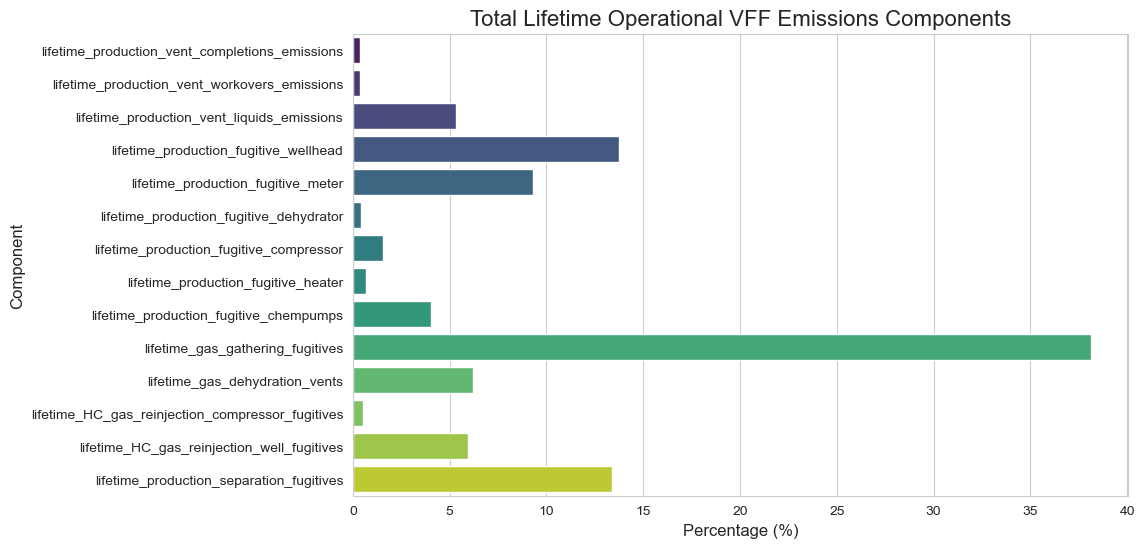

In [ ]:
def calculate_total_operational_VFF_emissions(case, sensitivity_variables=None):
    if sensitivity_variables:
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        oil_production = oil_production_default
        GWP_H2 = GWP_H2_default

    # Calculate vent emissions
    vent_emissions = calculate_total_production_vent_emissions(case)
    production_vent_completions_emissions = vent_emissions['production_vent_completions_emissions']
    production_vent_workovers_emissions = vent_emissions['production_vent_workovers_emissions']
    production_vent_liquids_emissions = vent_emissions['production_vent_liquids_emissions']

    # Calculate fugitive emissions from the production phase
    fugitive_emissions = calculate_total_production_fugitive_emissions(case)
    production_fugitive_wellhead = fugitive_emissions['production_fugitive_wellhead']
    production_fugitive_meter = fugitive_emissions['production_fugitive_meter']
    production_fugitive_dehydrator = fugitive_emissions['production_fugitive_dehydrator']
    production_fugitive_compressor = fugitive_emissions['production_fugitive_compressor']
    production_fugitive_heater = fugitive_emissions['production_fugitive_heater']
    production_fugitive_chempumps = fugitive_emissions['production_fugitive_chempumps']

    # Calculate gas gathering and dehydration vents emissions
    gas_gathering_fugitives = calculate_gas_gathering_fugitives(case)['gas_gathering_fugitives']
    gas_dehydration_vents = calculate_gas_dehydration_vents(case)['gas_dehydration_vents']

    # These functions need to be defined or modified to return numerical values
    HC_gas_reinjection_compressor_fugitives = calculate_HC_gas_reinjection_compressor_fugitives(case)['HC_gas_reinjection_compressor_fugitives']
    HC_gas_reinjection_well_fugitives = calculate_HC_gas_reinjection_well_fugitives(case)['HC_gas_reinjection_well_fugitives']
    production_separation_fugitives = calculate_production_separation_fugitives(case)['production_separation_fugitives']

    # Summing all components
    total_operational_VFF_emissions = (
        production_vent_completions_emissions +
        production_vent_workovers_emissions +
        production_vent_liquids_emissions +
        production_fugitive_wellhead +
        production_fugitive_meter +
        production_fugitive_dehydrator +
        production_fugitive_compressor +
        production_fugitive_heater +
        production_fugitive_chempumps +
        gas_gathering_fugitives +
        gas_dehydration_vents +
        HC_gas_reinjection_compressor_fugitives +
        HC_gas_reinjection_well_fugitives +
        production_separation_fugitives
    ) * 1000  # Convert from tCO2e/day to kgCO2e/day

    # Calculate the relative (percentage) contributions of each component of total_operational_VFF_emissions
    total_operational_VFF_emissions_component_percentages = {
        'production_vent_completions_emissions': (production_vent_completions_emissions * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_vent_workovers_emissions': (production_vent_workovers_emissions * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_vent_liquids_emissions': (production_vent_liquids_emissions * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_fugitive_wellhead': (production_fugitive_wellhead * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_fugitive_meter': (production_fugitive_meter * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_fugitive_dehydrator': (production_fugitive_dehydrator * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_fugitive_compressor': (production_fugitive_compressor * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_fugitive_heater': (production_fugitive_heater * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_fugitive_chempumps': (production_fugitive_chempumps * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'gas_gathering_fugitives': (gas_gathering_fugitives * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'gas_dehydration_vents': (gas_dehydration_vents * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'HC_gas_reinjection_compressor_fugitives': (HC_gas_reinjection_compressor_fugitives * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'HC_gas_reinjection_well_fugitives': (HC_gas_reinjection_well_fugitives * 1000).sum() / total_operational_VFF_emissions.sum() * 100,
        'production_separation_fugitives': (production_separation_fugitives * 1000).sum() / total_operational_VFF_emissions.sum() * 100
    }

    # Calculate the total lifetime operational VFF emissions by summing emissions over each year
    total_lifetime_operational_VFF_emissions = (total_operational_VFF_emissions * 365).sum()  # kgCO2e/lifetime

    # Calculate the relative (percentage) contributions of each component of total lifetime operational VFF emissions
    total_lifetime_operational_VFF_emissions_component_percentages = {
        'lifetime_production_vent_completions_emissions': (production_vent_completions_emissions * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_vent_workovers_emissions': (production_vent_workovers_emissions * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_vent_liquids_emissions': (production_vent_liquids_emissions * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_fugitive_wellhead': (production_fugitive_wellhead * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_fugitive_meter': (production_fugitive_meter * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_fugitive_dehydrator': (production_fugitive_dehydrator * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_fugitive_compressor': (production_fugitive_compressor * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_fugitive_heater': (production_fugitive_heater * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_fugitive_chempumps': (production_fugitive_chempumps * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_gas_gathering_fugitives': (gas_gathering_fugitives * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_gas_dehydration_vents': (gas_dehydration_vents * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_HC_gas_reinjection_compressor_fugitives': (HC_gas_reinjection_compressor_fugitives * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_HC_gas_reinjection_well_fugitives': (HC_gas_reinjection_well_fugitives * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100,
        'lifetime_production_separation_fugitives': (production_separation_fugitives * 365 * 1000).sum() / total_lifetime_operational_VFF_emissions * 100
    }

    return {
        'case': case,
        'total_operational_VFF_emissions': total_operational_VFF_emissions,  # kgCO2e/day
        'total_operational_VFF_emissions_component_percentages': total_operational_VFF_emissions_component_percentages,  # Percentage contributions of each component
        'production_vent_completions_emissions': production_vent_completions_emissions,
        'production_vent_workovers_emissions': production_vent_workovers_emissions,
        'production_vent_liquids_emissions': production_vent_liquids_emissions,
        'production_fugitive_wellhead': production_fugitive_wellhead,
        'production_fugitive_meter': production_fugitive_meter,
        'production_fugitive_dehydrator': production_fugitive_dehydrator,
        'production_fugitive_compressor': production_fugitive_compressor,
        'production_fugitive_heater': production_fugitive_heater,
        'production_fugitive_chempumps': production_fugitive_chempumps,
        'gas_gathering_fugitives': gas_gathering_fugitives,
        'gas_dehydration_vents': gas_dehydration_vents,
        'HC_gas_reinjection_compressor_fugitives': HC_gas_reinjection_compressor_fugitives,
        'HC_gas_reinjection_well_fugitives': HC_gas_reinjection_well_fugitives,
        'production_separation_fugitives': production_separation_fugitives,
        'total_lifetime_operational_VFF_emissions': total_lifetime_operational_VFF_emissions,  # kgCO2e/lifetime
        'total_lifetime_operational_VFF_emissions_component_percentages': total_lifetime_operational_VFF_emissions_component_percentages  # Percentage contributions of each component
    }

# Example usage
# print(calculate_total_operational_VFF_emissions('Baseline')['total_lifetime_operational_VFF_emissions_component_percentages'])

#Plot the total lifetime operational VFF emissions components for the baseline case:

def plot_total_lifetime_operational_VFF_emissions_component_percentages(case):
    # Calculate the total lifetime operational VFF emissions components
    total_lifetime_operational_VFF_emissions_component_percentages = calculate_total_operational_VFF_emissions(case)['total_lifetime_operational_VFF_emissions_component_percentages']

    # Create a DataFrame for the components
    df_total_lifetime_operational_VFF_emissions_component_percentages = pd.DataFrame({
        'Component': list(total_lifetime_operational_VFF_emissions_component_percentages.keys()),
        'Percentage': list(total_lifetime_operational_VFF_emissions_component_percentages.values())
    })

    # Plot the components
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Percentage', y='Component', data=df_total_lifetime_operational_VFF_emissions_component_percentages, palette='viridis')
    ax.set_title('Total Lifetime Operational VFF Emissions Components', fontsize=16)
    ax.set_xlabel('Percentage (%)', fontsize=12)
    ax.set_ylabel('Component', fontsize=12)
    plt.show()

# # Example usage
plot_total_lifetime_operational_VFF_emissions_component_percentages('Baseline')


In [ ]:
# def calculate_total_operational_VFF_emissions(case, sensitivity_variables =None):
#     if sensitivity_variables:
#         oil_production = sensitivity_variables.get('oil_production', oil_production_default)
#         GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
#         field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
#     else:
#         oil_production = oil_production_default
#         GWP_H2 = GWP_H2_default
#         field_lifespan = field_lifespan_default

#     # Calculate vent emissions
#     vent_emissions = calculate_total_production_vent_emissions(case)
#     production_vent_completions_emissions = vent_emissions['production_vent_completions_emissions']
#     production_vent_workovers_emissions = vent_emissions['production_vent_workovers_emissions']
#     production_vent_liquids_emissions = vent_emissions['production_vent_liquids_emissions']

#     # Calculate fugitive emissions from the production phase
#     fugitive_emissions = calculate_total_production_fugitive_emissions(case)
#     production_fugitive_wellhead = fugitive_emissions['production_fugitive_wellhead']
#     production_fugitive_meter = fugitive_emissions['production_fugitive_meter']
#     production_fugitive_dehydrator = fugitive_emissions['production_fugitive_dehydrator']
#     production_fugitive_compressor = fugitive_emissions['production_fugitive_compressor']
#     production_fugitive_heater = fugitive_emissions['production_fugitive_heater']
#     production_fugitive_chempumps = fugitive_emissions['production_fugitive_chempumps']

#     # Calculate gas gathering and dehydration vents emissions
#     gas_gathering_fugitives = calculate_gas_gathering_fugitives(case)['gas_gathering_fugitives']
#     gas_dehydration_vents = calculate_gas_dehydration_vents(case)['gas_dehydration_vents']

#     # These functions need to be defined or modified to return numerical values
#     HC_gas_reinjection_compressor_fugitives = calculate_HC_gas_reinjection_compressor_fugitives(case)['HC_gas_reinjection_compressor_fugitives']
#     HC_gas_reinjection_well_fugitives = calculate_HC_gas_reinjection_well_fugitives(case)['HC_gas_reinjection_well_fugitives']
#     production_separation_fugitives = calculate_production_separation_fugitives(case)['production_separation_fugitives']

#     # Summing all components
#     total_operational_VFF_emissions = (
#         production_vent_completions_emissions +
#         production_vent_workovers_emissions +
#         production_vent_liquids_emissions +
#         production_fugitive_wellhead +
#         production_fugitive_meter +
#         production_fugitive_dehydrator +
#         production_fugitive_compressor +
#         production_fugitive_heater +
#         production_fugitive_chempumps +
#         gas_gathering_fugitives +
#         gas_dehydration_vents +
#         HC_gas_reinjection_compressor_fugitives +
#         HC_gas_reinjection_well_fugitives +
#         production_separation_fugitives
#     ) * 1000  # Convert from tCO2e/day to kgCO2e/day

#     # Calculate the relative (percentage) contributions of each component of total_operational_VFF_emissions:
#     total_operational_VFF_emissions_component_percentages = {
#         'production_vent_completions_emissions': production_vent_completions_emissions * 1000 / total_operational_VFF_emissions * 100,
#         'production_vent_workovers_emissions': production_vent_workovers_emissions * 1000/ total_operational_VFF_emissions * 100,
#         'production_vent_liquids_emissions': production_vent_liquids_emissions * 1000 / total_operational_VFF_emissions * 100,
#         'production_fugitive_wellhead': production_fugitive_wellhead * 1000 / total_operational_VFF_emissions * 100,
#         'production_fugitive_meter': production_fugitive_meter * 1000 / total_operational_VFF_emissions * 100,
#         'production_fugitive_dehydrator': production_fugitive_dehydrator * 1000 / total_operational_VFF_emissions * 100,
#         'production_fugitive_compressor': production_fugitive_compressor * 1000 / total_operational_VFF_emissions * 100,
#         'production_fugitive_heater': production_fugitive_heater * 1000 / total_operational_VFF_emissions * 100,
#         'production_fugitive_chempumps': production_fugitive_chempumps * 1000 / total_operational_VFF_emissions * 100,
#         'gas_gathering_fugitives': gas_gathering_fugitives * 1000 / total_operational_VFF_emissions * 100,
#         'gas_dehydration_vents': gas_dehydration_vents * 1000 / total_operational_VFF_emissions * 100,
#         'HC_gas_reinjection_compressor_fugitives': HC_gas_reinjection_compressor_fugitives * 1000 / total_operational_VFF_emissions * 100,
#         'HC_gas_reinjection_well_fugitives': HC_gas_reinjection_well_fugitives * 1000 / total_operational_VFF_emissions * 100,
#         'production_separation_fugitives': production_separation_fugitives * 1000 / total_operational_VFF_emissions * 100
#     }

#     # Calculate the total lifetime operational VFF emissions:
#     total_lifetime_operational_VFF_emissions = (total_operational_VFF_emissions*365).sum() #kgCO2e/lifetime

#     # # Calculate the total lifetime emissions from each component of the total operational VFF emissions:
#     # total_lifetime_operational_VFF_emissions_component_percentages = {
#     #     'lifetime_production_vent_completions_emissions': (production_vent_completions_emissions * 365).sum(),
#     #     'lifetime_production_vent_workovers_emissions': (production_vent_workovers_emissions * 365).sum(),
#     #     'lifetime_production_vent_liquids_emissions': (production_vent_liquids_emissions * 365).sum(),
#     #     'lifetime_production_fugitive_wellhead': (production_fugitive_wellhead * 365).sum(),
#     #     'lifetime_production_fugitive_meter': (production_fugitive_meter * 365).sum(),
#     #     'lifetime_production_fugitive_dehydrator': (production_fugitive_dehydrator * 365).sum(),
#     #     'lifetime_production_fugitive_compressor': (production_fugitive_compressor * 365).sum(),
#     #     'lifetime_production_fugitive_heater': (production_fugitive_heater * 365).sum(),
#     #     'lifetime_production_fugitive_chempumps': (production_fugitive_chempumps * 365).sum(),
#     #     'lifetime_gas_gathering_fugitives': (gas_gathering_fugitives * 365).sum(),
#     #     'lifetime_gas_dehydration_vents': (gas_dehydration_vents * 365).sum(),
#     #     'lifetime_HC_gas_reinjection_compressor_fugitives': (HC_gas_reinjection_compressor_fugitives * 365).sum(),
#     #     'lifetime_HC_gas_reinjection_well_fugitives': (HC_gas_reinjection_well_fugitives * 365).sum(),
#     #     'lifetime_production_separation_fugitives': (production_separation_fugitives * 365).sum()  
#     # }

#     # Calculate the relative (percentage) contributions of each component of total lifetime operational VFF emissions:
#     total_lifetime_operational_VFF_emissions_component_percentages = {
#         'lifetime_production_vent_completions_emissions': (production_vent_completions_emissions * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_vent_workovers_emissions': (production_vent_workovers_emissions * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_vent_liquids_emissions': (production_vent_liquids_emissions * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_fugitive_wellhead': (production_fugitive_wellhead * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_fugitive_meter': (production_fugitive_meter * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_fugitive_dehydrator': (production_fugitive_dehydrator * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_fugitive_compressor': (production_fugitive_compressor * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_fugitive_heater': (production_fugitive_heater * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_fugitive_chempumps': (production_fugitive_chempumps * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_gas_gathering_fugitives': (gas_gathering_fugitives * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_gas_dehydration_vents': (gas_dehydration_vents * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_HC_gas_reinjection_compressor_fugitives': (HC_gas_reinjection_compressor_fugitives * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_HC_gas_reinjection_well_fugitives': (HC_gas_reinjection_well_fugitives * 365).sum() / total_lifetime_operational_VFF_emissions * 100,
#         'lifetime_production_separation_fugitives': (production_separation_fugitives * 365).sum() / total_lifetime_operational_VFF_emissions * 100
#     }



#     return {
#         'case': case,
#         'total_operational_VFF_emissions': total_operational_VFF_emissions, #kgCO2e/day
#         'total_operational_VFF_emissions_component_percentages': total_operational_VFF_emissions_component_percentages, #Percentage contributions of each component
#         'production_vent_completions_emissions': production_vent_completions_emissions,
#         'production_vent_workovers_emissions': production_vent_workovers_emissions,
#         'production_vent_liquids_emissions': production_vent_liquids_emissions,
#         'production_fugitive_wellhead': production_fugitive_wellhead,
#         'production_fugitive_meter': production_fugitive_meter,
#         'production_fugitive_dehydrator': production_fugitive_dehydrator,
#         'production_fugitive_compressor': production_fugitive_compressor,
#         'production_fugitive_heater': production_fugitive_heater,
#         'production_fugitive_chempumps': production_fugitive_chempumps,
#         'gas_gathering_fugitives': gas_gathering_fugitives,
#         'gas_dehydration_vents': gas_dehydration_vents,
#         'HC_gas_reinjection_compressor_fugitives': HC_gas_reinjection_compressor_fugitives,
#         'HC_gas_reinjection_well_fugitives': HC_gas_reinjection_well_fugitives,
#         'production_separation_fugitives': production_separation_fugitives,
#         'total_lifetime_operational_VFF_emissions': total_lifetime_operational_VFF_emissions, #kgCO2e/lifetime
#         'total_lifetime_operational_VFF_emissions_component_percentages': total_lifetime_operational_VFF_emissions_component_percentages #Percentage contributions of each component
#     }

# # # Example usage
# # case = 'High CH4'
# # total_VFF_emissions_kgCO2e = calculate_total_operational_VFF_emissions(case)['total_operational_VFF_emissions']
# # print(f"Total Operational VFF Emissions for {case}: {total_VFF_emissions_kgCO2e} kgCO2e/day")

# print(calculate_total_operational_VFF_emissions('Baseline')['total_lifetime_operational_VFF_emissions_component_percentages'])

# #Plot the total operational VFF emissions components for the baseline case:
# def plot_total_operational_VFF_emissions_component_percentages(case):
#     # Calculate the total operational VFF emissions
#     total_operational_VFF_emissions_info = calculate_total_operational_VFF_emissions(case)
#     total_operational_VFF_emissions_component_percentages = total_operational_VFF_emissions_info['total_operational_VFF_emissions_component_percentages']

#     # Create a DataFrame from the dictionary
#     df_total_operational_VFF_emissions_component_percentages = pd.DataFrame(total_operational_VFF_emissions_component_percentages, index=[0]) # Convert to percentages

#     # Melt the DataFrame to long format
#     df_total_operational_VFF_emissions_component_percentages_melted = df_total_operational_VFF_emissions_component_percentages.melt(var_name='Component', value_name='Emissions Percentage')

#     # Plot the total operational VFF emissions components
#     plt.figure(figsize=(12, 6))
#     sns.barplot(x='Emissions Percentage', y='Component', data=df_total_operational_VFF_emissions_component_percentages_melted, palette='viridis')
#     plt.xlabel('Percentage contribution to total operational VFF emissions (%)')
#     plt.ylabel('Component')
#     plt.title(f'Total Operational VFF Emissions Components for {case}')
#     plt.show()

# # # Example usage
# plot_total_operational_VFF_emissions_component_percentages('Baseline')



In [ ]:
# # Create two categories for the fugitive emissions: varying with production and constant with production
# 1. Fugitive emissions calculated with factors that vary with varying production are:
# Liquids unloadings
# Wellhead fugitive losses
# Meter fugitive losses
# Dehydrator fugitive losses
# Compressor fugitive losses
# Heater fugitive losses
# Chemical pump fugitive losses
# Separation fugitive losses

# 2. Fugitive emissions calculated with factors that remain constant with varying production are:
# Fugitives from completions
# Fugitives from workovers
# Surface processing venting
# Gas gathering fugitives

# Create a helper function to calculate the total fugitive emissions varying with production:
# This function will calculate the total fugitive emissions varying with production by summing the emissions from the following components:
# Liquids unloadings, wellhead fugitive losses, meter fugitive losses, dehydrator fugitive losses, compressor fugitive losses, heater fugitive losses, chemical pump fugitive losses, and separation fugitive losses
# This function will use 'total_lifetime_operational_VFF_emissions': total_lifetime_operational_VFF_emissions, and 'total_lifetime_operational_VFF_emissions_component_percentages': total_lifetime_operational_VFF_emissions_component_percentages

def calculate_total_fugitive_emissions_varying_with_production(case):
    # Calculate the total lifetime operational VFF emissions and its components
    total_operational_VFF_emissions_info = calculate_total_operational_VFF_emissions(case)
    total_lifetime_operational_VFF_emissions = total_operational_VFF_emissions_info['total_lifetime_operational_VFF_emissions']
    total_lifetime_operational_VFF_emissions_component_percentages = total_operational_VFF_emissions_info['total_lifetime_operational_VFF_emissions_component_percentages']

    # Extract the percentage contribution of each relevant component of the total lifetime operational VFF emissions
    lifetime_production_vent_completions_emissions = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_vent_completions_emissions']
    lifetime_production_vent_workovers_emissions = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_vent_workovers_emissions']
    lifetime_production_vent_liquids_emissions = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_vent_liquids_emissions']
    lifetime_production_fugitive_wellhead = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_wellhead']
    lifetime_production_fugitive_meter = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_meter']
    lifetime_production_fugitive_dehydrator = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_dehydrator']
    lifetime_production_fugitive_compressor = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_compressor']
    lifetime_production_fugitive_heater = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_heater']
    lifetime_production_fugitive_chempumps = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_chempumps']
    lifetime_production_separation_fugitives = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_separation_fugitives']

    # Sum the fugitive emissions varying with production
    total_fugitive_emissions_varying_with_production = (
        lifetime_production_vent_liquids_emissions +
        lifetime_production_fugitive_wellhead +
        lifetime_production_fugitive_meter +
        lifetime_production_fugitive_dehydrator +
        lifetime_production_fugitive_compressor +
        lifetime_production_fugitive_heater +
        lifetime_production_fugitive_chempumps +
        lifetime_production_separation_fugitives
    ) * total_lifetime_operational_VFF_emissions / 100 # Convert from percentage to decimal

    # Calculate this as a percentage of the total lifetime operational VFF emissions
    percent_total_fugitive_emissions_varying_with_production = total_fugitive_emissions_varying_with_production / total_lifetime_operational_VFF_emissions * 100

    return {
        'case': case,
        'total_fugitive_emissions_varying_with_production': total_fugitive_emissions_varying_with_production,
        'percent_total_fugitive_emissions_varying_with_production': percent_total_fugitive_emissions_varying_with_production
    }

# # Example usage
total_fugitive_emissions_varying_with_production_info = calculate_total_fugitive_emissions_varying_with_production('Baseline')
print(f"Total Fugitive Emissions Varying with Production for Baseline: {total_fugitive_emissions_varying_with_production_info['total_fugitive_emissions_varying_with_production']} kgCO2e/lifetime")
print(f"Percentage of Total VFF Emissions Varying with Production for Baseline: {total_fugitive_emissions_varying_with_production_info['percent_total_fugitive_emissions_varying_with_production']} %")

Total Fugitive Emissions Varying with Production for Baseline: 7281752.605150044 kgCO2e/lifetime
Percentage of Total VFF Emissions Varying with Production for Baseline: 48.437612604330596 %


In [ ]:
# # Create two categories for the fugitive emissions: varying with production and constant with production
# # 1. Fugitive emissions varying with production are:
# # Liquids unloadings
# # Wellhead fugitive losses
# # Meter fugitive losses
# # Dehydrator fugitive losses
# # Compressor fugitive losses
# # Heater fugitive losses
# # Chemical pump fugitive losses
# # Separation fugitive losses

# # 2. Fugitive emissions constant with production are:
# # Fugitives from completions
# # Fugitives from workovers
# # Surface processing venting
# # Gas gathering fugitives

# # Create a helper function to calculate the total fugitive emissions varying with production:
# # This function will calculate the total fugitive emissions varying with production by summing the emissions from the following components:
# # Liquids unloadings, wellhead fugitive losses, meter fugitive losses, dehydrator fugitive losses, compressor fugitive losses, heater fugitive losses, chemical pump fugitive losses, and separation fugitive losses
 
# def calculate_total_fugitive_emissions_varying_with_production(case, sensitivity_variables =None):
#     if sensitivity_variables:
#         oil_production = sensitivity_variables.get('oil_production', oil_production_default)
#         GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
#     else:
#         oil_production = oil_production_default
#         GWP_H2 = GWP_H2_default

#     # Calculate the total production fugitive emissions
#     total_production_VFF_emissions_info = calculate_total_operational_VFF_emissions(case)
#     production_fugitive_wellhead = total_production_VFF_emissions_info['production_fugitive_wellhead']
#     production_fugitive_meter = total_production_VFF_emissions_info['production_fugitive_meter']
#     production_fugitive_dehydrator = total_production_VFF_emissions_info['production_fugitive_dehydrator']
#     production_fugitive_compressor = total_production_VFF_emissions_info['production_fugitive_compressor']
#     production_fugitive_heater = total_production_VFF_emissions_info['production_fugitive_heater']
#     production_fugitive_chempumps = total_production_VFF_emissions_info['production_fugitive_chempumps']
#     production_separation_fugitives = total_production_VFF_emissions_info['production_separation_fugitives']
#     production_vent_liquids_emissions = total_production_VFF_emissions_info['production_vent_liquids_emissions']


#     # Sum the emissions from the components
#     total_fugitive_emissions_varying_with_production = (
#         production_fugitive_wellhead +
#         production_fugitive_meter +
#         production_fugitive_dehydrator +
#         production_fugitive_compressor +
#         production_fugitive_heater +
#         production_fugitive_chempumps +
#         production_separation_fugitives +
#         production_vent_liquids_emissions
#     ) * 1000  # Convert from tCO2e/day to kgCO2e/day

#     # Now multiply the rows of total_fugitive_emissions_varying_with_production (kg/day) by 365 to get total annual emissions and then sum the rows to get the total fugitive emissions varying with production over the lifetime of the field:

#     total_lifetime_fugitive_emissions_varying_with_production = (total_fugitive_emissions_varying_with_production*365).sum()

#     # Calculate the relative (percentage) contributions of each component of total_fugitive_emissions_varying_with_production:
#     total_fugitive_emissions_varying_with_production_components = {
#         'production_fugitive_wellhead': production_fugitive_wellhead / total_fugitive_emissions_varying_with_production * 100,
#         'production_fugitive_meter': production_fugitive_meter / total_fugitive_emissions_varying_with_production * 100,
#         'production_fugitive_dehydrator': production_fugitive_dehydrator / total_fugitive_emissions_varying_with_production * 100,
#         'production_fugitive_compressor': production_fugitive_compressor / total_fugitive_emissions_varying_with_production * 100,
#         'production_fugitive_heater': production_fugitive_heater / total_fugitive_emissions_varying_with_production * 100,
#         'production_fugitive_chempumps': production_fugitive_chempumps / total_fugitive_emissions_varying_with_production * 100,
#         'production_separation_fugitives': production_separation_fugitives / total_fugitive_emissions_varying_with_production * 100
#     } 

#     # Calculate the relative contribution of the total fugitive emissions varying with production to the total operational VFF emissions
#     total_operational_VFF_emissions = calculate_total_operational_VFF_emissions(case)['total_operational_VFF_emissions']
#     total_lifetime_operational_VFF_emissions = calculate_total_operational_VFF_emissions(case)['total_lifetime_operational_VFF_emissions']
#     total_fugitive_emissions_varying_with_production_percentage = total_fugitive_emissions_varying_with_production / total_operational_VFF_emissions * 100
#     total_lifetime_fugitive_emissions_varying_with_production = total_fugitive_emissions_varying_with_production.sum()
#     percentage_total_lifetime_fugitive_emissions_varying_with_production = total_lifetime_fugitive_emissions_varying_with_production / total_lifetime_operational_VFF_emissions * 100

#     return {
#         'case': case,
#         'total_fugitive_emissions_varying_with_production': total_fugitive_emissions_varying_with_production,
#         'total_fugitive_emissions_varying_with_production_components': total_fugitive_emissions_varying_with_production_components,
#         'total_fugitive_emissions_varying_with_production_percentage': total_fugitive_emissions_varying_with_production_percentage,
#         'total_lifetime_fugitive_emissions_varying_with_production': total_lifetime_fugitive_emissions_varying_with_production,
#         'percentage_total_lifetime_fugitive_emissions_varying_with_production': percentage_total_lifetime_fugitive_emissions_varying_with_production
#     }  

# # Example usage
# total_fugitive_emissions_varying_with_production_info = calculate_total_fugitive_emissions_varying_with_production('Baseline')
# # total_fugitive_emissions_varying_with_production_percentage = total_fugitive_emissions_varying_with_production_info['total_fugitive_emissions_varying_with_production_percentage']
# # print(f"Total Fugitive Emissions Varying with Production for {'Baseline'}: {total_fugitive_emissions_varying_with_production_percentage} kgCO2e/day")
# print(f"The percentage contribution of the total fugitive emissions varying with production to the total operational VFF emissions for {'Baseline'} is {total_fugitive_emissions_varying_with_production_info['percentage_total_lifetime_fugitive_emissions_varying_with_production'] }%")




The percentage contribution of the total fugitive emissions varying with production to the total operational VFF emissions for Baseline is 0.13270578795707014%


In [ ]:
# Create a helper function to calculate the total fugitive emissions constant with production:
# This function will calculate the total fugitive emissions constant with production by summing the emissions from the following components:
# Fugitives from completions, fugitives from workovers, surface processing venting, and gas gathering fugitives
# The function will return the total fugitive emissions constant with production in kgCO2e/day
# The function will also return the percentage contribution of each component to the total fugitive emissions constant with production

def calculate_total_fugitive_emissions_constant_with_production(case):

    # Calculate the total production vent emissions
    total_production_vent_emissions_info = calculate_total_production_vent_emissions(case)
    production_vent_completions_emissions = total_production_vent_emissions_info['production_vent_completions_emissions']
    production_vent_workovers_emissions = total_production_vent_emissions_info['production_vent_workovers_emissions']
    production_vent_liquids_emissions = total_production_vent_emissions_info['production_vent_liquids_emissions']

    # Calculate the gas gathering fugitives
    gas_gathering_fugitives = calculate_gas_gathering_fugitives(case)['gas_gathering_fugitives']

    # Sum the emissions from the components
    total_fugitive_emissions_constant_with_production = (
        production_vent_completions_emissions +
        production_vent_workovers_emissions +
        production_vent_liquids_emissions +
        gas_gathering_fugitives
    ) * 1000  # Convert from tCO2e/day to kgCO2e/day

    # Calculate the relative (percentage) contributions of each component of total_fugitive_emissions_constant_with_production:
    total_fugitive_emissions_constant_with_production_components = {
        'production_vent_completions_emissions': production_vent_completions_emissions / total_fugitive_emissions_constant_with_production * 100,
        'production_vent_workovers_emissions': production_vent_workovers_emissions / total_fugitive_emissions_constant_with_production * 100,
        'production_vent_liquids_emissions': production_vent_liquids_emissions / total_fugitive_emissions_constant_with_production * 100,
        'gas_gathering_fugitives': gas_gathering_fugitives / total_fugitive_emissions_constant_with_production * 100
    }

    # Calculate the relative contribution of the total fugitive emissions constant with production to the total operational VFF emissions
    total_operational_VFF_emissions = calculate_total_operational_VFF_emissions(case)['total_operational_VFF_emissions']
    total_fugitive_emissions_constant_with_production_percentage = total_fugitive_emissions_constant_with_production / total_operational_VFF_emissions * 100
    total_lifetime_operational_VFF_emissions = calculate_total_operational_VFF_emissions(case)['total_lifetime_operational_VFF_emissions']
    total_lifetime_fugitive_emissions_constant_with_production = (total_fugitive_emissions_constant_with_production*365).sum()
    percentage_lifetime_fugitive_emissions_constant_with_production = total_lifetime_fugitive_emissions_constant_with_production / total_lifetime_operational_VFF_emissions * 100

    return {
        'case': case,
        'total_fugitive_emissions_constant_with_production': total_fugitive_emissions_constant_with_production,
        'total_fugitive_emissions_constant_with_production_components': total_fugitive_emissions_constant_with_production_components,
        'total_fugitive_emissions_constant_with_production_percentage': total_fugitive_emissions_constant_with_production_percentage,
        'total_lifetime_fugitive_emissions_constant_with_production': total_lifetime_fugitive_emissions_constant_with_production,
        'percentage_lifetime_fugitive_emissions_constant_with_production': percentage_lifetime_fugitive_emissions_constant_with_production
    }

# # Example usage
# case = 'Baseline'
# total_fugitive_emissions_constant_with_production_info = calculate_total_fugitive_emissions_constant_with_production(case)
# total_fugitive_emissions_constant_with_production = total_fugitive_emissions_constant_with_production_info['total_fugitive_emissions_constant_with_production']
# # print(f"Total Fugitive Emissions Constant with Production for {case}: {total_fugitive_emissions_constant_with_production} kgCO2e/day")
# print(f"The percentage contribution of the total fugitive emissions constant with production to the total operational VFF emissions for {case} is {total_fugitive_emissions_constant_with_production_info['total_fugitive_emissions_constant_with_production_percentage']}%")

#Check that the sum of the total fugitive emissions varying with production and the total fugitive emissions constant with production is equal to the total operational VFF emissions:

# total_lifetime_operational_VFF_emissions = calculate_total_operational_VFF_emissions('Baseline')['total_lifetime_operational_VFF_emissions']
# total_lifetime_fugitive_emissions_varying_with_production = calculate_total_fugitive_emissions_varying_with_production('Baseline')['total_lifetime_fugitive_emissions_varying_with_production']
# total_lifetime_fugitive_emissions_constant_with_production = calculate_total_fugitive_emissions_constant_with_production('Baseline')['total_lifetime_fugitive_emissions_constant_with_production']

# total_lifetime_fugitive_emissions = total_lifetime_fugitive_emissions_varying_with_production + total_lifetime_fugitive_emissions_constant_with_production

# assert total_lifetime_operational_VFF_emissions == total_lifetime_fugitive_emissions, "The sum of the total fugitive emissions varying with production and the total fugitive emissions constant with production should be equal to the total operational VFF emissions"

# Example usage
total_fugitive_emissions_constant_with_production_info = calculate_total_fugitive_emissions_constant_with_production('Baseline')
# total_fugitive_emissions_varying_with_production_percentage = total_fugitive_emissions_varying_with_production_info['total_fugitive_emissions_varying_with_production_percentage']
# print(f"Total Fugitive Emissions Varying with Production for {'Baseline'}: {total_fugitive_emissions_varying_with_production_percentage} kgCO2e/day")
print(f"The percentage contribution of the total fugitive emissions constant with production to the total operational VFF emissions for {'Baseline'} is {total_fugitive_emissions_constant_with_production_info['percentage_lifetime_fugitive_emissions_constant_with_production'] }%")




The percentage contribution of the total fugitive emissions constant with production to the total operational VFF emissions for Baseline is 44.241484547480624%


In [ ]:
def calculate_total_fugitive_emissions_constant_with_production(case):
    
    # Calculate the total lifetime operational VFF emissions and its components
    total_operational_VFF_emissions_info = calculate_total_operational_VFF_emissions(case)
    total_lifetime_operational_VFF_emissions = total_operational_VFF_emissions_info['total_lifetime_operational_VFF_emissions']
    total_lifetime_operational_VFF_emissions_component_percentages = total_operational_VFF_emissions_info['total_lifetime_operational_VFF_emissions_component_percentages']

    # Extract the percentage contribution of each relevant component of the total lifetime operational VFF emissions
    lifetime_production_vent_completions_emissions = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_vent_completions_emissions']
    lifetime_production_vent_workovers_emissions = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_vent_workovers_emissions']
    lifetime_production_vent_liquids_emissions = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_vent_liquids_emissions']
    lifetime_production_fugitive_wellhead = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_wellhead']
    lifetime_production_fugitive_meter = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_meter']
    lifetime_production_fugitive_dehydrator = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_dehydrator']
    lifetime_production_fugitive_compressor = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_compressor']
    lifetime_production_fugitive_heater = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_heater']
    lifetime_production_fugitive_chempumps = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_fugitive_chempumps']
    lifetime_production_separation_fugitives = total_lifetime_operational_VFF_emissions_component_percentages['lifetime_production_separation_fugitives']

    # Sum the fugitive emissions varying with production
    total_fugitive_emissions_varying_with_production = (
        lifetime_production_vent_liquids_emissions +
        lifetime_production_fugitive_wellhead +
        lifetime_production_fugitive_meter +
        lifetime_production_fugitive_dehydrator +
        lifetime_production_fugitive_compressor +
        lifetime_production_fugitive_heater +
        lifetime_production_fugitive_chempumps +
        lifetime_production_separation_fugitives
    ) * total_lifetime_operational_VFF_emissions / 100 # Convert from percentage to decimal

    # Calculate this as a percentage of the total lifetime operational VFF emissions
    percent_total_fugitive_emissions_varying_with_production = total_fugitive_emissions_varying_with_production / total_lifetime_operational_VFF_emissions * 100

    return {
        'case': case,
        'total_fugitive_emissions_varying_with_production': total_fugitive_emissions_varying_with_production,
        'percent_total_fugitive_emissions_varying_with_production': percent_total_fugitive_emissions_varying_with_production
    }

# 3. Drilling Energy-Use & VFF

Brandt's OPGEE analysis combines estimates of emissions from exploration activities together with drilling & development activities. The source of these emissions is assumed to be limited to the running of diesel engines required to complete these activities.

## 3.1 Exploration

Brandt's paper assumes that the only emissions associated with exploration is combustion in diesel engines. He estimates the energy consumption from survey vehicles (assumed to be heavy duty trucks for onshore assets), the expected emissions from drilling activities, and then calculates a ratio of expected total energy consumption from these two sources to the expected total energy produced from the the H2 in the field ("Fractional Energy Consumption").

Separately, the daily production rate of the asset (in energy terms) is calculated (i.e. H2 leaving the PSA unit). Daily energy consumed burning diesel is thus the Fractional Energy Consumption ratio multiplied by the daily production rate. Daily energy consumption is converted to daily emissions by multiplying by an 'emissions factor' for heavy duty trucks.

Emissions factor is taken from GREET 1_2016, sheet 'EF', Table 2.2 and 2.3, "Emission Factors of Fuel Combustion: Feedstock and Fuel Transportation from Product Origin to Product Destination back to Poduct Origin (grams per mmbtu of fuel burned)".

In [ ]:
#Note the functions/calculations below use constants/assumptions defined previously. 

#Now define a function to calculate the emissions associated with exploration that vary with the case:
def calculate_exploration_emissions(case, sensitivity_variables=None):
    if sensitivity_variables:
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
        field_depth = sensitivity_variables.get('field_depth', depths[case])
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        oil_production = oil_production_default
        field_lifespan = field_lifespan_default
        field_depth = depths[case]
        GWP_H2 = GWP_H2_default
        number_production_wells = number_production_wells_default

    #Calculate the 
        
    #Call the gas dehydration vents function to get the H2 flow rate after dehydration:
    gas_dehydration_vents_info = calculate_gas_dehydration_vents(case)
    H2_after_dehy = gas_dehydration_vents_info['H2_after_dehy']

    total_number_exploration_wells = number_dry_wells + number_exploration_wells

    drilling_diesel_consumption = drilling_fuel_per_foot_vertical * field_depth * total_number_exploration_wells #Brandt paper assumes all wells are vertical, so can ignore calcs relating to horizontal drilling.
    drilling_energy_consumption_by_field = drilling_diesel_consumption * diesel_energy_density/1E6 #mmbtu LHV

    energy_intensity_per_well = drilling_energy_consumption_by_field / total_number_exploration_wells

    survey_vehicle_energy_consumption = heavy_duty_truck_diesel_intensity * weight_land_survey * distance_survey / 1E6
    drilling_energy_consumption = (number_dry_wells + number_exploration_wells) * energy_intensity_per_well

    daily_field_H2_exported = H2_after_dehy * (1 - PSA_unit_slippage_rate) #tonnes/day. It is assumed that 10% of H2 entering the PSA unit is lost.

    daily_energy_from_produced_oil = 0.475092430879946 #mmBTU/day. This is the energy content of the oil produced, as calculated in the OPGEE model.

    daily_field_energy_exported = daily_field_H2_exported * LHV_H2 + daily_energy_from_produced_oil  #mmbtu/day. Energy exported is just the H2 that leaves the processing facility, i.e. Mass * heating value.

    lifetime_field_energy_production = daily_field_energy_exported * 365 * field_lifespan #mmbtu. Total energy produced over the life of the field.

    #Now calculate the fraction of energy spent while exploring to the total saleable energy exported from the asset:
    fractional_energy_consumption = (survey_vehicle_energy_consumption + drilling_energy_consumption) / lifetime_field_energy_production

    #The rate of GHG emissions per unit of energy produced is thus:
    exploration_GHG_emission_rate = fractional_energy_consumption * emissions_factor_trucks #gCO2 eq./mmbtu crude

    #Next, the equivalent daily energy use is the fractional rate of energy consumption multiplied by the daily energy production:
    exploration_daily_energy_use = fractional_energy_consumption * daily_field_energy_exported

    #Finally, the emissions attributed to exploration is the daily energy use, multiplied by the relevant emissions factor:
    exploration_emissions = exploration_daily_energy_use * emissions_factor_diesel_exploration / 1E6 #tCO2eq/d

    return {
        'case': case,
        'exploration_emissions': exploration_emissions,
        'exploration_daily_energy_use': exploration_daily_energy_use,
        'exploration_GHG_emission_rate': exploration_GHG_emission_rate,
        'fractional_energy_consumption': fractional_energy_consumption,
        'daily_field_energy_exported': daily_field_energy_exported,
        'lifetime_field_energy_production': lifetime_field_energy_production,
        'daily_field_H2_exported': daily_field_H2_exported
    }
#     # Test Usage:
    
# exploration_emissions_info = calculate_exploration_emissions('High CH4')
# print(f"Case: {exploration_emissions_info['case']}, Exploration Emissions: {exploration_emissions_info['exploration_emissions']}")


## 3.2 Drilling & Development

This section takes a very similar approach to Section 3.1. It estimates the energy required (in the form of diesel) to develop the field (i.e. under the default assumptions, drill 50x production wells plus 13 injection wells) and then uses an emissions factor to convert this energy consumption into GHG emissions. 

In [ ]:
#Now define a function to calculate the emissions associated with development that vary with the case:
def calculate_development_drilling_emissions(case,sensitivity_variables=None):
    if sensitivity_variables:
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        oil_production = oil_production_default
        number_production_wells = number_production_wells_default
        GWP_H2 = GWP_H2_default

    #Calculate the number of wells in the field based on the sensitifity variable:
    number_injection_wells = math.ceil(number_production_wells * 0.25) #Assume 25% of wells are injection wells
    total_number_wells = number_production_wells + number_injection_wells

    #First calculate the total development energy for the entire field. There is no fracturing, so the only energy use is in drilling the wells.
    #First step of this calculation is to estimate the drilling fuel consumption:
    field_depth = depths[case]

    #Call the production vent emissions function to get the CH4, H2, N2 and CO2 flow rates needed for the calculation below:
    vent_outputs = calculate_total_production_vent_emissions(case)
    CH4_after_separator = vent_outputs['CH4_after_separator']
    H2_after_separator = vent_outputs['H2_after_separator']
    N2_after_separator = vent_outputs['N2_after_separator']
    CO2_after_separator = vent_outputs['CO2_after_separator']
    
    #Similarly call the production separation fugitives function to get the CH4 and H2 flow rates needed for the calculation below:
    production_separation_fugitives_info = calculate_production_separation_fugitives(case)
    production_separation_fugitive_CH4 = production_separation_fugitives_info['production_separation_fugitive_CH4']
    production_separation_fugitive_H2 = production_separation_fugitives_info['production_separation_fugitive_H2']
    N2_separation_losses = production_separation_fugitives_info['N2_separation_losses']
    CO2_separation_losses = production_separation_fugitives_info['CO2_separation_losses']
    
    lifetime_field_energy_production = calculate_exploration_emissions(case,sensitivity_variables)['lifetime_field_energy_production']

    development_drilling_fuel_consumption = drilling_fuel_per_foot_vertical * field_depth * total_number_wells

    #Next, calculate the energy content of this fuel:
    development_drilling_energy_consumption = development_drilling_fuel_consumption * diesel_energy_density / 1E6 #mmbtu LHV

    #Next, calculate the wellhead energy production of the field. This is comprised of energy of gas at the wellhead, plus the energy content of oil at the wellhead:
    #Need to calculate the mass of gas at the wellhead. This is derived by adding the losses during separation to the flows out of the separation unit
    CH4_upstream_separator = CH4_after_separator + production_separation_fugitive_CH4/GWP_CH4
    H2_upstream_separator = H2_after_separator + production_separation_fugitive_H2/GWP_H2
    N2_upstream_separator = N2_after_separator + N2_separation_losses
    CO2_upstream_separator = CO2_after_separator + CO2_separation_losses
    total_gas_mass_flow_upstream_separator = CH4_upstream_separator + H2_upstream_separator + N2_upstream_separator + CO2_upstream_separator

    #Now determine the energy density of the gas produced. This is a weighted average of the energy densities of the individual gases, weighted by their mass fractions.
    gas_energy_density = (CH4_upstream_separator * LHV_density_gases_metric.loc['CH4','LHV (MJ/kg)'] + H2_upstream_separator * LHV_density_gases_metric.loc['H2','LHV (MJ/kg)'] + N2_upstream_separator * LHV_density_gases_metric.loc['N2','LHV (MJ/kg)'] + CO2_upstream_separator * LHV_density_gases_metric.loc['CO2','LHV (MJ/kg)']) / total_gas_mass_flow_upstream_separator
    wellhead_gas_energy = total_gas_mass_flow_upstream_separator * 1000 * gas_energy_density / 1055.05 #mmbtu/day. This is the energy content of the gas produced, as calculated in the OPGEE model.
    wellhead_oil_energy = 0.517752042726451 #mmbtu/day. This is the energy content of the oil produced, as calculated in the OPGEE model.
    wellhead_total_energy = wellhead_gas_energy + wellhead_oil_energy

    #Now calculate the energy use as a fraction of the total energy produced and convert to emissions:
    development_drilling_energy = development_drilling_energy_consumption * wellhead_total_energy / lifetime_field_energy_production #mmbtu/day
    development_drilling_emissions = development_drilling_energy * emissions_factor_diesel_drilling / 1E6 #tCO2eq/d

    return {
        'case': case,
        'development_drilling_emissions': development_drilling_emissions, #tCO2eq/d
        'development_drilling_energy': development_drilling_energy,
        'wellhead_total_energy': wellhead_total_energy,
        'wellhead_oil_energy': wellhead_oil_energy,
        'wellhead_gas_energy': wellhead_gas_energy,
        'gas_energy_density': gas_energy_density,
        'total_gas_mass_flow_upstream_separator': total_gas_mass_flow_upstream_separator,
        'CO2_upstream_separator': CO2_upstream_separator,
        'N2_upstream_separator': N2_upstream_separator,
        'H2_upstream_separator': H2_upstream_separator,
        'CH4_upstream_separator': CH4_upstream_separator,
        'development_drilling_energy_consumption': development_drilling_energy_consumption,
        'development_drilling_fuel_consumption': development_drilling_fuel_consumption
    }

# Test Usage:
development_drilling_emissions_info = calculate_development_drilling_emissions('Baseline')
print(f"Case: {development_drilling_emissions_info['case']}, Development Drilling Emissions: {development_drilling_emissions_info['development_drilling_emissions']}")

#Code to return total_gas_mass_flow_upstream_separator for all cases. This is used in the Summary plotting section below.
total_gas_mass_flow_upstream_separator = {}
for case in cases:
    total_gas_mass_flow_upstream_separator[case] = calculate_development_drilling_emissions(case)['total_gas_mass_flow_upstream_separator']
# print(total_gas_mass_flow_upstream_separator)



Case: Baseline, Development Drilling Emissions: 0     0.134288
1     0.134329
2     0.134372
3     0.134372
4     0.134376
5     0.134431
6     0.134454
7     0.134454
8     0.134454
9     0.134453
10    0.134453
11    0.134453
12    0.134452
13    0.134452
14    0.134493
15    0.134507
16    0.134507
17    0.134507
18    0.134507
19    0.134584
20    0.134583
21    0.134583
22    0.134583
23    0.134583
24    0.134583
25    0.134583
26    0.134583
27    0.134583
28    0.134583
29    0.134582
dtype: float64


# 4. Embodied Emissions

Embodied emissions are those emmisions associated with the production of the physical equipment that is installed to enable production of the geologic H2. Given the assumption of no fracturing of wells, the relevant material categories are as follows:

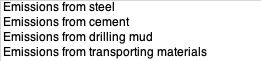

These will be considered in the following sections.

In general, the Brandt model takes the approach of calculating the total embodied emissions associated with the field, then linking this to the daily oil production rate (which is typically assumed to be constant over field life). This effectively spreads the lifecycle emissions evenly over the life of the field. This is not representative of the environmental impacts of these emissions, most of which will be released during offsite manufacturing of equipment (i.e. prior to the start of field life), with a portion associated with field abandonment being released close to the end of field life. The Brandt approach should be reviewed against a standard method for accounting for embodied emissions over time, if such a standard exists. This method means that embodied emissions are independent of flow rate and pressure (which decrease over field life), but equipment must be sized for the most demanding design case (i.e. typicall early field life with high pressure and flow).

## 4.1 Emissions from steel

Steel is used in several parts of the assumed development:
* Wellbore Construction (both for production and injection wells)
* Production & Surface Processing Facilities
* Ancilliary Structures (i.e. Tanks)
* Export Pipelines
* Gathering System Piping

### 4.1.1 Wellbore Construction Steel Emissions

OPGEE model parameterises well construction. In the absense of more specific design details, it defaults to 'moderate' assumptions, as shown below:

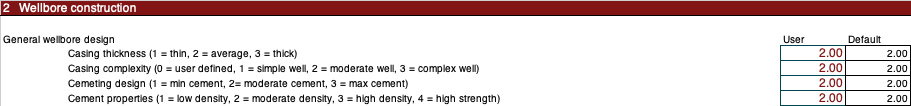

High-level casing design of the moderate well is as per image below. OPGEE quotes the source of this design as: Nguyen, J.P. Drilling (1996) Oil and Gas Field Development Techniques, p. 37 for Parentis oil field, modified to recognize OPGEE default.

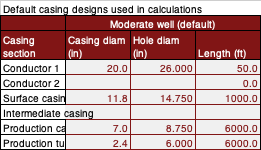

The OPGEE model then uses assumed masses of steel per unit length of casing and production tubing to ultimately calculate a total mass of steel per well.

For the "Shallow" sensitivity case (1500ft depth), assume top of well design is the same but that bottom of well is only at 1500 ft.

For the "Deep" sensitivity case (12,000ft depth), use a different well design from the same reference text book cited in the OPGEE model.

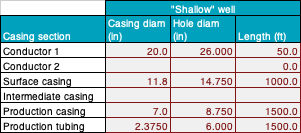 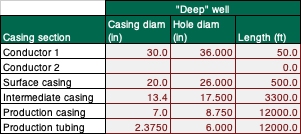

In [ ]:
#First calculate the steel requirements for the production wells (50x production wells is default assumption):

# Create dataframes for casing and tubing mass data taken from the OPGEE model, which indicates "Diameters from Mitchell and Miska (2011), Figure 7.18" and "Data from Mitchell, ed. (2006) Petroleum Engineering Handbook, Volume II: Drilling Engineering, Table 7.10"ArithmeticError"
casing_mass_lookup_data = {
    'Outside Diameter (in)': [
        4.500, 5.000, 5.500, 6.625, 7.000, 7.625, 8.625, 9.625, 
        10.750, 11.750, 13.375, 16.000, 18.625, 20.000, 30.000
    ],
    'Steel Casing Mass per Unit Length (lb/ft)': [
        11.28, 14.38, 17.08, 13.25, 27.50, 28.80, 36.14, 40.23,
        50.12, 48.20, 60.70, 77.60, 87.50, 94.00, 168.06
    ]
}
casing_mass_lookup = pd.DataFrame(casing_mass_lookup_data)
casing_mass_lookup.set_index('Outside Diameter (in)', inplace=True)

tubing_mass_lookup_data = {
    'Nominal Diameter (in)': [0.750, 1.000, 1.250, 1.500, 2.375, 2.875, 3.500, 4.000, 4.500],
    'Tubing Mass per Unit Length (lb/ft)': [1.14, 1.70, 2.30, 2.75, 4.90, 7.50, 10.20, 9.50, 12.60]
}
tubing_mass_lookup = pd.DataFrame(tubing_mass_lookup_data)
tubing_mass_lookup.set_index('Nominal Diameter (in)', inplace=True)

# Function to calculate mass of casing or tubing
def calculate_casing_or_tubing_mass(diameter, length, lookup_df):
    try:
        # Access the mass per unit length directly using the index and extracting the scalar value
        mass_per_unit_length = lookup_df.loc[diameter, lookup_df.columns[0]]
        # Calculate the total mass
        total_mass = mass_per_unit_length * length
        return total_mass
    except KeyError:
        raise ValueError("Error. Diameter is not included in the lookup table")

# Function to calculate steel mass for given case and sensitivity variables. The design of a well varies stepwise with depth, so these cases can be considered as sensitivity cases but cannot easily be included in a Monte Carlo uncertainty simulation.
def calculate_well_steel_mass_MC(case, sensitivity_variables=None):
    if case == 'Shallow': #This well design is a modified version of the baseline design detailed in the OPGEE model and taken from "J.P. Drilling (1996) Oil and Gas Field Development Techniques, p. 37 for Parentis oil field, modified to recognize OPGEE default."
        conductor_diameter = 20  # in
        conductor_length = 50  # ft
        surface_casing_diameter = 11.75  # in
        surface_casing_length = 1000  # ft
        production_casing_diameter = 7  # in
        production_casing_length = 1500  # ft
        production_tubing_diameter = 2.375  # in
        production_tubing_length = 1500  # ft
    elif case == 'Deep':
        conductor_diameter = 30  # in. This well design is a modified version of the Meillon-Pont d'As (gas) well design, which is also shown in "J.P. Drilling (1996) Oil and Gas Field Development Techniques, p. 37"
        conductor_length = 50  # ft
        surface_casing_diameter = 20  # in
        surface_casing_length = 5000  # ft
        intermediate_casing_diameter = 13.375  # in
        intermediate_casing_length = 3300  # ft
        production_casing_diameter = 7  # in
        production_casing_length = 12000  # ft
        production_tubing_diameter = 2.375  # in
        production_tubing_length = 12000  # ft
    else: #This is the default case. i.e. For "Baseline" and all other cases. It is taken directly from the OPGEE model, which states "Moderate well design is is from Nguyen, J.P. Drilling (1996) Oil and Gas Field Development Techniques, p. 37 for Parentis oil field, modified to recognize OPGEE default."
        conductor_diameter = 20 #in 
        conductor_length = 50 #ft
        surface_casing_diameter = 11.75 #in
        surface_casing_length = 1000 #ft
        production_casing_diameter = 7 #in
        production_casing_length = 6000 #ft
        production_tubing_diameter = 2.375 #in
        production_tubing_length = 6000 #ft

    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default

    # Now calculate the numbert of Injection Wells inferred by the number of production wells:
    number_injection_wells = math.ceil(0.25*number_production_wells) #Assumption is the number of injection wells is 25% of the number of production wells. Rounding up, as you can't drill a fraction of a well.
    # Now calculate the total number of wells in this sensitivity scenario:
    total_number_wells = number_production_wells + number_injection_wells 

    # Calculate masses based on the given dimensions
    conductor_mass = calculate_casing_or_tubing_mass(conductor_diameter, conductor_length, casing_mass_lookup)
    surface_casing_mass = calculate_casing_or_tubing_mass(surface_casing_diameter, surface_casing_length, casing_mass_lookup)
    production_casing_mass = calculate_casing_or_tubing_mass(production_casing_diameter, production_casing_length, casing_mass_lookup)
    production_tubing_mass = calculate_casing_or_tubing_mass(production_tubing_diameter, production_tubing_length, tubing_mass_lookup)

    if case == 'Deep':
        intermediate_casing_mass = calculate_casing_or_tubing_mass(intermediate_casing_diameter, intermediate_casing_length, casing_mass_lookup)
    else:
        intermediate_casing_mass = 0 # Because the Deep case is the only case with intermediate casing.

    # Sum up total mass for each production well and then calculate total mass for all production wells
    production_well_steel_mass_individual = (
        conductor_mass + surface_casing_mass + intermediate_casing_mass + production_casing_mass + production_tubing_mass
    )
    production_well_steel_mass_total = production_well_steel_mass_individual * number_production_wells

    # Assuming injection wells are the same as production wells, calculate the total steel mass for all wells
    total_steel_mass_all_wells = production_well_steel_mass_individual * total_number_wells  # This is the value if all wells are identical, regardless of production or injection.
    injection_well_steel_mass_brandt = production_well_steel_mass_total * 0.25 / 1.25  # This is the manner Brandt calculates injection well steel mass. The assumed number of injection wells differs here to elsewhere in the model (i.e. here is 20% but elsewhere is 25%)
    total_steel_mass_all_wells_brandt = production_well_steel_mass_total + injection_well_steel_mass_brandt

    return {
        'case': case,
        'production_well_steel_mass_total': production_well_steel_mass_total,
        'total_steel_mass_all_wells': total_steel_mass_all_wells,
        'total_steel_mass_all_wells_brandt': total_steel_mass_all_wells_brandt
    }

# # Example usage:
# sensitivity_variables = {
#     'number_production_wells': 50,
#     # 'total_number_wells': 100
# }
# result_shallow = calculate_well_steel_mass_MC('Shallow', sensitivity_variables)
# result_deep = calculate_well_steel_mass_MC('Deep', sensitivity_variables)

# print(result_shallow)
# print(result_deep)
# a = result_deep['production_well_steel_mass_total']
# b = result_shallow['production_well_steel_mass_total']
# print(a/b)


### 4.1.2 Production & Surface Processing Facilities Steel Emissions

This section estimates the quantity of steel, and its associated emissions, required for the following surface processing equipment items/sub-systems:
* Surface tubing
* Separators
* Gas sweetening equipment
* Gas dehydration equipment
* Gas compression equipment
* Gas separation via Pressure Swing Adsorption (PSA)

#### 4.1.2.1 Surface Tubing

Here, Brandt takes the OPGEE default values for the surface tubing, which are stated below. It assumes std weight tubing, based on a lookup table from  "Oilfield data handbook", Apex Distribution Inc.
Brandt assumes that tubing is only required for the production wells, not the injection wells. This is a curious assumption, as injection wells would also require tubing. Calculations for both just production wells and all wells are included below.

In [ ]:
# Calculate the steel required for surface tubing, as a function of case and sensitivity variables

def calculate_surface_tubing_steel_mass(case, sensitivity_variables=None):
    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default

    # Calculate the total number of wells in this sensitivity scenario
    number_injection_wells = math.ceil(0.25 * number_production_wells)  # Assumption is the number of injection wells is 25% of the number of production wells. Rounding up, as you can't drill a fraction of a well.
    total_number_wells = number_production_wells + number_injection_wells

    # Define the surface tubing dimensions and properties
    surface_tubing_avg_diameter = 2.00  # in
    surface_tubing_strength_class = 'std'
    surface_tubing_weight_per_ft = 3.653  # lb/ft
    surface_tubing_avg_length_per_well = 250  # ft/well

    # Calculate the total mass of surface tubing for all wells
    surface_tubing_total_mass_all_wells = surface_tubing_weight_per_ft * surface_tubing_avg_length_per_well * total_number_wells  # lb
    surface_tubing_total_mass_brandt = surface_tubing_weight_per_ft * surface_tubing_avg_length_per_well * number_production_wells  # lb

    return {
        'case': case,
        'surface_tubing_total_mass_all_wells': surface_tubing_total_mass_all_wells,
        'surface_tubing_total_mass_brandt': surface_tubing_total_mass_brandt
    }

# Example usage:
sensitivity_variables = {
    'number_production_wells': 50,
    # 'total_number_wells': 100
}
result_surface_tubing = calculate_surface_tubing_steel_mass('Baseline', sensitivity_variables)
print(result_surface_tubing)


# surface_tubing_avg_diameter = 2.00 #in
# surface_tubing_strength_class = 'std'
# surface_tubing_weight_per_ft = 3.653 #lb/ft
# surface_tubing_avg_length_per_well = 250 #ft/well
# surface_tubing_total_mass_all_wells = surface_tubing_weight_per_ft * surface_tubing_avg_length_per_well * total_number_wells #lb
# surface_tubing_total_mass_brandt = surface_tubing_weight_per_ft * surface_tubing_avg_length_per_well * number_production_wells #lb

# print("Mass of surface tubing assuming all wells:", surface_tubing_total_mass_all_wells, "lb")
# print("Mass of surface tubing per Brandt:", surface_tubing_total_mass_brandt, "lb")



{'case': 'Baseline', 'surface_tubing_total_mass_all_wells': 57534.75, 'surface_tubing_total_mass_brandt': 45662.5}


#### 4.1.2.2 Separator(s)

The OPGEE model includes a simple look-up table for separator sizing and throughput based on inlet pressure (From http://www.surfaceequip.com/two-three-phase-vertical-horizontal-separators-gas-scrubbers.html, accessed April 21, 2014) and assumes that it is cheapest to buy a smaller number of larger separators.

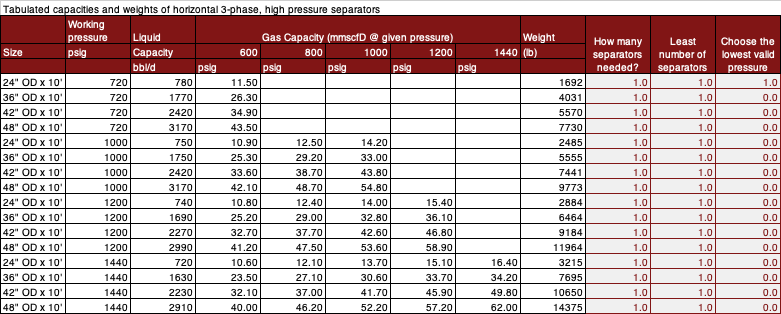

Brandt assumes the smallest separator is installed, despite the pressure at start-of-field-life exceeding the stated working pressure of the 'default' separator. In reality, with such a small volume of produced liquid (relative to gas), it may be that a horizontal separator is not effective in achieving two-phase (i.e. liquid vs gas) separation, let alone three-phase separation (i.e. gas, water & oil).

For the time being, I will retain Brandt's assumption of a single separator of the smallest size provided in the OPGEE default table (noting the provided reference is now defunct).

In [ ]:
separator_nominal_weight = 1692 #lb. As noted above, this is taken directly from the OPGEE model.
separator_multiplier_additional_material = 1.5
separator_total_weight = separator_nominal_weight * separator_multiplier_additional_material #lb

print(separator_total_weight)

2538.0


#### 4.1.2.3 Gas sweetening equipment

Gas sweetening (aka acid gas removal, AGR) equipment is that which strips 'sour' CO2 and H2S from the product gas stream. 

Design operates assuming that pressure entering the sub-system is controlled to operating pressure of 500psi. 

Brandt's analysis adopts the default design assumptions for an AGR unit, as shown below:

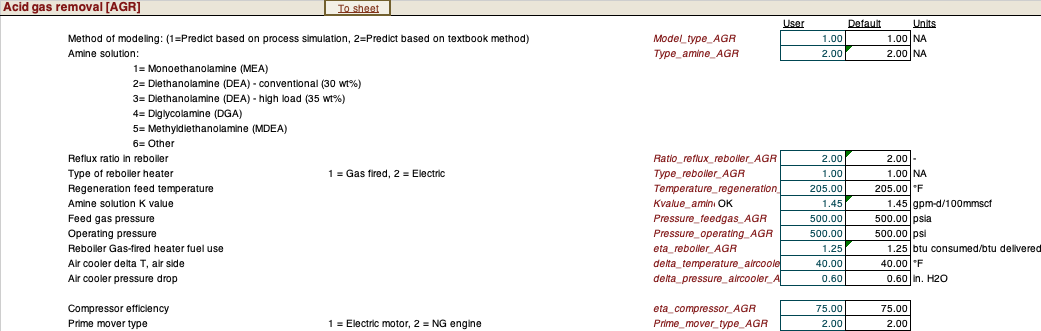

In [ ]:
#First define a function to calculate absorber inner diameter based on the logic in OPGEE, which cites data from Manning and Thompson (1991), derived from Khan and Manning (1985).

def calculate_absorber_inner_diameter(pressure, gas_flow_rate):
    if pressure <= 200:
        return 12.259 * gas_flow_rate ** 0.4932
    elif 200 < pressure <= 500:
        return 12.259 * gas_flow_rate ** 0.4932
    elif 500 < pressure <= 1000:
        return 8.6115 * gas_flow_rate ** 0.479
    elif 1000 < pressure <= 1500:
        return 8.6115 * gas_flow_rate ** 0.479
    else:
        raise ValueError("Pressure cannot be greater than 1500 psig")
    
#Now call the function to return the absorber inner diameter for this case:

absorber_operating_pressure = 500 #psig. The OPGEE model assumes pressure is controlled to this point.
absorber_height = 30 #ft. Assumed height of absorber. This is a default assumption in the OPGEE model.
absorber_shell_thickness = 0.5 #in. Assumed thickness of absorber shell. This is a default assumption in the OPGEE model.
absorber_shell_steel_density = 20.4 #lb/ft^2 for 0.5 in thick steel. Assumed density of steel for absorber shell. This is a default assumption in the OPGEE model.

#It is not clear if Brandt assumes maximum or minimum gas flow rate for this calculation, so both are calculated here.
max_gas_flow_rate = max(production_profile_df['Baseline Raw Gas Rate, MSCFD']) / 1000 #MMSCFD
min_gas_flow_rate = min(production_profile_df['Baseline Raw Gas Rate, MSCFD']) / 1000 #MMSCFD
print("Maximum Gas Flow Rate:", max_gas_flow_rate)
print("Minimum Gas Flow Rate:", min_gas_flow_rate)

absorber_inner_diameter_max_gas_flow = calculate_absorber_inner_diameter(absorber_operating_pressure, max_gas_flow_rate)
absorber_inner_diameter_min_gas_flow = calculate_absorber_inner_diameter(absorber_operating_pressure, min_gas_flow_rate)

print("Absorber Inner Diameter based on max gas flow rate:", absorber_inner_diameter_max_gas_flow, "in")
print("Absorber Inner Diameter based on min gas flow rate:", absorber_inner_diameter_min_gas_flow, "in")

absorber_shell_area = math.pi * absorber_inner_diameter_min_gas_flow/12 * absorber_height + 2*math.pi * (absorber_inner_diameter_min_gas_flow/12/2)**2#ft^2. This is the surface area of the absorber shell, assuming a cylindrical shape with flat ends. Would be more appropriate/realistic to assume elliptical or hemispherical ends.
absorber_shell_mass = absorber_shell_area * absorber_shell_steel_density #lb. This is the mass of steel required to construct the absorber shell.
absorber_aux_mass = absorber_shell_mass #lb. OPGEE assumes that mass of trays, aux piping etc. is equal to the mass of the absorber shell.
absorber_mass = absorber_shell_mass + absorber_aux_mass #lb. This is the total mass of the absorber unit.
desorber_mass = absorber_shell_mass + absorber_aux_mass #lb. This is the total mass of the desorber unit, assumed to be identical to the absorber unit.
ancilliary_materials_factor_absorber = 2 #Assumed factor for ancilliary materials. Default assumption in OPGEE model. i.e. Additional steel mass is twice the mass of that associated with absorber/desorbers.
gas_sweetening_equip_total_mass = (absorber_mass + desorber_mass) * ancilliary_materials_factor_absorber #lb. This is the total mass of the gas sweetening equipment.
print(gas_sweetening_equip_total_mass)

Maximum Gas Flow Rate: 23.1
Minimum Gas Flow Rate: 2.8503209767800843
Absorber Inner Diameter based on max gas flow rate: 57.675115581838114 in
Absorber Inner Diameter based on min gas flow rate: 20.54984979851527 in
27091.96397574401


#### 4.1.2.4 Gas dehydration equipment

OPGEE model assumes that glycol (TEG) dehydration is used to remove water from the product gas stream. OPGEE defaults are used, as per image below:

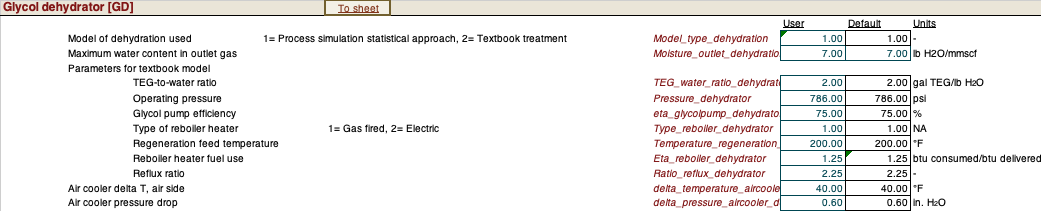

In [ ]:
contactor_operating_pressure = absorber_operating_pressure # 500 psig. The OPGEE model assumes pressure is controlled to this point.

#Define a the lookup table used to size the contactor. Notes as to the source of this data are in the OPGEE model.

data = {
    'Pressure (psig)': [400]*13 + [600]*13 + [800]*13 + [1000]*13 + [1200]*13,
    'Throughput (mmscf/d)': [0.0, 3.1, 4.6, 6.8, 14.3, 16.8, 23.4, 25.5, 34.4, 43.6, 53.0, 61.1, 77.4,
                             0.0, 3.7, 5.8, 8.2, 17.5, 20.6, 28.7, 31.2, 42.1, 53.5, 65.3, 79.5, 93.8,
                             0.0, 4.1, 6.6, 9.5, 20.6, 24.0, 33.5, 36.4, 49.2, 62.2, 76.0, 93.0, 110.1,
                             0.0, 4.6, 7.2, 10.4, 23.2, 26.9, 37.7, 41.0, 55.4, 70.1, 86.1, 98.6, 124.9,
                             0.0, 5.0, 7.9, 11.3, 25.5, 29.9, 42.5, 45.8, 61.0, 77.7, 96.0, 108.4, 137.6],
    'OD (in.)': [16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 42.8, 48.8, 54.9, 61.0, 67.1, 73.2, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.0, 49.2, 55.3, 61.4, 67.5, 73.6, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.3, 49.5, 55.6, 61.8, 67.9, 74.1, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.6, 49.8, 56.0, 62.2, 68.4, 74.6, 'NA',
                 16.0, 20.0, 24.0, 30.0, 36.0, 42.0, 43.8, 50.1, 56.3, 62.6, 68.8, 75.0, 'NA'],
    'ID (in.)': [15.6, 19.5, 23.5, 29.4, 35.3, 41.2, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.5, 19.4, 23.3, 29.2, 35.1, 41.0, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.4, 19.3, 23.2, 29.0, 34.8, 40.7, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.3, 19.1, 23.0, 28.8, 34.6, 40.4, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA',
                 15.2, 19.0, 22.9, 28.6, 34.4, 40.2, 42.0, 48.0, 54.0, 60.0, 66.0, 72.0, 'NA'],
    'Height (ft.)': [15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA',
                     15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30, 'NA'],
    'Estimated thickness': [0.4, 0.4, 0.5, 0.5, 0.6, 0.7, 0.7, 0.8, 0.9, 0.9, 1.0, 1.1, 'NA',
                            0.5, 0.5, 0.6, 0.7, 0.9, 1.0, 1.0, 1.1, 1.2, 1.3, 1.5, 1.6, 'NA',
                            0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.3, 1.4, 1.6, 1.7, 1.9, 2.1, 'NA',
                            0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 'NA',
                            0.8, 0.9, 1.1, 1.3, 1.6, 1.8, 1.8, 2.0, 2.3, 2.5, 2.7, 3.0, 'NA'],
    'Rounded thickness': [0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.8, 0.8, 0.9, 1.0, 1.1, 1.2, 'NA',
                          0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.0, 1.2, 1.3, 1.4, 1.5, 1.6, 'NA',
                          0.6, 0.7, 0.8, 1.0, 1.2, 1.3, 1.3, 1.5, 1.6, 1.8, 1.9, 2.1, 'NA',
                          0.7, 0.9, 1.0, 1.2, 1.4, 1.6, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 'NA',
                          0.8, 1.0, 1.1, 1.4, 1.6, 1.8, 1.8, 2.1, 2.3, 2.6, 2.8, 3.0, 'NA']
}

# Create the DataFrame
contactor_sizing_lookup = pd.DataFrame(data)



In [ ]:
def find_contactor_sizing(gas_flow_rate, operating_pressure):
    """
    Retrieve the contactor sizing information based on gas flow rate and the closest available pressure that is
    greater than or equal to the specified operating pressure.

    Parameters:
    gas_flow_rate (float): The gas flow rate in mmscf/d.
    operating_pressure (int): The operating pressure in psig.

    Returns:
    tuple: Returns a tuple containing the ID, OD, height, and rounded thickness, or a message if no match is found.
    """
    # Filter DataFrame to find the minimum pressure that is greater than or equal to the specified operating pressure
    available_pressures = contactor_sizing_lookup['Pressure (psig)'].unique()
    # Find pressures greater than or equal to the operating_pressure and take the minimum of those
    possible_pressures = available_pressures[available_pressures >= operating_pressure]
    if possible_pressures.size == 0:
        return "No available pressure equal to or greater than the specified pressure."

    closest_pressure = possible_pressures.min()

    # Filter the DataFrame for the closest pressure found
    pressure_match = contactor_sizing_lookup[contactor_sizing_lookup['Pressure (psig)'] == closest_pressure]

    # Find the row with the closest throughput that is greater than or equal to the given gas flow rate
    throughput_match = pressure_match[pressure_match['Throughput (mmscf/d)'] >= gas_flow_rate].sort_values(by='Throughput (mmscf/d)')
    if throughput_match.empty:
        return "No throughput available that matches or exceeds the specified flow rate."

    # Take the closest match based on throughput
    closest_match = throughput_match.iloc[0]

    # Extract the relevant columns
    id_diameter = closest_match['ID (in.)']
    od_diameter = closest_match['OD (in.)']
    height = closest_match['Height (ft.)']
    rounded_thickness = closest_match['Rounded thickness']

    return (id_diameter, od_diameter, height, rounded_thickness)

# Example usage:
contactor_sizing_results = find_contactor_sizing(min_gas_flow_rate, contactor_operating_pressure)
print("ID, OD, Height, Rounded Thickness:", contactor_sizing_results)

contactor_ID = contactor_sizing_results[0]
contactor_OD = contactor_sizing_results[1]
contactor_height = contactor_sizing_results[2]
contactor_thickness = contactor_sizing_results[3]

contactor_shell_volume = math.pi * ((contactor_OD/2)**2 - (contactor_ID/2)**2) * contactor_height * 12 + 2 * math.pi * (contactor_OD/2)**2 * contactor_thickness #in^3. This is the volume of the contactor shell, assuming a cylindrical shape with flat ends. 
# Would be more appropriate/realistic to assume elliptical or hemispherical ends. Note the formula in the OPGEE model for this is incorrect, as it does not include pi in the area of cylinder calculation, nor does it account for any end coverings.
print("Shell Volume:", contactor_shell_volume)
contactor_shell_mass = contactor_shell_volume * steel_density #lb. This is the mass of steel required to construct the contactor shell.

contactor_aux_mass = contactor_shell_mass #lb. OPGEE assumes that mass of trays, aux piping etc. is equal to the mass of the contactor shell. 
ancilliary_materials_factor_contactor = 2 #Assumed factor for ancilliary materials. Default assumption in OPGEE model. i.e. Additional steel mass is twice the mass of that associated with contactor.

dehydration_equip_total_mass = (contactor_shell_mass + contactor_aux_mass) * ancilliary_materials_factor_contactor #lb. This is the total mass of the dehydration equipment.
print('Total mass of dehydration equipment:', dehydration_equip_total_mass,'lb')


ID, OD, Height, Rounded Thickness: (19.4, 20.0, 15, 0.6)
Shell Volume: 3719.0173833196036
Total mass of dehydration equipment: 4462.820859983524 lb


#### 4.1.2.5 Gas reinjection compressor

Brandt assumes that all waste gas is re-injected into the subsurface.

"From relationship for centrifugal compressors from MS thesis of Y. Sun 2015.  Relationship is M = 2887 + 0.7820*Qg, where M is mass of compressor in kg, and Qg is gas flow rate in m3/hr.  Conversion factor of 0.85 is used to convert from mscf/d to m3/hr."

In [ ]:
gas_injection_volume = 0.666295945746444 #mscf/d. This is the volume of gas injected. OPGEE calculates this based on assumed reservoir/injection pressure, process pressure, and uses a
#model of adiabatic compression. Adding these calculations is a future improvement to this model.
gas_injection_compressor_mass = (2887 + 0.7820/0.85 * gas_injection_volume) / 0.454 #lb. This is the mass of the gas injection compressor, as calculated in the OPGEE model. 
# Conversion factor of 0.85 is used to convert from mscf/d to m3/hr. 0.454 converts from kg to lb.
gas_injection_aux_mass_factor = 2 #Assumed factor for ancilliary materials. Default assumption in OPGEE model. i.e. Additional steel mass is twice the mass of that associated with gas injection compressor.
gas_injection_total_mass = gas_injection_compressor_mass * gas_injection_aux_mass_factor #lb
print('Total mass of gas injection equipment:', gas_injection_total_mass,'lb')

Total mass of gas injection equipment: 12720.762080484963 lb


#### 4.1.2.6 Gas separation by Pressure Swing Adsorption (PSA)

According to Brandt, PSA is considered standard technology for gas separation in hydrogen production. PSA is not included in the default OPGEE model, so Brandt just assumes a multiple of separator mass.

In [ ]:
PSA_unit_mass = separator_total_weight * 5 #lb. This is the mass of the PSA unit, as calculated in the OPGEE model.
print('Total mass of PSA unit:', PSA_unit_mass,'lb')

Total mass of PSA unit: 12690.0 lb


### 4.1.3 Ancilliary Structures Steel Emissions

The OPGEE defaults for "ancilliary structures and construction" include only steel tanks for oil and produced water storage. Produced water storage is excluded in the hydrogen study. The default assumptions call for 3000 bbl of total oil storage capacity, provided by 4off tanks.

In [ ]:
mass_steel_tanks = 63079.0964136334 #lb. The OPGEE model does not link this calculation to any inputs, so this is taken directly from the model and will not change between scenarios.

### 4.1.4 Export Pipelines Steel Emissions

Brandt's analysis states "Because we do not know the type of pipeline network that crude will be transported over, we compute the steel intensity of crude transport for the entire US pipeline system". It calculates "bbl oil transported per lb of steel" for the total US system then divides the total volume of assumed oil production from the hydrogen field by this ratio to estimate the transport infrastructure attributable to this development.

In [ ]:
mass_us_pipelines = 74484864000 #lb. This is not linked to any inputs so is taken directly from the OPGEE model.
mass_us_pipelines_ancilliary = 0.5 * mass_us_pipelines #lb. This is the mass of ancilliary equipment associated with the pipeline system, as calculated in the OPGEE model.
total_us_pipeline_system_mass = mass_us_pipelines + mass_us_pipelines_ancilliary #lb. This is the total mass of the US pipeline system, as calculated in the OPGEE model.
total_crude_transported_by_us_pipelines = 109500 #MMbbl/pipe_lifetime. This is the total crude oil transported by the US pipeline system over its lifetime, as calculated in the OPGEE model.
crude_transported_per_steel_mass = total_crude_transported_by_us_pipelines / (total_us_pipeline_system_mass/1E6) #MMbbl/lb. This is the total crude oil transported per lb of steel in the US pipeline system, as calculated in the OPGEE model.

print('Crude transported per lb of steel in US pipeline system:', crude_transported_per_steel_mass, 'MMbbl/lb')

# total_oil_production = oil_production_default * 365 * field_lifespan #bbl. This is the total oil production over the lifetime of the field.

# export_pipeline_steel_mass = total_oil_production / crude_transported_per_steel_mass #lb. This is the mass of steel required for the export pipeline, as calculated in the OPGEE model.

# print('Estimated mass of steel required for export pipeline:', export_pipeline_steel_mass, 'lb')

# Define a function that calculates the export pipeline steel mass based on varying oil production assumption rates. Also takes case into account, but assumption of case does not affect assumption of oil production rate.
def calculate_export_pipeline_steel_mass(case, sensitivity_variables=None):
    if sensitivity_variables:
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
    else:
        oil_production = oil_production_default
        field_lifespan = field_lifespan_default
 
    total_oil_production = oil_production * 365 * field_lifespan  # bbl. This is the total oil production over the lifetime of the field.

    # Calculate export pipeline steel mass
    export_pipeline_steel_mass = total_oil_production / crude_transported_per_steel_mass  # lb

    return {
        'case': case,
        'total_oil_production': total_oil_production,
        'export_pipeline_steel_mass': export_pipeline_steel_mass
    }

# # Example usage
# sensitivity_variables = {
#     'oil_production': 0.1,  # bbl/day
# }

# result = calculate_export_pipeline_steel_mass('Baseline', sensitivity_variables)
# print(result)


Crude transported per lb of steel in US pipeline system: 0.9800648894250515 MMbbl/lb


### 4.1.5 Gathering System Piping Steel Emissions

The OPGEE model calculates the mass of steel required for the average US natural gas well gathering line piping and multiplies this by the number of wells under consideration.

In [ ]:
# Define a function that calculates the total mass of steel required for the gathering system, based on the number of wells and the mass of steel required per well, by case and sensitivity variables.

def calculate_gathering_system_steel_mass(case, sensitivity_variables=None):
    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default

    # Calculate the total number of wells in this sensitivity scenario
    number_injection_wells = math.ceil(0.25 * number_production_wells)  # Assumption is the number of injection wells is 25% of the number of production wells. Rounding up, as you can't drill a fraction of a well.
    total_number_wells = number_production_wells + number_injection_wells

    gathering_system_steel_per_well = 13779.116 #lb/well. This figure is calculated in OPGEE but is not dependent on any inputs, so is taken directly from the model.
    total_gathering_system_steel_mass = gathering_system_steel_per_well * total_number_wells #lb. This is the total mass of steel required for the gathering system, as calculated in the OPGEE model.

    return {
        'case': case,
        'total_gathering_system_steel_mass': total_gathering_system_steel_mass #This differs from Brandt's calculation because the OPGEE model does not include gas re-injection wells in the calculation.
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 100,
# }

# result = calculate_gathering_system_steel_mass('Baseline', sensitivity_variables)
# print(result)


# print('Total mass of steel required for gathering system:', total_gathering_system_steel_mass, 'lb') 

### 4.1.6 Total Emissions from Steel

Summing the mass of steel and multiplying by assumed carbon intensity

In [ ]:
def calculate_total_steel_mass(case, sensitivity_variables):
    
    # Calculate total steel mass for wells
    # well_steel_mass = calculate_well_steel_mass_MC(case, sensitivity_variables)
    export_pipeline_steel_mass = calculate_export_pipeline_steel_mass(case, sensitivity_variables)['export_pipeline_steel_mass']
    total_steel_mass_all_wells = calculate_well_steel_mass_MC(case,sensitivity_variables)['total_steel_mass_all_wells']
    surface_tubing_total_mass_all_wells = calculate_surface_tubing_steel_mass(case, sensitivity_variables)['surface_tubing_total_mass_all_wells']
    total_gathering_system_steel_mass = calculate_gathering_system_steel_mass(case, sensitivity_variables)['total_gathering_system_steel_mass']

    # Calculate total steel mass
    total_steel_mass = (total_steel_mass_all_wells +
                        surface_tubing_total_mass_all_wells +
                        separator_total_weight +
                        gas_sweetening_equip_total_mass +
                        dehydration_equip_total_mass +
                        gas_injection_total_mass +
                        PSA_unit_mass +
                        mass_steel_tanks +
                        export_pipeline_steel_mass +
                        total_gathering_system_steel_mass)
    return {
        'case': case,
        'total_steel_mass': total_steel_mass,
    }

def calculate_total_steel_emissions_MC(case, sensitivity_variables):
   
    total_emissions_steel = calculate_total_steel_mass(case, sensitivity_variables)['total_steel_mass'] * steel_emissions_intensity  # gCO2
    brandt_emissions = 1.96291E+10  # Reference emissions from Brandt
    percent_difference = (total_emissions_steel - brandt_emissions) / brandt_emissions * 100

    return {
        'case': case,
        'total_emissions_steel': total_emissions_steel,
        'percent_difference_from_brandt': percent_difference
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50,
#     'oil_production': 0.10,  # bbl/day  

# }

# mass_baseline = calculate_total_steel_mass('Baseline', sensitivity_variables)
# mass_shallow = calculate_total_steel_mass('Shallow', sensitivity_variables)
# mass_deep = calculate_total_steel_mass('Deep', sensitivity_variables)

# emissions_baseline = calculate_total_steel_emissions_MC('Baseline', sensitivity_variables)
# emissions_shallow = calculate_total_steel_emissions_MC('Shallow', sensitivity_variables)
# emissions_deep = calculate_total_steel_emissions_MC('Deep', sensitivity_variables)

# print(mass_baseline)
# print(mass_shallow)
# print(mass_deep)

# print(emissions_baseline)
# print(emissions_shallow)
# print(emissions_deep)


## 4.2 Emissions from cement

Cement is used in several parts of the assumed development/facilities, including:

* Production & Injection Wells
* Wellbore Plugs (at Field Abandonment)

### 4.2.1 Production & Injection Well Cement Emissions

Section 4.1.1 outlines the design of the "moderate" complexity well assumed by Brandt. This section calculates the volume of cement required for these well, such that associated emissions can be inferred.

In [ ]:
#As with the calculation of the amount of steel associated with wells, the amount of cement is also dependent on the well design, so only 3 scenarios are considered as sensitivity cases.

def calculate_cement_volume_mass(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables:
        sensitivity_variables = {}
    else:
        sensitivity_variables = {}

    # Define parameters for each case
    parameters = {
        'Baseline': {
            'conductor_hole_diameter': 26,
            'surface_casing_hole_diameter': 14.75,
            'production_casing_hole_diameter': 8.75,
            'production_tubing_hole_diameter': 6.0,
            'conductor_diameter': 20,
            'conductor_length': 50,
            'surface_casing_diameter': 11.75,
            'surface_casing_length': 1000,
            'production_casing_diameter': 7,
            'production_casing_length': 6000,
            'production_tubing_diameter': 2.375,
            'production_tubing_length': 6000
        },
        'Shallow': {
            'conductor_hole_diameter': 26,
            'surface_casing_hole_diameter': 14.75,
            'production_casing_hole_diameter': 8.75,
            'production_tubing_hole_diameter': 6.0,
            'conductor_diameter': 20,
            'conductor_length': 50,
            'surface_casing_diameter': 11.75,
            'surface_casing_length': 1000,
            'production_casing_diameter': 7,
            'production_casing_length': 1500,
            'production_tubing_diameter': 2.375,
            'production_tubing_length': 1500
        },
        'Deep': {
            'conductor_hole_diameter': 36,
            'surface_casing_hole_diameter': 26,
            'intermediate_casing_hole_diameter': 17.5,
            'production_casing_hole_diameter': 8.75,
            'production_tubing_hole_diameter': 6.0,
            'conductor_diameter': 30,
            'conductor_length': 50,
            'surface_casing_diameter': 20,
            'surface_casing_length': 5000,
            'intermediate_casing_diameter': 13.375,
            'intermediate_casing_length': 3300,
            'production_casing_diameter': 7,
            'production_casing_length': 12000,
            'production_tubing_diameter': 2.375,
            'production_tubing_length': 12000
        }
    }

    # Select parameters based on the case
    case_parameters = parameters.get(case, parameters['Baseline'])

    # Override parameters with sensitivity variables if provided
    for key in case_parameters.keys():
        if key in sensitivity_variables:
            case_parameters[key] = sensitivity_variables[key]

    bentonite_density = 14.4775342369801 * 7.48  # lb/ft^3. This is the density of bentonite slurry, as calculated in the OPGEE model. Conversion factor of 7.48 is used to convert from lb/gal to lb/ft^3.
    cement_excess_factor = 1.75  # Assumed factor to account for drilling enlargement and cement infiltration. Default assumption in OPGEE model.

    # Calculate void volumes
    conductor_void_volume = math.pi * ((case_parameters['conductor_hole_diameter'] / 2 / 12) ** 2 - (case_parameters['conductor_diameter'] / 2 / 12) ** 2) * case_parameters['conductor_length'] * cement_excess_factor  # ft^3
    surface_casing_void_volume = math.pi * ((case_parameters['surface_casing_hole_diameter'] / 2 / 12) ** 2 - (case_parameters['surface_casing_diameter'] / 2 / 12) ** 2) * case_parameters['surface_casing_length'] * cement_excess_factor  # ft^3
    production_casing_void_volume = math.pi * ((case_parameters['production_casing_hole_diameter'] / 2 / 12) ** 2 - (case_parameters['production_casing_diameter'] / 2 / 12) ** 2) * min(case_parameters['production_casing_length'], 600) * cement_excess_factor  # ft^3

    if case == 'Deep':
        intermediate_casing_void_volume = math.pi * ((case_parameters['intermediate_casing_hole_diameter'] / 2 / 12) ** 2 - (case_parameters['intermediate_casing_diameter'] / 2 / 12) ** 2) * min(case_parameters['intermediate_casing_length'], 600) * cement_excess_factor  # ft^3
    else:
        intermediate_casing_void_volume = 0


    #Calculate the total number of wells based on the sensitivity variable
    number_production_wells = sensitivity_variables.get('number_production_wells',50) #Retreive the number of production wells from the sensitivity variables, otherwise default to 50.
    number_injection_wells = math.ceil(number_production_wells * 0.25)
    total_number_wells = number_production_wells + number_injection_wells

    # Calculate total volumes
    cement_volume_per_well = conductor_void_volume + surface_casing_void_volume + intermediate_casing_void_volume + production_casing_void_volume  # ft^3
    total_well_cement_volume = cement_volume_per_well * total_number_wells  # ft^3
    total_well_cement_mass = total_well_cement_volume * bentonite_density  # lb

    return {
        'case': case,
        'conductor_void_volume': conductor_void_volume,
        'surface_casing_void_volume': surface_casing_void_volume,
        'intermediate_casing_void_volume': intermediate_casing_void_volume,
        'production_casing_void_volume': production_casing_void_volume,
        'cement_volume_per_well': cement_volume_per_well,
        'total_well_cement_volume': total_well_cement_volume,
        'total_well_cement_mass': total_well_cement_mass
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50  # Example sensitivity variable
# }

# shallow_cement_volumes = calculate_cement_volume_mass('Shallow', sensitivity_variables)
# baseline_cement_volumes = calculate_cement_volume_mass('Baseline', sensitivity_variables)
# deep_cement_volumes = calculate_cement_volume_mass('Deep', sensitivity_variables)

# print(shallow_cement_volumes)
# print(baseline_cement_volumes)
# print(deep_cement_volumes)




### 4.2.2 Wellbore Plug Cement Emissions

The calculation considers the volume of cement required to safely 'plug' and abandon the wells at the end of field life. 

In [ ]:
# Define a function that calculates the wellbore plug mass and volume based on varying sensitivity variables:

def calculate_wellbore_plug_mass_and_volume(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default

    # Define bentonite density
    bentonite_density = 14.4775342369801 * 7.48  # lb/ft^3. Conversion factor of 7.48 is used to convert from lb/gal to lb/ft^3.

    # Define parameters
    wellbore_plug_length = 321  # ft. Default length of a wellbore plug in the OPGEE model.
    production_casing_diameter = 7  # in. We assume in this version of the model that all cases (regardless of shallow, baseline or deep) have the same production casing diameter. Brandt does not include the assumptions of different casing diameters in his model.

    # Calculate wellbore plug volume and mass
    wellbore_plug_diameter = production_casing_diameter  # in. Default diameter of a wellbore plug in the OPGEE model.
    wellbore_plug_volume = math.pi * (wellbore_plug_diameter / 2 / 12) ** 2 * wellbore_plug_length  # ft^3
    wellbore_plug_mass = wellbore_plug_volume * bentonite_density  # lb

    # Get number of production wells from sensitivity variables or use default
    number_production_wells = sensitivity_variables.get('number_production_wells', 50)  # Default is 50 production wells
    number_injection_wells = number_production_wells * 0.25 / 1.25  # Calculation based on Brandt's assumption
    total_number_wells = number_production_wells + number_injection_wells

    # Calculate total wellbore plug mass and volume
    total_wellbore_plug_mass = wellbore_plug_mass * total_number_wells  # lb
    total_wellbore_plug_volume = wellbore_plug_volume * total_number_wells  # ft^3

    return {
        'case': case,
        'wellbore_plug_volume': wellbore_plug_volume,
        'wellbore_plug_mass': wellbore_plug_mass,
        'total_wellbore_plug_mass': total_wellbore_plug_mass,
        'total_wellbore_plug_volume': total_wellbore_plug_volume
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50  # Example sensitivity variable
# }

# wellbore_plug_results = calculate_wellbore_plug_mass_and_volume('Deep', sensitivity_variables)
# print(wellbore_plug_results)


### 4.2.3 Total Emissions from Cement

Summing the mass of cement and multiplying by emissions intensity:

In [ ]:
# Now define a function to calculate total cement emissions based on case and varying sensitivity variables:

def calculate_total_cement_emissions(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default

    # Calculate cement volumes and masses
    cement_volumes = calculate_cement_volume_mass(case, sensitivity_variables)
    wellbore_plug_results = calculate_wellbore_plug_mass_and_volume(case, sensitivity_variables)

    # Calculate total cement emissions
    total_cement_emissions = (cement_volumes['total_well_cement_volume'] + wellbore_plug_results['total_wellbore_plug_volume']) * cement_emissions_intensity  # gCO2

    return {
        'case': case,
        'total_cement_emissions': total_cement_emissions
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50  # Example sensitivity variable
# }

# cement_emissions_baseline = calculate_total_cement_emissions('Baseline', sensitivity_variables)
# cement_emissions_shallow = calculate_total_cement_emissions('Shallow', sensitivity_variables)
# cement_emissions_deep = calculate_total_cement_emissions('Deep', sensitivity_variables)

# print(cement_emissions_baseline)
# print(cement_emissions_shallow)
# print(cement_emissions_deep)



# cement_emissions_difference = (total_cement_emissions - 2304599426.49053) / 2304599426.49053 * 100    
# print(f'Cement emissions: Percent difference from Brandt: {cement_emissions_difference:.2f}%')

## 4.3 Emissions from drilling mud

Calculates the embodied emissions associated with the drilling mud that is required to drill the production and injection wells. Note Brandt assumes hydrogen wells will fit the "medium" classification of all relevant categories.

In [ ]:
max_volume_mud_required_multiple = 1 #This is a multiple of the full wellbore volume. Note in OPGEE reads "While wellbore will be partially filled with drillstring, we assume that the maximum mud volume required is equal to total wellbore volume due to mud infiltration and mud tank volumes"
mud_density = 14.0203703703704 #lb/gal of drilling fluid. Assumes "medium mud type". OPGEE calculates this figure based on the density of water, bentonite, and barite, and the volume of each in the drilling fluid.
bentonite_mud_density = 2.00925925925926 #lb/gal of bentonite. OPGEE calculates this figure based on the density of bentonite and the volume of bentonite in the drilling fluid.
bentonite_emissions_intensity = 31.471592226739 / 2.204 #gCO2/lb. This is the emissions intensity of bentonite production, as calculated in the OPGEE model. Conversion factor of 2.204 is used to convert from kg to lb.
barite_mud_density = 5.83333333333333 #lb/gal of barite. OPGEE calculates this figure based on the density of barite and the volume of barite in the drilling fluid.
barite_emissions_intensity = 282.458033501317 / 2.204 #gCO2/lb. This is the emissions intensity of barite production, as calculated in the OPGEE model. Conversion factor of 2.204 is used to convert from kg to lb.

cubic_feet_per_gallon = 0.133681 #ft^3/gal. This is the conversion factor from gallons to cubic feet
gallons_per_cubic_foot = 1 / cubic_feet_per_gallon #gal/ft^3. This is the conversion factor from cubic feet to gallons

# Define a function to calculate the total emissions associated with drilling mud use based on case and varying sensitivity variables:
# Drilling mud calculation uses hole diameter, as the drilling mud sits above the drill bit as it drills, thus the mud must fill the full void.
def calculate_drilling_mud_emissions(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default

    #Calculate the number of each type of well, based on the sensitivity variable:
    number_injection_wells = math.ceil(number_production_wells * 0.25)
    total_number_wells = number_production_wells + number_injection_wells

    # Define parameters
    parameters = {
        'Baseline': {
            'conductor_hole_diameter': 26,
            'surface_casing_hole_diameter': 14.75,
            'production_casing_hole_diameter': 8.75,
            'production_casing_length': 6000,
            'conductor_length': 50,
            'surface_casing_length': 1000,
            'production_casing_length': 6000
        },
        'Shallow': {
            'conductor_hole_diameter': 26,
            'surface_casing_hole_diameter': 14.75,
            'production_casing_hole_diameter': 8.75,
            'production_casing_length': 1500,
            'conductor_length': 50,
            'surface_casing_length': 1000,
            'production_casing_length': 1500
        },
        'Deep': {
            'conductor_hole_diameter': 36,
            'surface_casing_hole_diameter': 26,
            'intermediate_casing_hole_diameter': 17.5,
            'production_casing_hole_diameter': 8.75,
            'production_casing_length': 12000,
            'conductor_length': 50,
            'surface_casing_length': 500,
            'intermediate_casing_length': 3300,
            'production_casing_length': 12000
        }
    }

    # Select parameters based on the case
    case_parameters = parameters.get(case, parameters['Baseline'])

    # Override parameters with sensitivity variables if provided
    for key in case_parameters.keys():
        if key in sensitivity_variables:
            case_parameters[key] = sensitivity_variables[key]

    # Calculate wellbore volumes
    if case == 'Deep':
        wellbore_volume = math.pi * ((case_parameters['conductor_hole_diameter'] / 2 / 12) ** 2 * case_parameters['conductor_length'] +
                                     (case_parameters['surface_casing_hole_diameter'] / 2 / 12) ** 2 * case_parameters['surface_casing_length'] +
                                     (case_parameters['intermediate_casing_hole_diameter'] / 2 / 12) ** 2 * case_parameters['intermediate_casing_length'] +
                                     (case_parameters['production_casing_hole_diameter'] / 2 / 12) ** 2 * case_parameters['production_casing_length'])
    else:
        wellbore_volume = math.pi * ((case_parameters['conductor_hole_diameter'] / 2 / 12) ** 2 * case_parameters['conductor_length'] +
                                 (case_parameters['surface_casing_hole_diameter'] / 2 / 12) ** 2 * case_parameters['surface_casing_length'] +
                                 (case_parameters['production_casing_hole_diameter'] / 2 / 12) ** 2 * case_parameters['production_casing_length'])  # ft^3

    # Calculate total wellbore volume
    total_volume_all_wellbores = wellbore_volume * total_number_wells  # ft^3

    # Calculate total drilling mud mass
    total_drilling_mud_mass = gallons_per_cubic_foot * total_volume_all_wellbores * mud_density  # lb

    # Calculate bentonite and barite masses
    bentonite_mass = gallons_per_cubic_foot * total_volume_all_wellbores * bentonite_mud_density  # lb
    barite_mass = gallons_per_cubic_foot * total_volume_all_wellbores * barite_mud_density  # lb

    # Calculate emissions associated with bentonite and barite production
    bentonite_emissions = bentonite_mass * bentonite_emissions_intensity  # gCO2
    barite_emissions = barite_mass * barite_emissions_intensity  # gCO2

    # Calculate total drilling mud emissions
    total_drilling_mud_emissions = bentonite_emissions + barite_emissions  # gCO2

    return {
        'case': case,
        'total_drilling_mud_mass': total_drilling_mud_mass,
        'total_drilling_mud_emissions': total_drilling_mud_emissions
    }    

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50  # Example sensitivity variable
# }

# drilling_mud_emissions_baseline = calculate_drilling_mud_emissions('Baseline', sensitivity_variables)
# drilling_mud_emissions_shallow = calculate_drilling_mud_emissions('Shallow', sensitivity_variables)
# drilling_mud_emissions_deep = calculate_drilling_mud_emissions('Deep', sensitivity_variables)

# print(drilling_mud_emissions_baseline)
# print(drilling_mud_emissions_shallow)
# print(drilling_mud_emissions_deep)


## 4.4 Emissions from transporting materials

This section accounts for the fact that the materials used in developing the field will first need to be transported to the field. It does this on a mass basis, considering assumed transport distances and transport modalities (i.e. truck vs rail)

In [ ]:
#Assumed shipment distances for each material category:

shipment_distance_steel = 1000 #miles. 
shipment_distance_cement = 100 #miles.
shipment_distance_drilling_mud = 1000 #miles.

shipment_mode_steel = 'rail' 
shipment_mode_cement = 'truck'
shipment_mode_drilling_mud = 'rail'

trucking_energy_intensity = 969 #btu LHV/ton mi 
rail_energy_intensity = 370 #btu LHV/ton mi

trucking_emissions_intensity = 78651.2982557601 #on-site GHG g/mmbtu of fuel burned - LHV
rail_emissions_intensity = 78989.5272089378 #on-site GHG g/mmbtu of fuel burned - LHV

# Now create functions to calculate energy and emissions associated with shipping each material category based on case and varying sensitivity variables:

def calculate_shipment_energy_steel(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default
        
    # Calculate total steel mass
    total_steel_mass = calculate_total_steel_mass(case, sensitivity_variables)['total_steel_mass']  # lb

    # Calculate energy required to ship steel
    shipment_energy_steel = total_steel_mass / 2000 * shipment_distance_steel * (rail_energy_intensity if shipment_mode_steel == 'rail' else trucking_energy_intensity) / 1E6  # mmbtu

    return {
        'case': case,
        'shipment_energy_steel': shipment_energy_steel
    }

def calculate_shipment_energy_cement(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default

    # Calculate total cement mass
    total_well_cement_mass = calculate_cement_volume_mass(case, sensitivity_variables)['total_well_cement_mass']  # lb

    # Calculate energy required to ship cement
    shipment_energy_cement = total_well_cement_mass / 2000 * shipment_distance_cement * (rail_energy_intensity if shipment_mode_cement == 'rail' else trucking_energy_intensity) / 1E6  # mmbtu

    return {
        'case': case,
        'shipment_energy_cement': shipment_energy_cement
    }

def calculate_shipment_energy_drilling_mud(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
    else:
        number_production_wells = number_production_wells_default
        
    # Calculate total drilling mud mass
    total_drilling_mud_mass = calculate_drilling_mud_emissions(case, sensitivity_variables)['total_drilling_mud_mass']  # lb

    # Calculate energy required to ship drilling mud
    shipment_energy_drilling_mud = total_drilling_mud_mass / 2000 * shipment_distance_drilling_mud * (rail_energy_intensity if shipment_mode_drilling_mud == 'rail' else trucking_energy_intensity) / 1E6  # mmbtu

    return {
        'case': case,
        'shipment_energy_drilling_mud': shipment_energy_drilling_mud
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50  # Example sensitivity variable
# }
# test_case = 'Shallow'
# shipment_energy_steel_baseline = calculate_shipment_energy_steel(test_case, sensitivity_variables)
# shipment_energy_cement_baseline = calculate_shipment_energy_cement(test_case, sensitivity_variables)
# shipment_energy_drilling_mud_baseline = calculate_shipment_energy_drilling_mud(test_case, sensitivity_variables)

# print(shipment_energy_steel_baseline)
# print(shipment_energy_cement_baseline)
# print(shipment_energy_drilling_mud_baseline)



#Now calculate the emissions associated with shipping each material category:

def calculate_shipment_emissions_steel(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    # Calculate energy required to ship steel
    shipment_energy_steel = calculate_shipment_energy_steel(case, sensitivity_variables)['shipment_energy_steel']  # mmbtu

    # Calculate emissions associated with shipping steel
    shipment_emissions_steel = shipment_energy_steel * (rail_emissions_intensity if shipment_mode_steel == 'rail' else trucking_emissions_intensity)  # gCO2

    return {
        'case': case,
        'shipment_emissions_steel': shipment_emissions_steel
    }

def calculate_shipment_emissions_cement(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    # Calculate energy required to ship cement
    shipment_energy_cement = calculate_shipment_energy_cement(case, sensitivity_variables)['shipment_energy_cement']  # mmbtu

    # Calculate emissions associated with shipping cement
    shipment_emissions_cement = shipment_energy_cement * (rail_emissions_intensity if shipment_mode_cement == 'rail' else trucking_emissions_intensity)  # gCO2

    return {
        'case': case,
        'shipment_emissions_cement': shipment_emissions_cement
    }

def calculate_shipment_emissions_drilling_mud(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables is None:
        sensitivity_variables = {}

    # Calculate energy required to ship drilling mud
    shipment_energy_drilling_mud = calculate_shipment_energy_drilling_mud(case, sensitivity_variables)['shipment_energy_drilling_mud']  # mmbtu

    # Calculate emissions associated with shipping drilling mud
    shipment_emissions_drilling_mud = shipment_energy_drilling_mud * (rail_emissions_intensity if shipment_mode_drilling_mud == 'rail' else trucking_emissions_intensity)  # gCO2

    return {
        'case': case,
        'shipment_emissions_drilling_mud': shipment_emissions_drilling_mud
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50, # Example sensitivity variable
#     'oil_production': 0.10  # Example sensitivity variable
# }

# shipment_emissions_steel_baseline = calculate_shipment_emissions_steel(test_case, sensitivity_variables)
# shipment_emissions_cement_baseline = calculate_shipment_emissions_cement(test_case, sensitivity_variables)
# shipment_emissions_drilling_mud_baseline = calculate_shipment_emissions_drilling_mud(test_case, sensitivity_variables)

# print(shipment_emissions_steel_baseline)
# print(shipment_emissions_cement_baseline)
# print(shipment_emissions_drilling_mud_baseline)

## 4.5 Total Embodied Emissions & Equivalent Daily Rate

In [ ]:
# Define functions to calculate total emobided emissions and daily rate of embodied emissions based on case and varying sensitivity variables:

def calculate_total_embodied_emissions(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables:
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
    else:
        field_lifespan = field_lifespan_default

    # Calculate total emissions associated with steel
    total_steel_emissions = calculate_total_steel_emissions_MC(case, sensitivity_variables)['total_emissions_steel']  # gCO2

    # Calculate total emissions associated with cement
    total_cement_emissions = calculate_total_cement_emissions(case, sensitivity_variables)['total_cement_emissions']  # gCO2

    # Calculate total emissions associated with drilling mud
    total_drilling_mud_emissions = calculate_drilling_mud_emissions(case, sensitivity_variables)['total_drilling_mud_emissions']  # gCO2

    # Calculate total embodied emissions
    total_embodied_emissions = (total_steel_emissions + total_cement_emissions + total_drilling_mud_emissions) / 1000  # kgCO2

    return {
        'case': case,
        'total_embodied_emissions': total_embodied_emissions
    }

def calculate_embodied_emissions_daily_rate(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables:
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
    else:
        field_lifespan = field_lifespan_default

    # Calculate total embodied emissions
    total_embodied_emissions = calculate_total_embodied_emissions(case, sensitivity_variables)['total_embodied_emissions']  # kgCO2

    # Calculate daily rate of embodied emissions
    embodied_emissions_daily_rate = total_embodied_emissions / (365 * field_lifespan)  # kgCO2/day

    return {
        'case': case,
        'embodied_emissions_daily_rate': embodied_emissions_daily_rate
    }

# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50,  # Example sensitivity variable
#     'oil_production': 0.1  # Example sensitivity variable
# }

# total_embodied_emissions_baseline = calculate_total_embodied_emissions('Baseline', sensitivity_variables)
# embodied_emissions_daily_rate_baseline = calculate_embodied_emissions_daily_rate('Baseline', sensitivity_variables)

# total_embodied_emissions_shallow = calculate_total_embodied_emissions('Shallow', sensitivity_variables)
# embodied_emissions_daily_rate_shallow = calculate_embodied_emissions_daily_rate('Shallow', sensitivity_variables)

# total_embodied_emissions_deep = calculate_total_embodied_emissions('Deep', sensitivity_variables)
# embodied_emissions_daily_rate_deep = calculate_embodied_emissions_daily_rate('Deep', sensitivity_variables)

# print(total_embodied_emissions_baseline)
# print(embodied_emissions_daily_rate_baseline)
# print(total_embodied_emissions_shallow)
# print(embodied_emissions_daily_rate_shallow)
# print(total_embodied_emissions_deep)
# print(embodied_emissions_daily_rate_deep)

# 5. "Other" Offsite Emissions

This category includes GHG emissions from:

* Diesel supply/export
* Electricity supply/export

## 5.1 Emissions from Diesel Supply/Export

Diesel consumption and associated emissions during exploration and drilling were already calculated in Section 3. This section appears to account for "upstream" emissions associated with the fuel. i.e. "The indirect energy consumption and GHG emissions of imported fuel" (OPGEE Manual). OPGEE and GREET call these the "Fuel Cycle" emissions, also known as the "well-to-tank" emissions (whereas combustion emissions are known as "tank-to-wheel" emissions).

In [ ]:
diesel_total_fuel_cycle_emission_intensity = 19559.2732502507 #gCO2eq/mmbtu. This is the total fuel cycle emissions intensity of diesel, as calculated in GREET1_2016 and referenced in the OPGEE model.
#This apparently accounts for the emissions associated with producing and transporting the fuel to the site, excluding the emissions from combustion (which were calculated in Section 3).

def calculate_total_diesel_emissions(case,sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default) #Retreive the number of production wells from the sensitivity variables, otherwise use the default value.
        oil_production = sensitivity_variables.get('oil_production', oil_production_default) #Retreive the oil production from the sensitivity variables, otherwise use the default value.
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default) #Retreive the field lifespan from the sensitivity variables, otherwise use the default value.
    else:
        number_production_wells = number_production_wells_default
        oil_production = oil_production_default
        field_lifespan = field_lifespan_default
        

    exploration_daily_energy_use = calculate_exploration_emissions(case,sensitivity_variables)['exploration_daily_energy_use'] #mmbtu. This is the daily energy use associated with exploration activities.
    development_drilling_energy = calculate_development_drilling_emissions(case,sensitivity_variables)['development_drilling_energy'] #mmbtu. This is the energy use associated with development drilling activities.

    total_diesel_energy_consumption = exploration_daily_energy_use + development_drilling_energy #mmbtu. This is the total energy consumption associated with diesel use.
    # total_diesel_emissions_Section3 = exploration_emissions + development_drilling_emissions #This is the total emissions associated with diesel combustion, as calculated above in Section 3..
    total_diesel_emissions = total_diesel_energy_consumption * diesel_total_fuel_cycle_emission_intensity / 1E6 #tCO2e/d. This is the total emissions associated with diesel use, using the "fuel cycle" emissions intensity of diesel discussed above.

    return {
        'case': case,
        'total_diesel_emissions': total_diesel_emissions, #tCO2e/d
    }


# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50,  # Example sensitivity variable
#     'oil_production': 0.1,  # Example sensitivity variable
#     'field_lifespan': 30
# }

# total_diesel_emissions_baseline = calculate_total_diesel_emissions('Baseline', sensitivity_variables)
# total_diesel_emissions_shallow = calculate_total_diesel_emissions('Shallow', sensitivity_variables)
# total_diesel_emissions_deep = calculate_total_diesel_emissions('Deep', sensitivity_variables)

# print(total_diesel_emissions_baseline)
# print(total_diesel_emissions_shallow)
# print(total_diesel_emissions_deep)


# As shown below, the "fuel cycle" emissions represent ~25% of the combustion emissions. 
# print(f'Total emissions associated with diesel use: {total_diesel_emissions:.2e} gCO2')
# print(total_diesel_emissions_Section5/total_diesel_emissions_Section3*100)
# print('Total diesel energy consumption:', total_diesel_energy_consumption, 'mmbtu')

# #Test Usage:
# calculate_total_diesel_emissions('Baseline')

In [ ]:
# Function to calculate total diesel emissions
def calculate_total_diesel_emissions(case, sensitivity_variables=None):
    # Set default sensitivity variables if none provided
    if sensitivity_variables:
        number_production_wells = sensitivity_variables.get('number_production_wells', number_production_wells_default)
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
    else:
        number_production_wells = number_production_wells_default
        oil_production = oil_production_default
        field_lifespan = field_lifespan_default
        GWP_H2 = GWP_H2_default
        
    exploration_daily_energy_use = calculate_exploration_emissions(case, sensitivity_variables)['exploration_daily_energy_use']
    development_drilling_energy = calculate_development_drilling_emissions(case, sensitivity_variables)['development_drilling_energy']

    total_diesel_energy_consumption = exploration_daily_energy_use + development_drilling_energy
    total_diesel_emissions = total_diesel_energy_consumption * diesel_total_fuel_cycle_emission_intensity / 1E6

    return {
        'case': case,
        'total_diesel_emissions': total_diesel_emissions,
    }




# # Example usage
# sensitivity_variables = {
#     'number_production_wells': 50,  # Example sensitivity variable
#     'oil_production': 0.1,  # Example sensitivity variable
#     'field_lifespan': 30
# }

# total_diesel_emissions_baseline = calculate_total_diesel_emissions('Baseline', sensitivity_variables)
# total_diesel_emissions_shallow = calculate_total_diesel_emissions('Shallow', sensitivity_variables)
# total_diesel_emissions_deep = calculate_total_diesel_emissions('Deep', sensitivity_variables)

# print(total_diesel_emissions_baseline)
# print(total_diesel_emissions_shallow)
# print(total_diesel_emissions_deep)


## 5.2 Emissions from Electricity Supply/Export

The OPGEE model assigns emissions to estimates of the electricity necessary to operate the processing equipment. In the baseline case, it is assumed that the only equipment consuming/requiring electricity is the Dehydrator and the Produced Water Treatment system. Note that is separately assumed that the compressors in the process (reinjection compressor and separation boosting compressor(s)) are powered by 'fuel gas' (in this case, a portion of the hydrogen product gas stream).

### 5.2.1 Dehydration Unit Electricity Consumption

This calculation is based on a HYSYS process simulation to estimate energy/electricity consumption of a dehydration unit. It is assumed here that this energy consumption does not change between various sensitivity cases.

In [ ]:
#The components in the dehydration unit that are assumed to require electricity are pump(s) and air-cooling fan(s).
Eta_reboiler_dehydrator = 1.25 #btu consumed per btu delivered. This is the inverse of the assumed energy efficiency of the reboiler in the dehydration unit. Default assumption in OPGEE model.
reboiler_heat_duty = 23.2584787632862 #kW. This is the heat duty of the reboiler in the dehydration unit, as calculated in the OPGEE model using the results of a statstical model from Aspen HYSYS. 
#Replicating the HYSYS model results in this notebook is an opportunity for future improvement. The minimal impact of this calculation on overall emissions results means this is not a high priority.

btu_per_kWh = 3412.14163 #btu/kWh. This is the conversion factor from kWh to btu.

predicted_reboiler_daily_fuel_use= reboiler_heat_duty * 1000 * 3600* 24 / 1055.05 / 1000000 * Eta_reboiler_dehydrator #mmbtu LHV/day. This is the 'fuel gas' used in the reboiler. The baseline case uses produced H2 as the fuel gas, so there are no GHG emissions associated with this combustion.

predicted_dehydration_pump_duty = 0.349399190420817 #kW. This is the duty of the pump in the dehydration unit, as calculated in the OPGEE model using the results of a statstical model from Aspen HYSYS.
#Replicating the HYSYS model results in this notebook is an opportunity for future improvement. The minimal impact of this calculation on overall emissions results means this is not a high priority.

predicted_dehydration_pump_electricity_use = 24 * predicted_dehydration_pump_duty #kWh/day. 

predicted_condenser_thermal_load = 4.98931450698191 #kW. This is the predicted thermal load of the condenser in the dehydration unit, as calculated in the OPGEE model using the results of a statstical model from Aspen HYSYS.
#Replicating the HYSYS model results in this notebook is an opportunity for future improvement. The minimal impact of this calculation on overall emissions results means this is not a high priority.

condenser_thermal_load = predicted_condenser_thermal_load * 1000 * 3600 / 1055.05

delta_temperature_aircooler_dehydrator = 40 #F. This is the temperature difference across the air cooler in the dehydration unit. Default assumption in OPGEE model.

blower_air_quantity = condenser_thermal_load/(0.24*delta_temperature_aircooler_dehydrator) 

blower_CFM = blower_air_quantity/(1*60*0.0749) #Cubic feet per minute. From GPSA Handbook, Ch. 10, assuming standard conditions of sea level, 70F ambient temp.

delta_pressure_aircooler_dehydrator = 0.60 #in. H20. This is default assumption from Secondary Inputs page of OPGEE.

cooling_fan_delivered_horsepower = blower_CFM * delta_pressure_aircooler_dehydrator / (6256 * 0.7) #bhp. GPSA Handbook. "Fan laws" and "Fan efficiency" sections.

cooling_fan_motor_horsepower =  cooling_fan_delivered_horsepower /  0.92 #bhp. GPSA Handbook. "Speed reducer efficienty of 0.92" 

cooling_fan_energy_intensity = (2967 * cooling_fan_motor_horsepower**(-0.018))/btu_per_kWh #=IFERROR((Drivers!K123*M143^Drivers!K124)/btu_per_kWh,0)

dehydration_cooling_fan_electricity_use = cooling_fan_motor_horsepower * 24 * cooling_fan_energy_intensity #kWh/day

total_electricity_use_dehydration = predicted_dehydration_pump_electricity_use + dehydration_cooling_fan_electricity_use #kWh/day

# print('Total electricity use for dehydration:', total_electricity_use_dehydration, 'kWh/day')
# print('Total "fuel gas" use for dehydration:', predicted_reboiler_daily_fuel_use, 'mmbtu/day')

# print(predicted_dehydration_pump_electricity_use, dehydration_cooling_fan_electricity_use)

### 5.2.2 Produced Water Treatment Electricity Consumption

OPGEE default assumptions are that the produced water treatment process involves Dissolved Air Flotation (DAF), Rotating Biological Contactors (RBCs), Dual Media Filtration (DMF), and Reverse Osmosis (RO). Each of these stages consumes a small amount of electricity. Again, this is assumed to be identical between all sensitivity cases.

In [ ]:
energy_consumption_DAF = 0.03513458 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)
energy_consumption_RBC = 0.0349756 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)
energy_consumption_DMF = 0.00429246 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)
energy_consumption_RO = 0.2019046 #kWh/bbl. OPGEE citing Vlasopoulos, N. et al. (2006)

litres_per_barrel = 158.9873 #litres/bbl. Conversion factor from barrels to litres.
water_content_oil_emulsion = 14 #wt.% OPGEE default citing Manning, F. and Thompson, R. (1991)
post_separation_oil_sg = 0.808306308121055 #unitless. Specific gravity of oil after primary separation. This is calculated based on assumed API gravity etc. Adding these calculations may be a future improvement to this model.


water_in_oil_baseline = oil_production_default * post_separation_oil_sg * litres_per_barrel * water_content_oil_emulsion/100/1000 #tonne/day. This is the amount of water that remains in the oil after primary separation.

water_after_separator_baseline = oil_production_default * production_profile_df['Baseline WOR'] * litres_per_barrel/1000 - water_in_oil_baseline #tonne/day. This is the total water production over the lifetime of the field.

total_water_to_water_treatment = water_after_separator_baseline + water_in_oil_baseline #tonne/day
total_water_to_water_treatment_BPD = total_water_to_water_treatment * 1000 / litres_per_barrel #bbl/day

total_water_treatment_energy_consumption = total_water_to_water_treatment_BPD * (energy_consumption_DAF + energy_consumption_RBC + energy_consumption_DMF + energy_consumption_RO) #kWh/day

# print(total_water_treatment_energy_consumption)

### 5.2.3 Emissions Calculation

The above estimates of electricity consumption can be converted into assumption of emissions by assuming an emissions intensity of the system that is providing the electricity.

In [ ]:
#First calculate the total electricity consumption:
total_electricity_consumption = (predicted_dehydration_pump_electricity_use + dehydration_cooling_fan_electricity_use + total_water_treatment_energy_consumption)/1000 #MWh/d

# print('Total electricity consumption:', total_electricity_consumption, 'MWh/day')

#First convert the energy consumption to MMBTU/day
total_electricity_consumption_MMBTU = total_electricity_consumption*3600000000/1055.05/1000000#MMBTU/day
# print('Total electricity consumption:', total_electricity_consumption_MMBTU, 'MMBTU/day')

#Now convert to GHG emissions by multiplying by the relevant factor:
electricity_emission_intensity = 173293.086036584 #gCO2/mmbtu. This is calculated in OPGEE using the "MRO values from GREET 2021" to inform the grid electricity mix, which in turn informs the weighted emissions intensity.

total_electricity_emissions = total_electricity_consumption_MMBTU * electricity_emission_intensity / 1E6 #tCO2e/day
# print('Total electricity emissions:', total_electricity_emissions, 'tCO2/day')

## 5.3 Total Emissions from "Other" Offsite Emissions

Finally, calculate the aggregate of each of the above sources in this section.

In [ ]:
def calculate_total_other_offsite_emissions(case, sensitivity_variables=None):
    if sensitivity_variables:
        water_production = sensitivity_variables.get('water_production', water_production_default)
    else:
        water_production = water_production_default
        
    total_diesel_emissions = calculate_total_diesel_emissions(case,sensitivity_variables)['total_diesel_emissions'] #tCO2e/day. This is the total emissions associated with diesel use.
    total_other_offsite_emissions = (total_diesel_emissions + total_electricity_emissions) * 1000 #kgCO2e/day
    return {
        'case': case,
        'total_other_offsite_emissions': total_other_offsite_emissions, #kgCO2e/day
        }

#Test Usage:
calculate_total_other_offsite_emissions('Baseline')


{'case': 'Baseline',
 'total_other_offsite_emissions': 0     45.186904
 1     44.064864
 2     43.547393
 3     43.230285
 4     43.006642
 5     42.823852
 6     42.692202
 7     42.568323
 8     42.467966
 9     42.386774
 10    42.321402
 11    42.260595
 12    42.212113
 13    42.174128
 14    42.155472
 15    42.131400
 16    42.111436
 17    42.092067
 18    42.073277
 19    42.074260
 20    42.056574
 21    42.039415
 22    42.028317
 23    42.017440
 24    42.001447
 25    41.991273
 26    41.981134
 27    41.971196
 28    41.961456
 29    41.951909
 dtype: float64}

# 6. Small Sources of Emissions

Brandt/OPGEE account for miscellaneous, "small sources" of emissions (e.g. light vehicles driven around the field location) as 10% of "direct sources". That is, emissions from Combustion, Land Use, Venting, Flaring and Fugitives throughout all stages of development (Exploration, Drilling and Development, Production & Extraction, and Surface Processing), all of which have been calculated above.

In [ ]:
# Defining a function to calculate total direct emissions in kg/day depending on the case:

def calculate_total_direct_emissions(case, sensitivity_variables=None):
    if sensitivity_variables:
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
    else:
        oil_production = oil_production_default 
    
    total_operational_VFF_emissions = calculate_total_operational_VFF_emissions(case,sensitivity_variables)['total_operational_VFF_emissions']
    
    # calculate_exploration_emissions and calculate_development_drilling_emissions return dictionaries with a key that includes the emissions value, so need to refer to the correct key here:
    exploration_emissions_info = calculate_exploration_emissions(case, sensitivity_variables)
    development_drilling_emissions_info = calculate_development_drilling_emissions(case,sensitivity_variables)
    
    exploration_emissions = exploration_emissions_info['exploration_emissions']
    development_drilling_emissions = development_drilling_emissions_info['development_drilling_emissions']
    
    total_direct_emissions_value = (
        total_operational_VFF_emissions + #kgCO2e/day
        exploration_emissions * 1000 + #kgCO2e/day
        development_drilling_emissions * 1000 #kgCO2e/day
    )
    return {
        'case': case,
        'total_direct_emissions': total_direct_emissions_value, #kgCO2e/day
        'total_operational_VFF_emissions': total_operational_VFF_emissions,
        'exploration_emissions': exploration_emissions,
        'development_drilling_emissions': development_drilling_emissions
    }


def calculate_small_source_emissions(case, sensitivity_variables=None):
    if sensitivity_variables:
        small_source_emissions_percentage = sensitivity_variables.get('small_source_emissions_percentage', small_source_emissions_percentage_default)
    else:
        small_source_emissions_percentage = small_source_emissions_percentage_default
    
    total_direct_emissions_info = calculate_total_direct_emissions(case,sensitivity_variables)
    total_direct = total_direct_emissions_info['total_direct_emissions'] #kgCO2e/day
    small_source_emissions_value = small_source_emissions_percentage / 100 * total_direct #kgCO2e/day
    return {
        'case': case,
        'small_source_emissions': small_source_emissions_value #kgCO2e/day
    }

# sensitivity_assumptions = {
#     'number_production_wells': 50,  # Example sensitivity variable
#     'oil_production': 0.1,  # Example sensitivity variable
#     'field_lifespan': 30,
#     'GWP_H2': 1,
#     'water_production': 0.1,
#     'small_source_emissions_percentage': np.random.uniform(1,15)
# }

# # Example usage:
# # print(calculate_total_direct_emissions('Baseline'))
# print(calculate_total_direct_emissions('Baseline',sensitivity_assumptions)['total_direct_emissions']/calculate_small_source_emissions('Baseline',sensitivity_assumptions)['small_source_emissions'])


# 7. Total CO2e Emissions & Emissions Intensity

Now to sum all of the previously-calculated emissions and enable calculation of emissions intensity of H2 production.

## 7.1 Function to calculate emission statistics for each case, per Brandt

In [ ]:
def calculate_total_emissions(case, sensitivity_variables=None):
    if sensitivity_variables:
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        water_production = sensitivity_variables.get('water_production', water_production_default)
        small_source_emissions_percentage = sensitivity_variables.get('small_source_emissions_percentage', small_source_emissions_percentage_default)
        total_producing_wells = sensitivity_variables.get('Total Producing Wells', number_production_wells_default)
        field_lifespan = sensitivity_variables.get('Field Life', field_lifespan_default)
        water_cut = sensitivity_variables.get('Water Cut (bbl/mmscf)', water_cut_default)
        h2_purification_loss_rate = sensitivity_variables.get('H2 purification loss rate', h2_purification_loss_rate_default)
        pressure_decline_rate = sensitivity_variables.get('pressure_decline_rate', pressure_decline_rate_default)
    else:
        GWP_H2 = GWP_H2_default
        oil_production = oil_production_default
        water_production = water_production_default
        small_source_emissions_percentage = small_source_emissions_percentage_default
        total_producing_wells = number_production_wells_default
        field_lifespan = field_lifespan_default
        water_cut = water_cut_default
        h2_purification_loss_rate = h2_purification_loss_rate_default
        pressure_decline_rate = pressure_decline_rate_default
    
    # #Call the sensitivity handling function:
    # sensitivity_variables = sensitivity_variable_handling(sensitivity_variables)

    #Call the functions to calculate the total emissions for each case:
    daily_field_H2_exported = calculate_exploration_emissions(case,sensitivity_variables)['daily_field_H2_exported']
    total_direct_emissions = calculate_total_direct_emissions(case,sensitivity_variables)['total_direct_emissions']
    small_source_emissions = calculate_small_source_emissions(case,sensitivity_variables)['small_source_emissions']
    total_other_offsite_emissions = calculate_total_other_offsite_emissions(case,sensitivity_variables)['total_other_offsite_emissions']
    embodied_emissions_daily_rate = calculate_embodied_emissions_daily_rate(case,sensitivity_variables)['embodied_emissions_daily_rate']

    total_emissions = total_direct_emissions + embodied_emissions_daily_rate + total_other_offsite_emissions + small_source_emissions

    production_weighted_emissions = total_emissions / (daily_field_H2_exported * 1000)

    production_weighted_embodied_emissions = embodied_emissions_daily_rate / (daily_field_H2_exported * 1000)

    total_emissions_absolute = sum(total_emissions * 365) #kg CO2e. This is the total emissions over the lifetime of the field. Assumes emissions are constant over each year of the field's lifetime.

    # Calculate statistics
    min_production_weighted_emissions = min(production_weighted_emissions.tolist())  # Convert Series to list
    mean_production_weighted_emissions = statistics.mean(production_weighted_emissions.tolist())  # Convert Series to list
    median_production_weighted_emissions = statistics.median(production_weighted_emissions.tolist())  # Convert Series to list
    max_production_weighted_emissions = max(production_weighted_emissions.tolist())  # Convert Series to list
    mean_production_weighted_embodied_emissions = statistics.mean(production_weighted_embodied_emissions.tolist())  # Convert Series to list
    percent_embodied_to_total = (mean_production_weighted_embodied_emissions / mean_production_weighted_emissions) * 100

    # print(type(min_production_weighted_emissions))

    return {
        'case': case,
        'Min (Year 1) Emissions kgCO2e/kgH2': min_production_weighted_emissions,
        'Mean Emissions kgCO2e/kgH2': mean_production_weighted_emissions,
        'Median Emissions kgCO2e/kgH2': median_production_weighted_emissions,
        'Max (Year 30) Emissions kgCO2e/kgH2': max_production_weighted_emissions,
        'Mean Embodied Emissions kgCO2e/kgH2': mean_production_weighted_embodied_emissions,
        'Percent Embodied to Total Emissions': percent_embodied_to_total,
        'Total Emissions kgCO2e/day': total_emissions,
        'Total lifetime emissions kgCO2e': total_emissions_absolute,
        'Total direct emissions kgCO2e/day': total_direct_emissions,
        'Total small source emissions kgCO2e/day': small_source_emissions,
        'Total other offsite emissions kgCO2e/day': total_other_offsite_emissions,
        'Total embodied emissions kgCO2e/day': embodied_emissions_daily_rate
    }

print(calculate_total_emissions('Baseline'))
# print('Total emissions:', total_emissions, 'kg/day')



# # def summarise_production_weighted_emissions(case):
#     print('Minimum (Year 1) production-weighted emissions: ' , min(production_weighted_emissions), 'kgCO2e/kgH2')
#     print('Mean production-weighted emissions: ', statistics.mean(production_weighted_emissions), 'kgCO2e/kgH2')
#     print('Median production-weighted emissions: ', statistics.median(production_weighted_emissions), 'kgCO2e/kgH2')
#     print('Maximum (Year 30) production-weighted emissions: ', max(production_weighted_emissions), 'kgCO2e/kgH2')



# print('Mean production weighted embodied emissions: ', statistics.mean(production_weighted_embodied_emissions), 'kgCO2e/kgH2')

# print('Percentage of mean production-weighted embodied emissions to mean production-weighted total emissions:',statistics.mean(production_weighted_embodied_emissions)/statistics.mean(production_weighted_emissions)*100,'%')

# #Calculate the total emissions over the lifetime of the field:
# total_emissions_absolute = sum(total_emissions * 365) #kg CO2e. This is the total emissions over the lifetime of the field. Assumes emissions are constant over each year of the field's lifetime.

# print('Total emissions over the lifetime of the field:', total_emissions_absolute, 'tonne CO2e')
# print('Relative contribution of embodied emissions to total emissions:', total_embodied_emissions/total_emissions_absolute*100, '%')

# Test Usage:
# print(calculate_total_emissions('Baseline',GWP_H2))

{'case': 'Baseline', 'Min (Year 1) Emissions kgCO2e/kgH2': 0.14578912195658272, 'Mean Emissions kgCO2e/kgH2': 0.4542827267893801, 'Median Emissions kgCO2e/kgH2': 0.485243909649432, 'Max (Year 30) Emissions kgCO2e/kgH2': 0.658776125821754, 'Mean Embodied Emissions kgCO2e/kgH2': 0.27478450991719905, 'Percent Embodied to Total Emissions': 60.487554052346326, 'Total Emissions kgCO2e/day': 0     6172.408348
1     5413.019205
2     5102.453199
3     4720.728854
4     4486.568783
5     4499.561416
6     4390.675821
7     4207.381534
8     4058.913074
9     3938.818512
10    3842.142325
11    3752.233409
12    3680.563104
13    3624.421325
14    3681.476300
15    3693.759351
16    3659.680591
17    3626.624178
18    3594.559441
19    3671.781493
20    3638.365122
21    3605.951225
22    3584.990228
23    3564.448442
24    3534.252002
25    3515.880913
26    3496.721302
27    3477.944875
28    3459.543967
29    3441.511068
dtype: float64, 'Total lifetime emissions kgCO2e': 43485143.48335271, 'T

## 7.2 Functions to calculate total emissions and total hydrogen produced over field life.

Calculate abolute total emissions and productions to calculate average emissions intensity over whole field life.

In [ ]:
#Create a function to calculate the total emissions for each case, over the entire field lifetime. This will return a single value for each case, representing the total emissions over the lifetime of the field.:
# def calculate_total_lifetime_emissions(case,sensitivity_variables=None):
#     if sensitivity_variables:
#         field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
#     else:
#         field_lifespan = field_lifespan_default
        
#     total_emissions = calculate_total_emissions(case,sensitivity_variables)['Total lifetime emissions kgCO2e']
#     return {
#         'case': case,
#         'total_lifetime_emissions': total_emissions
#     }   

def calculate_total_lifetime_emissions(case, sensitivity_variables=None):
    total_emissions = calculate_total_emissions(case, sensitivity_variables)['Total lifetime emissions kgCO2e']
    return {
        'case': case,
        'total_lifetime_emissions': total_emissions
    }

# Test Usage:
print(calculate_total_lifetime_emissions('Baseline'))

#Create a function to calculate the total amount of hydrogen produced over the lifetime of the field. This will return a single value for each case, representing the total amount of hydrogen produced over the lifetime of the field.:
def calculate_total_hydrogen_produced(case,sensitivity_variables=None):
    if sensitivity_variables:
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
    else:
        field_lifespan = field_lifespan_default

    daily_field_H2_exported = calculate_exploration_emissions(case,sensitivity_variables)['daily_field_H2_exported'] #tonnes/day. This is the daily amount of hydrogen exported from the field.
    total_hydrogen_produced = sum(daily_field_H2_exported * 365 *1000) #kg. This is the total amount of hydrogen produced over the lifetime of the field.
    return {
        'case': case,
        'total_hydrogen_produced': total_hydrogen_produced
    }

# Test Usage:
print(calculate_total_hydrogen_produced('Baseline'))

#Create a function to calculate average emissions per kg of hydrogen produced. This will return a single value for each case, representing the average emissions per kg of hydrogen produced over the lifetime of the field.:
def calculate_average_emissions_per_kg_hydrogen(case,sensitivity_variables=None):
    if sensitivity_variables:
        field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        small_source_emissions_percentage = sensitivity_variables.get('small_source_emissions_percentage', small_source_emissions_percentage_default)
    else:
        field_lifespan = field_lifespan_default
        oil_production = oil_production_default
        small_source_emissions_percentage = small_source_emissions_percentage_default

    total_emissions = calculate_total_emissions(case,sensitivity_variables)['Total lifetime emissions kgCO2e']
    total_hydrogen_produced = calculate_total_hydrogen_produced(case,sensitivity_variables)['total_hydrogen_produced']
    average_emissions_per_kg_hydrogen = total_emissions / total_hydrogen_produced
    return {
        'case': case,
        'average_emissions_per_kg_hydrogen': average_emissions_per_kg_hydrogen
    }

# Test Usage:
# print(calculate_average_emissions_per_kg_hydrogen('Baseline'))
case = 'Baseline'
print('Total emissions per total amount of hydrogen produced in the lifetime of the field in ',case,' case:', calculate_average_emissions_per_kg_hydrogen(case)['average_emissions_per_kg_hydrogen'], 'kgCO2e/kgH2')
print('Production-weighted mean emissions per total amount of hydrogen produced in the lifetime of the field in ',case,' case:', calculate_total_emissions(case)['Mean Emissions kgCO2e/kgH2'], 'kgCO2e/kgH2')

{'case': 'Baseline', 'total_lifetime_emissions': 43485143.48335271}
{'case': 'Baseline', 'total_hydrogen_produced': 121524255.69593027}
Total emissions per total amount of hydrogen produced in the lifetime of the field in  Baseline  case: 0.357830979785289 kgCO2e/kgH2
Production-weighted mean emissions per total amount of hydrogen produced in the lifetime of the field in  Baseline  case: 0.4542827267893801 kgCO2e/kgH2


## 7.4 Calculate and Store Emissions Results for All Cases

In [ ]:
# First, define the cases based on the reservoir data dataframe:
cases = reservoir_data['Case']

# Gather data for each case
emissions_data = [calculate_total_emissions(case) for case in cases]
# Filter out None values from unsuccessful calculations
emissions_data = [data for data in emissions_data if data is not None]

# Convert to DataFrame
emissions_df = pd.DataFrame(emissions_data)

# Set 'case' as the index for easier data manipulation
emissions_df.set_index('case', inplace=True)

# Check and retain only columns with numeric data
numeric_columns = [col for col in emissions_df.columns if pd.api.types.is_numeric_dtype(emissions_df[col])]
emissions_df = emissions_df[numeric_columns]

# Pivot the DataFrame for better comparison
# Since 'case' is already the index, we directly use the transpose for a simple pivot
pivoted_emissions_df = emissions_df.T  # Transpose to have cases as columns and statistics as rows

# Display the DataFrame
print(pivoted_emissions_df)


case                                     Baseline  Low Productivity  \
Min (Year 1) Emissions kgCO2e/kgH2   1.457891e-01      3.272776e-01   
Mean Emissions kgCO2e/kgH2           4.542827e-01      1.387203e+00   
Median Emissions kgCO2e/kgH2         4.852439e-01      1.495187e+00   
Max (Year 30) Emissions kgCO2e/kgH2  6.587761e-01      2.127927e+00   
Mean Embodied Emissions kgCO2e/kgH2  2.747845e-01      1.099138e+00   
Percent Embodied to Total Emissions  6.048755e+01      7.923413e+01   
Total lifetime emissions kgCO2e      4.348514e+07      3.188499e+07   
Total embodied emissions kgCO2e/day  2.260788e+03      2.260788e+03   

case                                 High Productivity      High CH4  \
Min (Year 1) Emissions kgCO2e/kgH2        1.155410e-01  3.937176e-01   
Mean Emissions kgCO2e/kgH2                2.987942e-01  8.765925e-01   
Median Emissions kgCO2e/kgH2              3.169183e-01  9.235226e-01   
Max (Year 30) Emissions kgCO2e/kgH2       4.139137e-01  1.160331e+00   


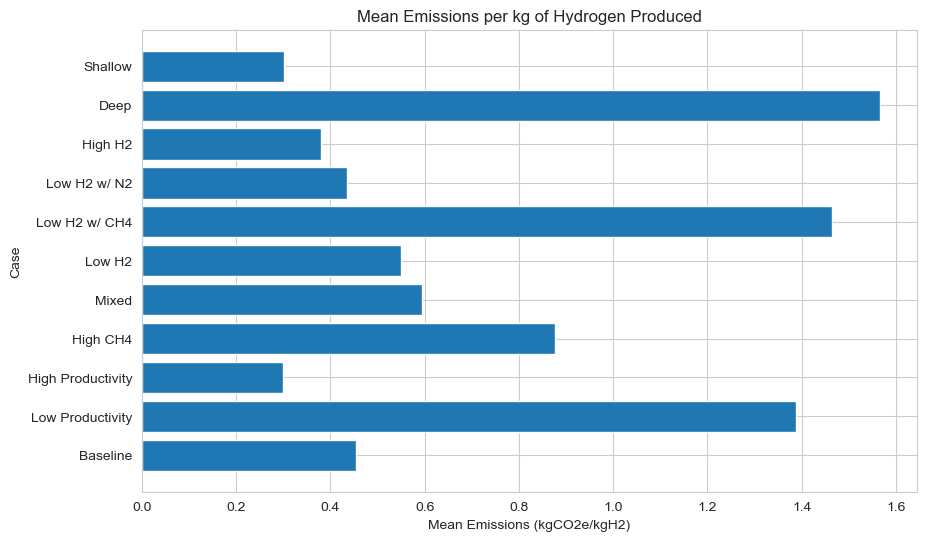

In [ ]:
#Create a horizontal bar plot of mean emissions per kg of hydrogen produced for each case:

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the horizontal bar plot
plt.barh(pivoted_emissions_df.columns, pivoted_emissions_df.loc['Mean Emissions kgCO2e/kgH2'])

# Add title and labels
plt.title('Mean Emissions per kg of Hydrogen Produced')
plt.xlabel('Mean Emissions (kgCO2e/kgH2)')
plt.ylabel('Case')

# Display the plot
plt.show()

## 7.5 Monte Carlo Uncertainty Analysis

Create structures to perform Monte Carlo analysis to examine effects of uncertain assumptions on emissions intensity results

In [ ]:
# # List assumptions to be used in the sensitivity analysis. For now, we will start by considering only GWP_H2.

# # Define the sensitivity analysis assumptions
# sensitivity_assumptions = { #Assume that GWP_H2 varies between 3 and 15 with a uniform probability distribution.
#     'GWP_H2': np.random.uniform(3, 15, 1000)
# }

# # Create a DataFrame from the sensitivity assumptions
# sensitivity_assumptions_df = pd.DataFrame(sensitivity_assumptions)

# # # Display the DataFrame
# # print(sensitivity_assumptions_df)

# # Create a function to calculate the total emissions intensity for each case, over the entire field lifetime, for each sensitivity assumption. This will return a single result for each sensitivity value, representing the total emissions over the lifetime of the field, for each sensitivity assumption.:
# def calculate_average_emissions_per_kg_hydrogen(case, sensitivity_assumptions):
#     results = []
#     for i in range(len(sensitivity_assumptions['GWP_H2'])):
#         GWP_H2 = sensitivity_assumptions['GWP_H2'][i]
#         results.append(calculate_average_emissions_per_kg_hydrogen(case,GWP_H2))
#     return pd.DataFrame(results)

# # Test Usage:
# calculate_average_emissions_per_kg_hydrogen('Baseline',sensitivity_assumptions)

# # calculate_average_emissions_per_kg_H2_sensitivity = calculate_average_emissions_per_kg_hydrogen('Baseline',sensitivity_assumptions) #This function calculates total emissions and total hydrogen produced for each sensitivity assumption, then calcuates the ratio of the two to get the emissions intensity.

# # print(calculate_average_emissions_per_kg_H2_sensitivity)


### 7.5.1 Set up functions to handle the MC analysis

In [ ]:
# Define a function that handle the presence or absense of sensitivity variables and return the appropriate results, to be used within each calculation function

def sensitivity_variable_handling(sensitivity_variables):
    if sensitivity_variables:
        GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
        oil_production = sensitivity_variables.get('oil_production', oil_production_default)
        water_production = sensitivity_variables.get('water_production', water_production_default)
        small_source_emissions_percentage = sensitivity_variables.get('small_source_emissions_percentage', small_source_emissions_percentage_default)
        total_producing_wells = sensitivity_variables.get('Total Producing Wells', number_production_wells_default)
        field_lifespan = sensitivity_variables.get('Field Life', field_lifespan_default)
        water_cut = sensitivity_variables.get('Water Cut (bbl/mmscf)', water_cut_default)
        h2_purification_loss_rate = sensitivity_variables.get('H2 purification loss rate', h2_purification_loss_rate_default)
        pressure_decline_rate = sensitivity_variables.get('pressure_decline_rate', pressure_decline_rate_default)
    else:
        GWP_H2 = GWP_H2_default
        oil_production = oil_production_default
        water_production = water_production_default
        small_source_emissions_percentage = small_source_emissions_percentage_default
        total_producing_wells = number_production_wells_default
        field_lifespan = field_lifespan_default
        water_cut = water_cut_default
        h2_purification_loss_rate = h2_purification_loss_rate_default
        pressure_decline_rate = pressure_decline_rate_default 

    return {GWP_H2, oil_production, water_production, small_source_emissions_percentage, total_producing_wells, field_lifespan, water_cut, h2_purification_loss_rate, pressure_decline_rate}

In [ ]:
#Rather than changing the functions that handle the deterministic calculations, create new functions to handle the Monte Carlo calculations. This will allow the deterministic functions to be used for both types of calculations.

#First update all of the calculation functions to consider the sensitivity variables.

def calculate_total_emissions_MC(case, sensitivity_variables):
    daily_field_H2_exported = calculate_exploration_emissions(case, sensitivity_variables)['daily_field_H2_exported']
    total_direct_emissions = calculate_total_direct_emissions(case, sensitivity_variables)['total_direct_emissions']
    small_source_emissions = calculate_small_source_emissions(case, sensitivity_variables)['small_source_emissions']
    total_other_offsite_emissions = calculate_total_other_offsite_emissions(case, sensitivity_variables)['total_other_offsite_emissions']
    embodied_emissions_daily_rate = calculate_embodied_emissions_daily_rate(case, sensitivity_variables)['embodied_emissions_daily_rate']
    # number_production_wells = sensitivity_variables['number_production_wells']

    total_emissions = total_direct_emissions + embodied_emissions_daily_rate + total_other_offsite_emissions + small_source_emissions

    production_weighted_emissions = total_emissions / (daily_field_H2_exported * 1000)
    production_weighted_embodied_emissions = embodied_emissions_daily_rate / (daily_field_H2_exported * 1000)
    total_emissions_absolute = sum(total_emissions * 365)  # kg CO2e

    min_production_weighted_emissions = min(production_weighted_emissions.tolist())
    mean_production_weighted_emissions = statistics.mean(production_weighted_emissions.tolist())
    median_production_weighted_emissions = statistics.median(production_weighted_emissions.tolist())
    max_production_weighted_emissions = max(production_weighted_emissions.tolist())
    mean_production_weighted_embodied_emissions = statistics.mean(production_weighted_embodied_emissions.tolist())
    percent_embodied_to_total = (mean_production_weighted_embodied_emissions / mean_production_weighted_emissions) * 100

    return {
        'case': case,
        'Min (Year 1) Emissions kgCO2e/kgH2': min_production_weighted_emissions,
        'Mean Emissions kgCO2e/kgH2': mean_production_weighted_emissions,
        'Median Emissions kgCO2e/kgH2': median_production_weighted_emissions,
        'Max (Year 30) Emissions kgCO2e/kgH2': max_production_weighted_emissions,
        'Mean Embodied Emissions kgCO2e/kgH2': mean_production_weighted_embodied_emissions,
        'Percent Embodied to Total Emissions': percent_embodied_to_total,
        'Total Emissions kgCO2e/day': total_emissions,
        'Total lifetime emissions kgCO2e': total_emissions_absolute,
        'Total direct emissions kgCO2e/day': total_direct_emissions,
        'Total small source emissions kgCO2e/day': small_source_emissions,
        'Total other offsite emissions kgCO2e/day': total_other_offsite_emissions,
        'Total embodied emissions kgCO2e/day': embodied_emissions_daily_rate,
        }

# def calculate_average_emissions_per_kg_hydrogen_MC(case, sensitivity_variables=None):
#     if sensitivity_variables:
#         field_lifespan = sensitivity_variables.get('field_lifespan', field_lifespan_default)
#         GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
#     else:
#         field_lifespan = field_lifespan_default
#         GWP_H2 = GWP_H2_default

#     total_emissions = calculate_total_emissions_MC(case, sensitivity_variables)['Total lifetime emissions kgCO2e']
#     total_hydrogen_produced = calculate_total_hydrogen_produced(case)['total_hydrogen_produced']
#     return total_emissions / total_hydrogen_produced

def perform_sensitivity_analysis(case, sensitivity_values):
    first_variable = sensitivity_values[list(sensitivity_values.keys())[0]]
    N = len(first_variable)
    results = np.zeros(N)
    all_cases = [{key: value[i] for key, value in sensitivity_values.items()} for i in range(N)]
    for counter, case_data in enumerate(all_cases):
        average_emissions_per_kg_hydrogen = calculate_average_emissions_per_kg_hydrogen(case, case_data)
        results[counter] = average_emissions_per_kg_hydrogen['average_emissions_per_kg_hydrogen']
    return pd.DataFrame({**sensitivity_values, 'average_emissions_per_kg_hydrogen': results})

def perform_sensitivity_analysis_parallel(case, sensitivity_values):
    num_cores = max([1, mp.cpu_count()-1])
    first_variable = sensitivity_values[list(sensitivity_values.keys())[0]]
    N = len(first_variable)
    all_cases = [{key: value[i] for key, value in sensitivity_values.items()} for i in range(N)]
    with mp.Pool(num_cores) as p:
        results = p.starmap(calculate_average_emissions_per_kg_hydrogen, zip(repeat(case), all_cases))
    return pd.DataFrame({**sensitivity_values, 'average_emissions_per_kg_hydrogen': results})

# Define the sensitivity analysis assumptions
N = 100 # Number of samples to be generated for the Monte Carlo simulation

#Set the random seed so the results are repeatable:
np.random.seed(123)
sensitivity_assumptions = {
    'GWP_H2': np.random.uniform(2, 15, N),
    'oil_production': np.random.uniform(0.01, 10, N),
    'water_production': np.random.uniform(0.01, 10, N),
    'small_source_emissions_percentage': np.random.uniform(1, 15, N),
    'Total Producing Wells': np.random.randint(1, 100, N),
    'Field Life': np.random.randint(5, 50, N),
    'Water Cut (bbl/mmscf)': np.random.uniform(0.01, 10, N),
    'H2 purification loss rate': np.random.uniform(1, 20, N),
    'pressure_decline_rate': np.random.uniform(0.98, 85, N),
    'number_production_wells': np.random.randint(10, 100, N) 
}

# Set simplistic sensitivity assumptions to help debug tornado plots:
# sensitivity_assumptions = {
    # 'GWP_H2': np.array([1, 15]),
    # 'oil_production': np.array([0.01, 10]),
    # 'water_production': np.array([0.01, 10]),
    # 'small_source_emissions_percentage': np.array([1,20]),
    # 'Total Producing Wells': np.array([1, 100]),
    # 'Field Life': np.array([5, 50]),
    # 'Water Cut (bbl/mmscf)': np.array([0.01, 10]),
    # 'H2 purification loss rate': np.array([1, 20]),
    # 'pressure_decline_rate': np.array([0.98, 85]),
    # 'number_production_wells': np.array([10, 100])
# }

# Run sensitivity analysis for the 'Baseline' case
sensitivity_results = perform_sensitivity_analysis('Baseline', sensitivity_assumptions)
# print(sensitivity_results['average_emissions_per_kg_hydrogen'])

# Calculate basic statistics for the sensitivity analysis results:
sensitivity_statistics = sensitivity_results['average_emissions_per_kg_hydrogen'].describe()
# print(sensitivity_statistics)

# Describe the statistics of sensitivity_assumptions

sensitivity_assumptions_df = pd.DataFrame(sensitivity_assumptions)
sensitivity_assumptions_statistics = sensitivity_assumptions_df.describe()
print(sensitivity_assumptions_statistics)



           GWP_H2  oil_production  water_production  \
count  100.000000      100.000000        100.000000   
mean     8.518575        5.056076          4.891793   
std      3.206022        2.857600          3.128682   
min      2.209680        0.036854          0.065399   
25%      6.139150        2.800087          2.286350   
50%      8.579684        5.501285          4.633180   
75%     10.992996        7.511978          7.894260   
max     14.939660        9.883571          9.960902   

       small_source_emissions_percentage  Total Producing Wells  Field Life  \
count                         100.000000             100.000000  100.000000   
mean                            7.888387              49.870000   28.300000   
std                             3.891406              26.761443   12.703694   
min                             1.049451               1.000000    6.000000   
25%                             4.694466              28.000000   18.000000   
50%                           

In [ ]:
# Use a loop to calculate the sensitivity statistics for each case and store the results in a dataframe for display:
sensitivity_results_dict = {}
for case in cases:
    sensitivity_results = perform_sensitivity_analysis(case, sensitivity_assumptions)
    sensitivity_statistics = sensitivity_results['average_emissions_per_kg_hydrogen'].describe()
    sensitivity_results_dict[case] = sensitivity_statistics

# Create a DataFrame from the sensitivity results dictionary
sensitivity_results_df = pd.DataFrame(sensitivity_results_dict)

# Display the DataFrame
print(sensitivity_results_df)


         Baseline  Low Productivity  High Productivity    High CH4  \
count  100.000000        100.000000         100.000000  100.000000   
mean     0.374460          1.123345           0.249644    0.741716   
std      0.111406          0.443598           0.056117    0.117741   
min      0.199528          0.435997           0.160117    0.549491   
25%      0.271035          0.722508           0.197007    0.627401   
50%      0.381492          1.145933           0.252443    0.742221   
75%      0.481287          1.547634           0.302831    0.848512   
max      0.554358          1.829044           0.341907    0.940772   

            Mixed      Low H2  Low H2 w/ CH4  Low H2 w/ N2     High H2  \
count  100.000000  100.000000     100.000000    100.000000  100.000000   
mean     0.496878    0.454495       1.249268      0.355148    0.311437   
std      0.113363    0.126939       0.143028      0.125314    0.099232   
min      0.316182    0.254502       1.010392      0.160016    0.156162   

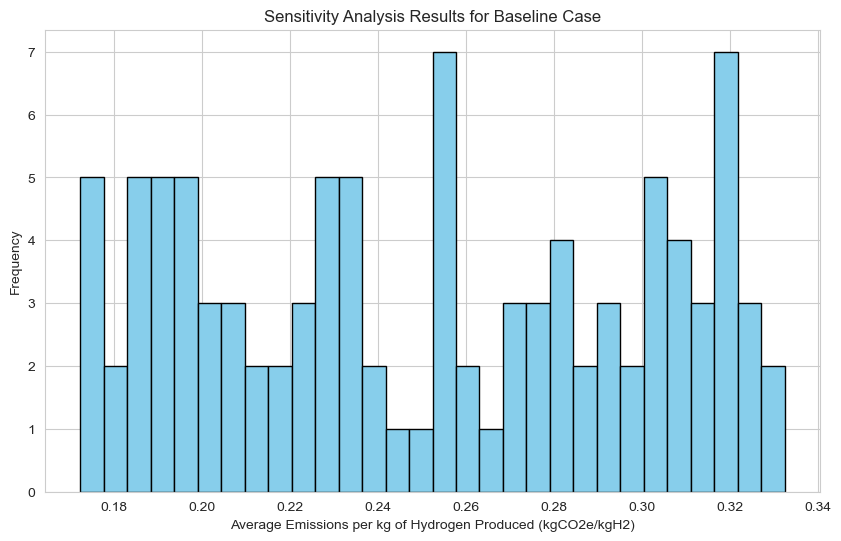

/Users/Tim/miniconda3/envs/holoviz2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


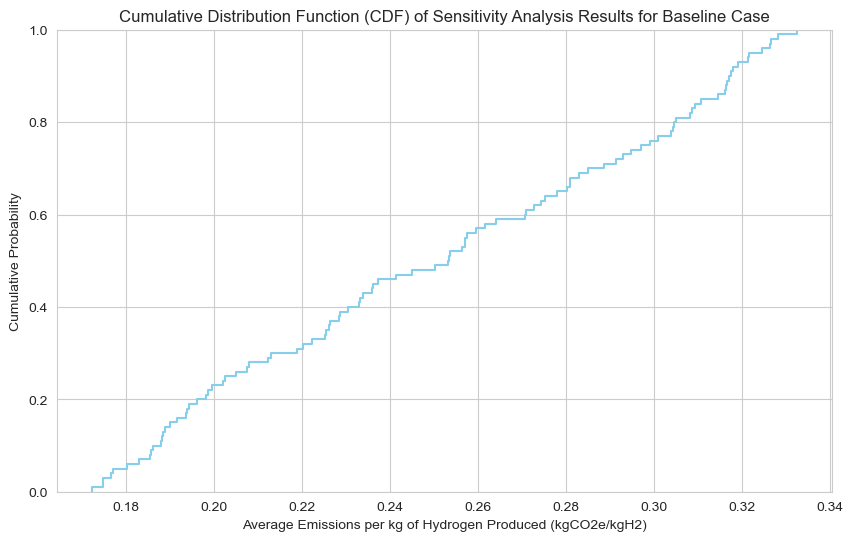

In [ ]:
# Plot a histogram of the sensitivity analysis results for the 'Baseline' case:

# Replacing infinite values with NaN to ensure future compatibility with seaborne plotting:
sensitivity_results.replace([np.inf, -np.inf], np.nan, inplace=True)

plt.figure(figsize=(10, 6))
plt.hist(sensitivity_results['average_emissions_per_kg_hydrogen'], bins=30, color='skyblue', edgecolor='black')
plt.title('Sensitivity Analysis Results for Baseline Case')
plt.xlabel('Average Emissions per kg of Hydrogen Produced (kgCO2e/kgH2)')
plt.ylabel('Frequency')
plt.show()

# Plot a cumulative distribution function (CDF) of the sensitivity analysis results for the 'Baseline' case:
plt.figure(figsize=(10, 6))
sns.ecdfplot(sensitivity_results['average_emissions_per_kg_hydrogen'], color='skyblue')
plt.title('Cumulative Distribution Function (CDF) of Sensitivity Analysis Results for Baseline Case')
plt.xlabel('Average Emissions per kg of Hydrogen Produced (kgCO2e/kgH2)')
plt.ylabel('Cumulative Probability')
plt.show()



### 7.5.2 Tornado charts based on MC analysis

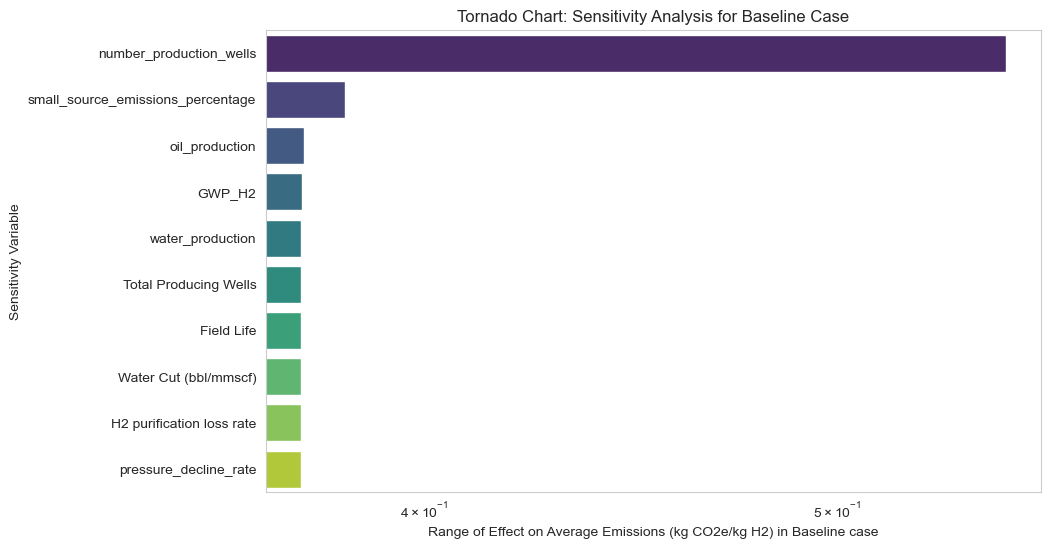

9    0.343686
3    0.018435
1    0.001129
0    0.000069
2    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
Name: Range of Effect, dtype: float64


In [ ]:
# def perform_sensitivity_analysis_single_variable(case, sensitivity_values):
#     # Calculate the base case using mean values of sensitivity variables
#     base_case = {key: np.mean(value) for key, value in sensitivity_values.items()}
#     results = {}

#     for key, values in sensitivity_values.items():
#         num_values = len(values)
#         effects = np.zeros(num_values)  # Preallocate a NumPy array for effects

#         for i, value in enumerate(values):
#             case_data = base_case.copy()
#             case_data[key] = value
#             average_emissions_per_kg_hydrogen = calculate_average_emissions_per_kg_hydrogen(case, case_data)['average_emissions_per_kg_hydrogen']
#             effects[i] = average_emissions_per_kg_hydrogen

#         results[key] = {
#             'min_effect': np.min(effects),
#             'max_effect': np.max(effects)
#         }

#     return results
 # Parallel computation version of the function:
def calculate_effect(key, value, base_case, case):
    case_data = base_case.copy()
    case_data[key] = value
    return calculate_average_emissions_per_kg_hydrogen(case, case_data)['average_emissions_per_kg_hydrogen']

def perform_sensitivity_analysis_single_variable(case, sensitivity_values):
    # Calculate the base case using mean values of sensitivity variables
    base_case = {key: np.mean(value) for key, value in sensitivity_values.items()}
    results = {}

    for key, values in sensitivity_values.items():
        effects = Parallel(n_jobs=-1)(delayed(calculate_effect)(key, value, base_case, case) for value in values)

        results[key] = {
            'min_effect': np.min(effects),
            'max_effect': np.max(effects)
        }

    return results

# Run sensitivity analysis for the 'Baseline' case
case = 'Baseline'
tornado_sensitivity_results = perform_sensitivity_analysis_single_variable(case, sensitivity_assumptions)

# Extract the min and max effects
min_effects = [result['min_effect'] for result in tornado_sensitivity_results.values()]
max_effects = [result['max_effect'] for result in tornado_sensitivity_results.values()]
variables = list(tornado_sensitivity_results.keys())

# Calculate the ranges of effects
ranges_of_effects = np.array(max_effects) - np.array(min_effects)
influences = np.array(min_effects) + ranges_of_effects

# Create a DataFrame for plotting
tornado_df = pd.DataFrame({
    'Case': case,
    'Variable': variables,
    'Min Effect': min_effects,
    'Max Effect': max_effects,
    'Range of Effect': ranges_of_effects,
    'Influences': influences
})

# Sort the DataFrame by the range of effect
tornado_df.sort_values(by='Range of Effect', ascending=False, inplace=True)

# Plot the tornado chart with a logarithmic scale for the range of effect
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Influences', y='Variable', data=tornado_df, palette='viridis')
ax.set_xscale('log')
plt.xlabel(f'Range of Effect on Average Emissions (kg CO2e/kg H2) in {case} case')
plt.ylabel('Sensitivity Variable')
plt.title(f'Tornado Chart: Sensitivity Analysis for {case} Case')
plt.show()

print(tornado_df['Range of Effect'])

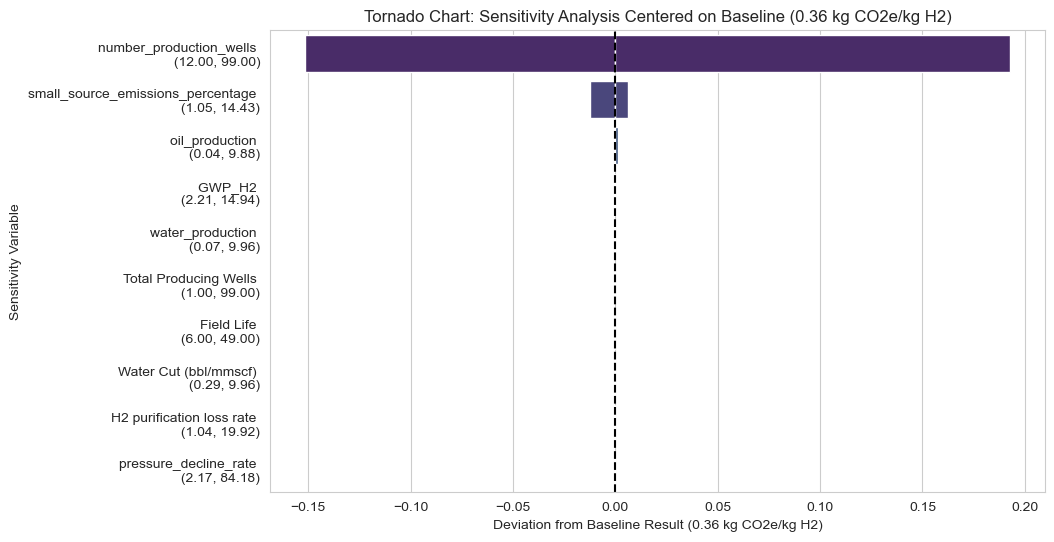

In [ ]:
# Make a Tornado Chart that is centered around the deterministic value of the case under consideration:

# # Function to perform sensitivity analysis with single variable change
# def perform_sensitivity_analysis_single_variable(case, sensitivity_values):
#     # Calculate the deterministic baseline result for the specified case
#     baseline_result = calculate_average_emissions_per_kg_hydrogen(case)['average_emissions_per_kg_hydrogen']

#     results = {}

#     for key, values in sensitivity_values.items():
#         effects = []
#         for value in values:
#             case_data = {k: np.mean(v) for k, v in sensitivity_values.items()}  # Start with mean values
#             case_data[key] = value  # Only vary the current key
#             average_emissions_per_kg_hydrogen = calculate_average_emissions_per_kg_hydrogen(case, case_data)['average_emissions_per_kg_hydrogen']
#             effects.append(average_emissions_per_kg_hydrogen)

#         results[key] = {
#             'min_effect': np.min(effects),
#             'max_effect': np.max(effects)
#         }

#     return baseline_result, results  # Return the baseline result and sensitivity analysis results

# Parallel computation version of the function:

def calculate_effect(case, key, value, default_case):
    case_data = default_case.copy()
    case_data[key] = value
    return calculate_average_emissions_per_kg_hydrogen(case, case_data)['average_emissions_per_kg_hydrogen']

def perform_sensitivity_analysis_single_variable(case, sensitivity_values):
    # Calculate the deterministic baseline result for the specified case
    baseline_result = calculate_average_emissions_per_kg_hydrogen(case)['average_emissions_per_kg_hydrogen']

    results = {}
    num_cores = -1  # Use all available CPU cores

    for key, values in sensitivity_values.items():
        # Prepare the default case with default values
        default_case = {
            'field_lifespan': field_lifespan_default,
            'GWP_H2': GWP_H2_default,
            'number_production_wells': number_production_wells_default,
            'oil_production': oil_production_default,
            'water_production': water_production_default,
            'small_source_emissions_percentage': small_source_emissions_percentage_default,
            'Total Producing Wells': number_production_wells_default,
            'Field Life': field_lifespan_default,
            'Water Cut (bbl/mmscf)': water_cut_default,
            'H2 purification loss rate': h2_purification_loss_rate_default,
            'pressure_decline_rate': pressure_decline_rate_default
        }

        # Parallelize the computation of effects
        effects = Parallel(n_jobs=num_cores)(
            delayed(calculate_effect)(case, key, value, default_case) for value in values
        )

        results[key] = {
            'min_effect': np.min(effects),
            'max_effect': np.max(effects)
        }

    return baseline_result, results  # Return the baseline result and sensitivity analysis results


# baseline_result, tornado_sensitivity_results = perform_sensitivity_analysis_single_variable('Baseline', sensitivity_assumptions)

# # Extract the min and max effects and center them around the baseline result
# min_effects = [result['min_effect'] for result in tornado_sensitivity_results.values()]
# max_effects = [result['max_effect'] for result in tornado_sensitivity_results.values()]

# # Calculate the deviations from the baseline result
# min_deviation = [min_effect - baseline_result for min_effect in min_effects]
# max_deviation = [max_effect - baseline_result for max_effect in max_effects]

# # Create a DataFrame for plotting
# tornado_df = pd.DataFrame({
#     'Variable': list(tornado_sensitivity_results.keys()),
#     'Min Deviation': min_deviation,
#     'Max Deviation': max_deviation
# })

# # Sort the DataFrame by the absolute maximum deviation
# tornado_df['Range of Effect'] = tornado_df['Max Deviation'] - tornado_df['Min Deviation']
# tornado_df.sort_values(by='Range of Effect', ascending=False, inplace=True)

# # Plot the tornado chart centered around the baseline result
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(x='Min Deviation', y='Variable', data=tornado_df, palette='viridis', label='Min Deviation')
# sns.barplot(x='Max Deviation', y='Variable', data=tornado_df, palette='viridis', label='Max Deviation')

# plt.axvline(0, color='k', linestyle='--')
# plt.xlabel(f'Deviation from Baseline Result ({baseline_result:.2f} kg CO2e/kg H2)')
# plt.ylabel('Sensitivity Variable')
# plt.title(f'Tornado Chart: Sensitivity Analysis Centered on Baseline ({baseline_result:.2f} kg CO2e/kg H2)')
# # plt.legend(title='Deviation Type')
# plt.show()

# print(tornado_df)

#Using the logic above, create a function that creates a tornado plot for a given case and sensitivity assumptions:

# def create_tornado_plot(case, sensitivity_assumptions):
#     baseline_result, tornado_sensitivity_results = perform_sensitivity_analysis_single_variable(case, sensitivity_assumptions)

#     # Extract the min and max effects and center them around the baseline result
#     min_effects = [result['min_effect'] for result in tornado_sensitivity_results.values()]
#     max_effects = [result['max_effect'] for result in tornado_sensitivity_results.values()]

#     # Calculate the deviations from the baseline result
#     min_deviation = [min_effect - baseline_result for min_effect in min_effects]
#     max_deviation = [max_effect - baseline_result for max_effect in max_effects]

#     #  Update the variable names to include min and max values used in Monte Carlo analysis in parentheses:
#     variable_names = []
#     for variable in tornado_df['Variable']:
#         min_value = min(sensitivity_assumptions[variable])
#         max_value = max(sensitivity_assumptions[variable])
#         variable_names.append(f'{variable} ({min_value:.2f}, {max_value:.2f})')

#     # Create a DataFrame for plotting
#     tornado_df = pd.DataFrame({
#         'Variable': variable_names,
#         'Min Deviation': min_deviation,
#         'Max Deviation': max_deviation
#     })

#     # Sort the DataFrame by the absolute maximum deviation
#     tornado_df['Range of Effect'] = tornado_df['Max Deviation'] - tornado_df['Min Deviation']
#     tornado_df.sort_values(by='Range of Effect', ascending=False, inplace=True)




#     # Plot the tornado chart centered around the baseline result
#     plt.figure(figsize=(10, 6))
#     ax = sns.barplot(x='Min Deviation', y='Variable', data=tornado_df, palette='viridis', label='Min Deviation')
#     sns.barplot(x='Max Deviation', y='Variable', data=tornado_df, palette='viridis', label='Max Deviation')

#     plt.axvline(0, color='k', linestyle='--')
#     plt.xlabel(f'Deviation from {case} Result ({baseline_result:.2f} kg CO2e/kg H2)')
#     plt.ylabel('Sensitivity Variable')

#     # # For each of the variables, display the minimum and maximum value used within the Monte Carlo simulation as text on the plot:

#     # for i, variable in enumerate(tornado_df['Variable']):
#     #     min_value = min(sensitivity_assumptions[variable])
#     #     max_value = max(sensitivity_assumptions[variable])
#     #     plt.text(-0.1, i, f'{min_value:.2f}', va='center', ha='right', color='black')
#     #     plt.text(0.1, i, f'{max_value:.2f}', va='center', ha='left', color='black')

 
#     #Plot the title such that it refers to the case under consideration:
#     plt.title(f'Tornado Chart: Sensitivity Analysis Centered on {case} ({baseline_result:.2f} kg CO2e/kg H2)', loc='center')
#     plt.show()



# Function to create a tornado plot for a given case and sensitivity assumptions
def create_tornado_plot(case, sensitivity_assumptions):
    baseline_result, tornado_sensitivity_results = perform_sensitivity_analysis_single_variable(case, sensitivity_assumptions)

    # Extract the min and max effects and center them around the baseline result
    min_effects = [result['min_effect'] for result in tornado_sensitivity_results.values()]
    max_effects = [result['max_effect'] for result in tornado_sensitivity_results.values()]

    # Calculate the deviations from the baseline result
    min_deviation = [min_effect - baseline_result for min_effect in min_effects]
    max_deviation = [max_effect - baseline_result for max_effect in max_effects]

    # Create a DataFrame for plotting
    tornado_df = pd.DataFrame({
        'Variable': list(tornado_sensitivity_results.keys()),
        'Min Deviation': min_deviation,
        'Max Deviation': max_deviation
    })

    # Update the variable names to include min and max values used in Monte Carlo analysis in parentheses
    variable_names = []
    for variable in tornado_df['Variable']:
        min_value = min(sensitivity_assumptions[variable])
        max_value = max(sensitivity_assumptions[variable])
        variable_names.append(f'{variable} \n ({min_value:.2f}, {max_value:.2f})')

    tornado_df['Variable'] = variable_names

    # Sort the DataFrame by the absolute maximum deviation
    tornado_df['Range of Effect'] = tornado_df['Max Deviation'] - tornado_df['Min Deviation']
    tornado_df.sort_values(by='Range of Effect', ascending=False, inplace=True)

    # Plot the tornado chart centered around the baseline result
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Min Deviation', y='Variable', data=tornado_df, palette='viridis', label='Min Deviation')
    sns.barplot(x='Max Deviation', y='Variable', data=tornado_df, palette='viridis', label='Max Deviation')

    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel(f'Deviation from {case} Result ({baseline_result:.2f} kg CO2e/kg H2)')
    plt.ylabel('Sensitivity Variable')
    plt.title(f'Tornado Chart: Sensitivity Analysis Centered on {case} ({baseline_result:.2f} kg CO2e/kg H2)', loc='center')
    plt.show()

# Test the function with the 'Baseline' case and sensitivity assumptions
create_tornado_plot('Baseline', sensitivity_assumptions)


In [ ]:
# #Create another tornado plot using the same data but excluding small_source_emissions_percentage

# # Run sensitivity analysis for the 'Baseline' case
# tornado_sensitivity_results = perform_sensitivity_analysis_single_variable('Baseline', sensitivity_assumptions)

# # Extract the min and max effects
# min_effects = [result['min_effect'] for key, result in tornado_sensitivity_results.items() if key != 'small_source_emissions_percentage']
# max_effects = [result['max_effect'] for key, result in tornado_sensitivity_results.items() if key != 'small_source_emissions_percentage']
# variables = [key for key in tornado_sensitivity_results.keys() if key != 'small_source_emissions_percentage']

# # Calculate the ranges of effects
# ranges_of_effects = np.array(max_effects) - np.array(min_effects)

# # Create a DataFrame for plotting
# tornado_df = pd.DataFrame({
#     'Variable': variables,
#     'Min Effect': min_effects,
#     'Max Effect': max_effects,
#     'Range of Effect': ranges_of_effects
# })

# # Sort the DataFrame by the range of effect
# tornado_df.sort_values(by='Range of Effect', ascending=False, inplace=True)

# # Plot the tornado chart
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Range of Effect', y='Variable', data=tornado_df, palette='viridis')
# plt.xlabel('Range of Effect on Average Emissions (kg CO2e/kg H2)')
# plt.ylabel('Sensitivity Variable')
# plt.title('Tornado Chart: Sensitivity Analysis')
# plt.show()


In [ ]:
# def calculate_average_emissions_per_kg_hydrogen_MC(case, sensitivity_variables):
    
#     total_emissions = calculate_total_emissions_MC(case, sensitivity_variables)['Total lifetime emissions kgCO2e']
#     total_hydrogen_produced = calculate_total_hydrogen_produced(case)['total_hydrogen_produced']
#     return total_emissions / total_hydrogen_produced

# def perform_sensitivity_analysis(case, sensitivity_values):
#     first_variable = sensitivity_values[list(sensitivity_values.keys())[0]]
#     N = len(first_variable)
#     results = np.zeros(N)
#     all_cases = [{key: value[i] for key, value in sensitivity_values.items()} for i in range(N)]
#     for counter, case_data in enumerate(all_cases):
#         average_emissions_per_kg_hydrogen = calculate_average_emissions_per_kg_hydrogen_MC(case, case_data)
#         results[counter] = average_emissions_per_kg_hydrogen
#     # Return a data frame using the sensitivty values and results as columns
#     return pd.DataFrame({**sensitivity_values, 'average_emissions_per_kg_hydrogen': results})

# def perform_sensitivity_analysis_parallel(case, sensitivity_values):
#     num_cores = max([1, mp.cpu_count()-1])
#     first_variable = sensitivity_values[list(sensitivity_values.keys())[0]]
#     N = len(first_variable)
#     # results = np.zeros(N)
#     all_cases = [{key: value[i] for key, value in sensitivity_values.items()} for i in range(N)]
#     with mp.Pool(num_cores) as p:
#         results = p.starmap(calculate_average_emissions_per_kg_hydrogen_MC, zip(repeat(case), all_cases))
        
#     # Return a data frame using the sensitivty values and results as columns
#     return pd.DataFrame({**sensitivity_values, 'average_emissions_per_kg_hydrogen': results})

# # Define the sensitivity analysis assumptions. This includes the list of variables that we want to check for sensitivity, as well as the probability density function that describes the assumed uncertainty for each variable. 
# N = 100
# sensitivity_assumptions = {
#     'GWP_H2': np.random.uniform(3, 15, N),
#     'oil_production': np.random.uniform(0.01, 10, N),
#     'water_production': np.random.uniform(0.01, 10, N),
#     'small_source_emissions_percentage': np.random.uniform(1, 20, N),
#     'Total Producing Wells': np.random.randint(1, 100, N),
#     'Field Life': np.random.randint(5, 50, N),
#     'Water Cut (bbl/mmscf)': np.random.uniform(0.01, 10, N),
#     'H2 purification loss rate': np.random.uniform(1, 20, N),
#     pressure_decline_rate: np.random.uniform(0.98, 85, N),
    
  
# }

# # Run sensitivity analysis for the 'Baseline' case
# sensitivity_results = perform_sensitivity_analysis('Baseline', sensitivity_assumptions)
# print(sensitivity_results.head())

# # #Calculate basic statistics for the sensitivity analysis results:
# # sensitivity_statistics = sensitivity_results.describe()

# # sensitivity_results_parr = perform_sensitivity_analysis_parallel('Baseline', sensitivity_assumptions)
# # print(sensitivity_results_parr.head())

# # #Calculate basic statistics for the sensitivity analysis results:
# sensitivity_statistics = sensitivity_results.describe()
# sensitivity_statistics 


In [ ]:
# def calculate_total_emissions(case, sensitivity_variables=None):
#     if sensitivity_variables:
#         GWP_H2 = sensitivity_variables.get('GWP_H2', GWP_H2_default)
#         oil_production = sensitivity_variables.get('oil_production', oil_production_default)
#         water_production = sensitivity_variables.get('water_production', water_production_default)
#         small_source_emissions_percentage = sensitivity_variables.get('small_source_emissions_percentage', small_source_emissions_percentage_default)
#         total_producing_wells = sensitivity_variables.get('Total Producing Wells', number_production_wells_default)
#         field_lifespan = sensitivity_variables.get('Field Life', field_lifespan_default)
#         water_cut = sensitivity_variables.get('Water Cut (bbl/mmscf)', water_cut_default)
#         h2_purification_loss_rate = sensitivity_variables.get('H2 purification loss rate', h2_purification_loss_rate_default)
#         pressure_decline_rate = sensitivity_variables.get('pressure_decline_rate', pressure_decline_rate_default)
#     else:
#         GWP_H2 = GWP_H2_default
#         oil_production = oil_production_default
#         water_production = water_production_default
#         small_source_emissions_percentage = small_source_emissions_percentage_default
#         total_producing_wells = number_production_wells_default
#         field_lifespan = field_lifespan_default
#         water_cut = water_cut_default
#         h2_purification_loss_rate = h2_purification_loss_rate_default
#         pressure_decline_rate = pressure_decline_rate_default

#     # Call the functions to calculate the total emissions for each case
#     daily_field_H2_exported = calculate_exploration_emissions(case, sensitivity_variables)['daily_field_H2_exported']
#     total_direct_emissions = calculate_total_direct_emissions(case, sensitivity_variables)['total_direct_emissions']
#     small_source_emissions = calculate_small_source_emissions(case, sensitivity_variables)['small_source_emissions']
#     total_other_offsite_emissions = calculate_total_other_offsite_emissions(case, sensitivity_variables)['total_other_offsite_emissions']
#     embodied_emissions_daily_rate = calculate_embodied_emissions_daily_rate(case, sensitivity_variables)['embodied_emissions_daily_rate']

#     total_emissions = total_direct_emissions + embodied_emissions_daily_rate + total_other_offsite_emissions + small_source_emissions

#     production_weighted_emissions = total_emissions / (daily_field_H2_exported * 1000)

#     production_weighted_embodied_emissions = embodied_emissions_daily_rate / (daily_field_H2_exported * 1000)

#     total_emissions_absolute = sum(total_emissions * 365) #kg CO2e. This is the total emissions over the lifetime of the field. Assumes emissions are constant over each year of the field's lifetime.

#     # Calculate statistics
#     min_production_weighted_emissions = min(production_weighted_emissions.tolist())  # Convert Series to list
#     mean_production_weighted_emissions = statistics.mean(production_weighted_emissions.tolist())  # Convert Series to list
#     median_production_weighted_emissions = statistics.median(production_weighted_emissions.tolist())  # Convert Series to list
#     max_production_weighted_emissions = max(production_weighted_emissions.tolist())  # Convert Series to list
#     mean_production_weighted_embodied_emissions = statistics.mean(production_weighted_embodied_emissions.tolist())  # Convert Series to list
#     percent_embodied_to_total = (mean_production_weighted_embodied_emissions / mean_production_weighted_emissions) * 100

#     return {
#         'case': case,
#         'Min (Year 1) Emissions kgCO2e/kgH2': min_production_weighted_emissions,
#         'Mean Emissions kgCO2e/kgH2': mean_production_weighted_emissions,
#         'Median Emissions kgCO2e/kgH2': median_production_weighted_emissions,
#         'Max (Year 30) Emissions kgCO2e/kgH2': max_production_weighted_emissions,
#         'Mean Embodied Emissions kgCO2e/kgH2': mean_production_weighted_embodied_emissions,
#         'Percent Embodied to Total Emissions': percent_embodied_to_total,
#         'Total Emissions kgCO2e/day': total_emissions,
#         'Total lifetime emissions kgCO2e': total_emissions_absolute,
#         'Total direct emissions kgCO2e/day': total_direct_emissions,
#         'Total small source emissions kgCO2e/day': small_source_emissions,
#         'Total other offsite emissions kgCO2e/day': total_other_offsite_emissions,
#         'Total embodied emissions kgCO2e/day': embodied_emissions_daily_rate
#     }


In [ ]:
def perform_sensitivity_analysis(case, sensitivity_values):
    first_variable = sensitivity_values[list(sensitivity_values.keys())[0]]
    N = len(first_variable)
    results = np.zeros(N)
    all_cases = [{key: value[i] for key, value in sensitivity_values.items()} for i in range(N)]
    for counter, case_data in enumerate(all_cases):
        average_emissions_per_kg_hydrogen = calculate_average_emissions_per_kg_hydrogen(case, case_data)
        results[counter] = average_emissions_per_kg_hydrogen
    return pd.DataFrame({**sensitivity_values, 'average_emissions_per_kg_hydrogen': results})

def perform_sensitivity_analysis_parallel(case, sensitivity_values):
    num_cores = max([1, mp.cpu_count()-1])
    first_variable = sensitivity_values[list(sensitivity_values.keys())[0]]
    N = len(first_variable)
    all_cases = [{key: value[i] for key, value in sensitivity_values.items()} for i in range(N)]
    with mp.Pool(num_cores) as p:
        results = p.starmap(calculate_average_emissions_per_kg_hydrogen, zip(repeat(case), all_cases))
    return pd.DataFrame({**sensitivity_values, 'average_emissions_per_kg_hydrogen': results})


In [ ]:
# # Define the sensitivity analysis assumptions
# N = 100
# sensitivity_assumptions = {
#     'GWP_H2': np.random.uniform(3, 15, N),
#     'oil_production': np.random.uniform(0.01, 10, N),
#     'water_production': np.random.uniform(0.01, 10, N),
#     'small_source_emissions_percentage': np.random.uniform(1, 20, N),
#     'Total Producing Wells': np.random.randint(1, 100, N),
#     'Field Life': np.random.randint(5, 50, N),
#     'Water Cut (bbl/mmscf)': np.random.uniform(0.01, 10, N),
#     'H2 purification loss rate': np.random.uniform(1, 20, N),
#     'pressure_decline_rate': np.random.uniform(0.98, 85, N),
# }

# # Run sensitivity analysis for the 'Baseline' case
# sensitivity_results = perform_sensitivity_analysis('Baseline', sensitivity_assumptions)
# print(sensitivity_results.head())

# # Calculate basic statistics for the sensitivity analysis results
# sensitivity_statistics = sensitivity_results.describe()
# print(sensitivity_statistics)


In [ ]:
sensitivity_statistics = sensitivity_results.describe()
print(sensitivity_statistics)

           GWP_H2  oil_production  water_production  \
count  100.000000      100.000000        100.000000   
mean     8.518575        5.056076          4.891793   
std      3.206022        2.857600          3.128682   
min      2.209680        0.036854          0.065399   
25%      6.139150        2.800087          2.286350   
50%      8.579684        5.501285          4.633180   
75%     10.992996        7.511978          7.894260   
max     14.939660        9.883571          9.960902   

       small_source_emissions_percentage  Total Producing Wells  Field Life  \
count                         100.000000             100.000000  100.000000   
mean                            7.888387              49.870000   28.300000   
std                             3.891406              26.761443   12.703694   
min                             1.049451               1.000000    6.000000   
25%                             4.694466              28.000000   18.000000   
50%                           

### 7.5.3 Rank-Order Correlation & Regression Coefficients

H2 purification loss rate            0.004008
Field Life                           0.004797
Water Cut (bbl/mmscf)                0.029742
Total Producing Wells                0.034370
oil_production                       0.095047
water_production                     0.177087
GWP_H2                               0.179054
pressure_decline_rate                0.179178
small_source_emissions_percentage    0.215787
number_production_wells              0.995019
Name: average_emissions_per_kg_hydrogen, dtype: float64


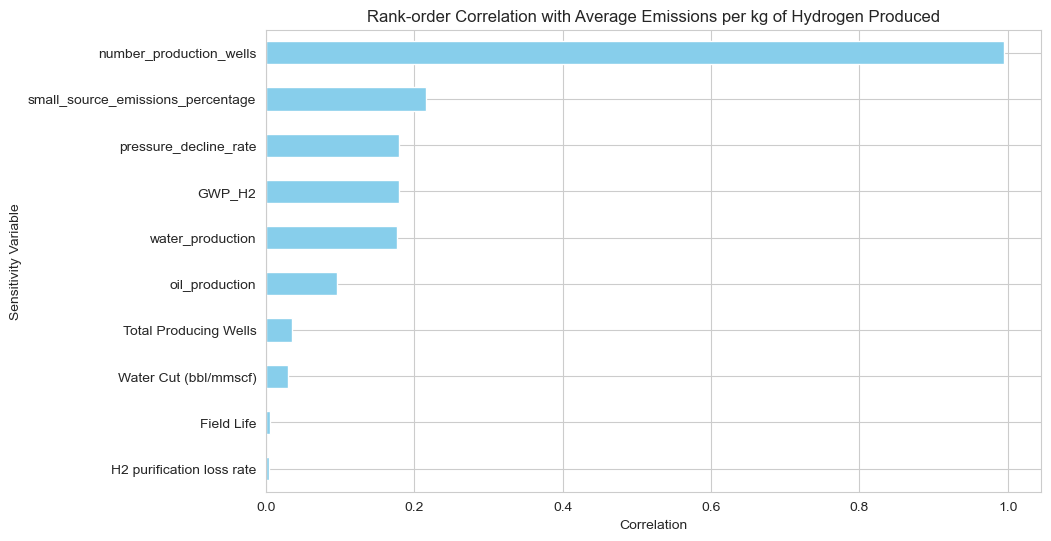

Field Life                           0.000019
H2 purification loss rate            0.000034
Total Producing Wells                0.000063
pressure_decline_rate                0.000363
Water Cut (bbl/mmscf)                0.000528
oil_production                       0.001633
number_production_wells              0.001740
small_source_emissions_percentage    0.002723
GWP_H2                               0.002742
water_production                     0.002779
dtype: float64


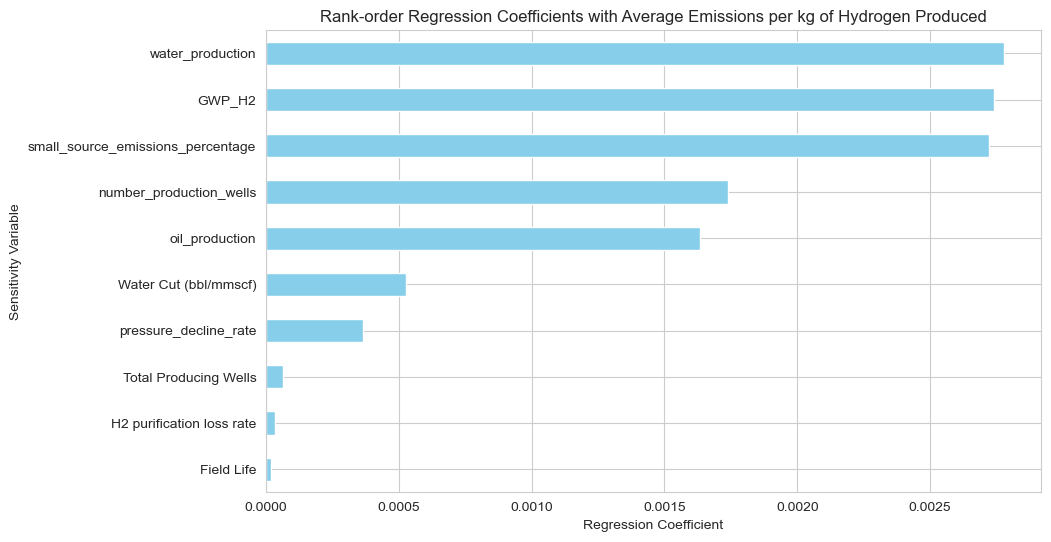

In [ ]:
# Calculate the rank-order correlation between the sensitivity variables and the average emissions per kg of hydrogen produced
correlation_matrix = sensitivity_results.corr()
correlation_with_target = correlation_matrix['average_emissions_per_kg_hydrogen']
correlation_with_target = correlation_with_target.drop('average_emissions_per_kg_hydrogen')  # Remove the correlation with itself
correlation_with_target = correlation_with_target.abs().sort_values(ascending=True)
print(correlation_with_target)

#Plot the rank-order correlation results in a horizontal bar chart:
plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='barh', color='skyblue')
plt.title('Rank-order Correlation with Average Emissions per kg of Hydrogen Produced')
plt.xlabel('Correlation')
plt.ylabel('Sensitivity Variable')
plt.show()



# Calculate the rank-order regression coefficients between the sensitivity variables and the average emissions per kg of hydrogen produced
X = sensitivity_results.drop(columns='average_emissions_per_kg_hydrogen')
y = sensitivity_results['average_emissions_per_kg_hydrogen']
regression_coefficients = {}
for variable in X.columns:
    model = LinearRegression().fit(X[[variable]], y)
    regression_coefficients[variable] = model.coef_[0]
regression_coefficients = pd.Series(regression_coefficients).abs().sort_values(ascending=True)
print(regression_coefficients)

# Plot the rank-order regression coefficients in a separate horizontal bar chart:
plt.figure(figsize=(10, 6))
regression_coefficients.plot(kind='barh', color='skyblue')
plt.title('Rank-order Regression Coefficients with Average Emissions per kg of Hydrogen Produced')
plt.xlabel('Regression Coefficient')
plt.ylabel('Sensitivity Variable')
plt.show()

# 8. Summary Plots

In [ ]:
#First summarise all of the emissions data in a single DataFrame

# Define your cases based on the reservoir data
cases = reservoir_data['Case']

# Initialize a list to store results for each case
emissions_summary_by_case = []

# Loop through each case and calculate emissions
for case in cases:
    # Calculate emissions for each case
    emissions_data = calculate_total_emissions(case)
    
    # Organize data into a dictionary for DataFrame creation
    emissions_summary_by_case.append({
        'Case': case,
        'Embodied emissions': emissions_data['Total embodied emissions kgCO2e/day'],
        'Direct emissions': emissions_data['Total direct emissions kgCO2e/day'],
        'Other offsite emissions': emissions_data['Total other offsite emissions kgCO2e/day'],
        'Small source emissions': emissions_data['Total small source emissions kgCO2e/day'],
        # 'Total emissions': emissions_data['Total Emissions kgCO2e/day']
    })

# Convert the list of dictionaries into a DataFrame
emissions_df = pd.DataFrame(emissions_summary_by_case)
emissions_df.set_index('Case', inplace=True)

# Display the DataFrame
emissions_df.head()



,Embodied emissions,Direct emissions,Other offsite emissions,Small source emissions
Case,,,,
Baseline,2260.787501,0 3514.939947 1 2825.606218 2 2543...,0 45.186904 1 44.064864 2 43.54739...,0 351.493995 1 282.560622 2 254.37...
Low Productivity,2260.787501,0 1052.808682 1 880.504565 2 810...,0 45.186121 1 44.063740 2 43.54598...,0 105.280868 1 88.050456 2 81.00...
High Productivity,2260.787501,0 6797.777964 1 5419.069827 2 4855...,0 45.187035 1 44.065051 2 43.54762...,0 679.777796 1 541.906983 2 485.53...
High CH4,2260.787501,0 13045.688130 1 10365.887369 2 9...,0 58.138939 1 57.020341 2 56.50667...,0 1304.568813 1 1036.588737 2 927...
Mixed,2260.787501,0 6691.856008 1 5339.033268 2 4785...,0 49.504249 1 48.383356 2 47.86715...,0 669.185601 1 533.903327 2 478.58...


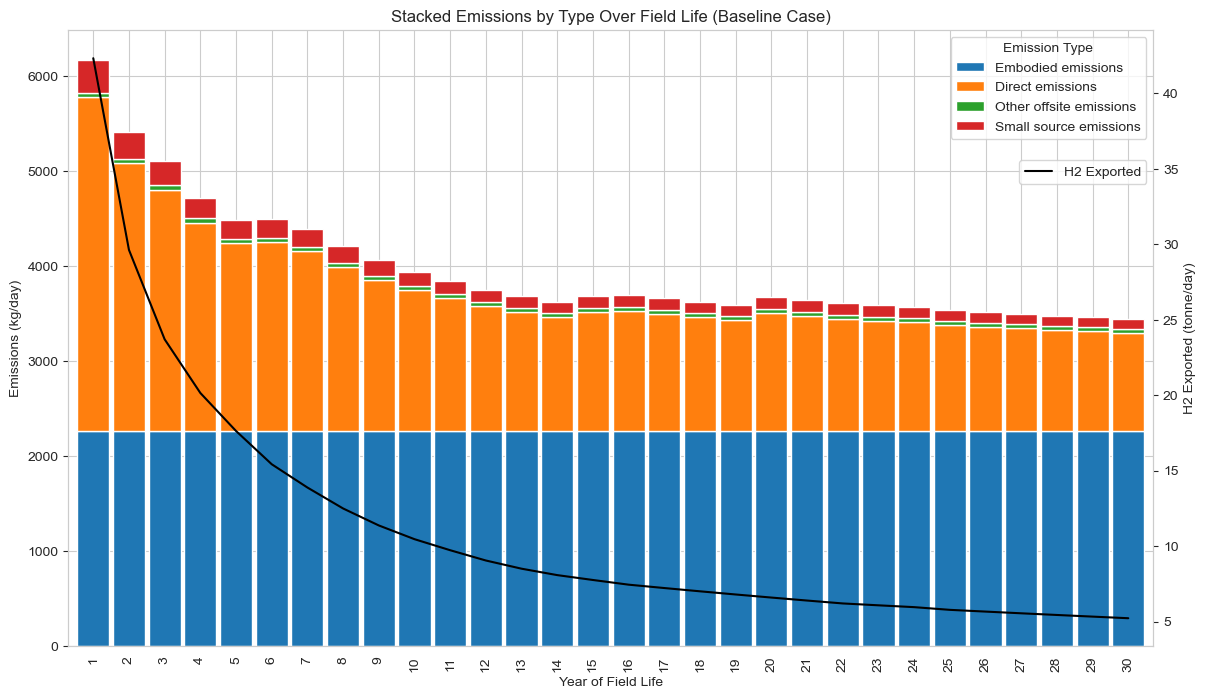

In [ ]:
#Now create a function to plot total emissions over time as a stacked bar chart of the different emission types:

def plot_emissions_by_case(case):
    # Ensure the case exists in the DataFrame
    if case not in emissions_df.index:
        print("Case not found in the DataFrame.")
        return
    
    # Extract each type of emission for the specified case into a DataFrame
    # Assuming each cell is already a properly formatted pd.Series or similar iterable
    data = {
        'Embodied emissions': emissions_df.loc[case, 'Embodied emissions'],
        'Direct emissions': emissions_df.loc[case, 'Direct emissions'],
        'Other offsite emissions': emissions_df.loc[case, 'Other offsite emissions'],
        'Small source emissions': emissions_df.loc[case, 'Small source emissions']
    }

    # Create a DataFrame where each column is a type of emission and each row is a year
    yearly_emissions_df = pd.DataFrame(data)

    # Ensure there is numeric data to plot
    if yearly_emissions_df.empty or yearly_emissions_df.dropna().empty:
        print("No data available to plot.")
        return

    #Offset the index by 1 to represent years
    yearly_emissions_df.index += 1

    # Plot a vertical stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    yearly_emissions_df.plot(kind='bar', stacked=True, ax=ax, width=0.9)
    ax.set_title(f'Stacked Emissions by Type Over Field Life ({case} Case)')
    ax.set_xlabel('Year of Field Life')
    ax.set_ylabel('Emissions (kg/day)')
    ax.legend(title='Emission Type')

    # Add the H2 production profile to the plot on a separate axis
    # Calculate daily_field_H2_exported before plotting
    daily_field_H2_exported = calculate_exploration_emissions(case)['daily_field_H2_exported']
    # Add a legend for the H2 production profile
    ax2 = ax.twinx()
    ax2.plot(daily_field_H2_exported, color='black', label='H2 Exported')
    ax2.set_ylabel('H2 Exported (tonne/day)')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.8))
    ax2.grid(False)

    # ax.twinx()
    # plt.twinx()
    # plt.plot(daily_field_H2_exported, color='black', label='H2 Exported')
    # plt.ylabel('H2 Exported (tonne/day)')
    # plt.grid(False)

    plt.show()

# Example usage:
plot_emissions_by_case('Baseline')

# #Plots for all cases:
# for case in cases:
#     plot_emissions_by_case(case)


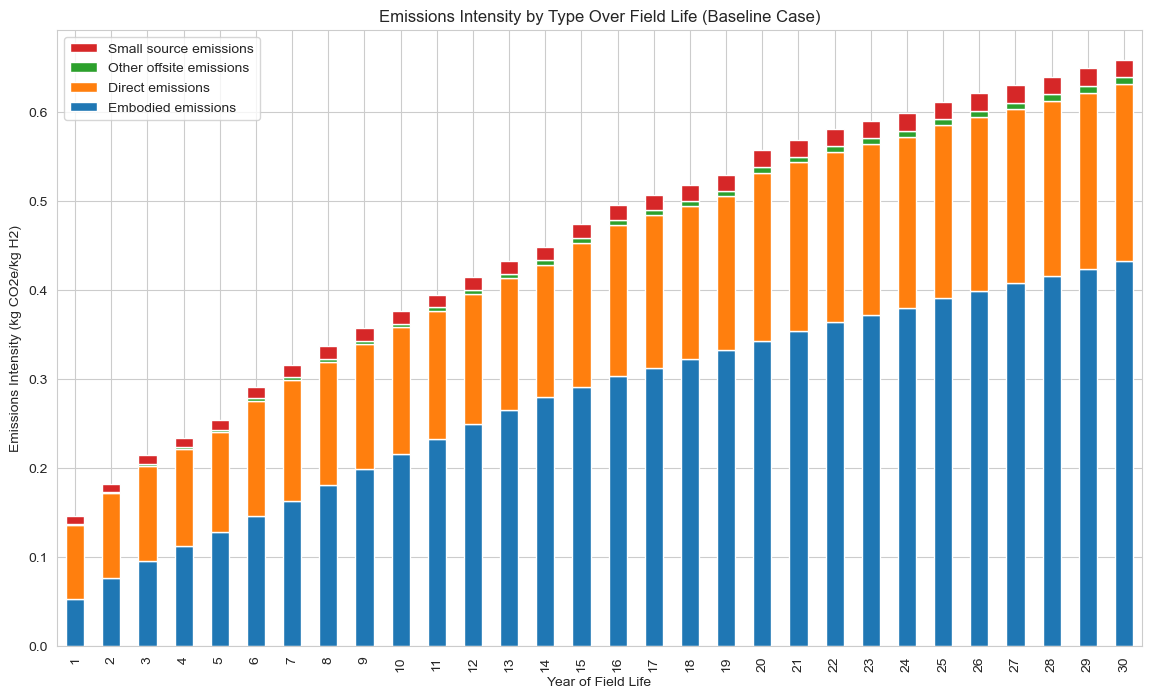

In [ ]:
#Now create a function to plot emissions intensity over time as a stacked bar chart of the different emission types:

def plot_emissions_intensity_by_case(case):
    if case not in emissions_df.index:
        print("Case not found in the DataFrame.")
        return
    
    # Fetch daily_field_H2_exported series for the given case
    daily_field_H2_exported = calculate_exploration_emissions(case)['daily_field_H2_exported']

    # Prepare the emissions data for the specific case, each type assumed to be a series over 30 years
    case_emissions = emissions_df.loc[case]

    # Normalize emissions by daily_field_H2_exported
    emissions_intensity_df = pd.DataFrame({
        'Embodied emissions': case_emissions['Embodied emissions'] / (daily_field_H2_exported * 1000),
        'Direct emissions': case_emissions['Direct emissions'] / (daily_field_H2_exported * 1000),
        'Other offsite emissions': case_emissions['Other offsite emissions'] / (daily_field_H2_exported * 1000),
        'Small source emissions': case_emissions['Small source emissions'] / (daily_field_H2_exported * 1000)
    })

    #Offset the index by 1 to represent years
    emissions_intensity_df.index += 1

    # Plot a vertical stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    emissions_intensity_df.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'Emissions Intensity by Type Over Field Life ({case} Case)')
    ax.set_xlabel('Year of Field Life')
    ax.set_ylabel('Emissions Intensity (kg CO2e/kg H2)')
    ax.legend(title='Emission Type', loc='upper right')
    # Reverse the legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
      
    plt.show()

# Example usage:
plot_emissions_intensity_by_case('Baseline')

# #Plots for all cases:
# for case in cases:
#     plot_emissions_intensity_by_case(case)


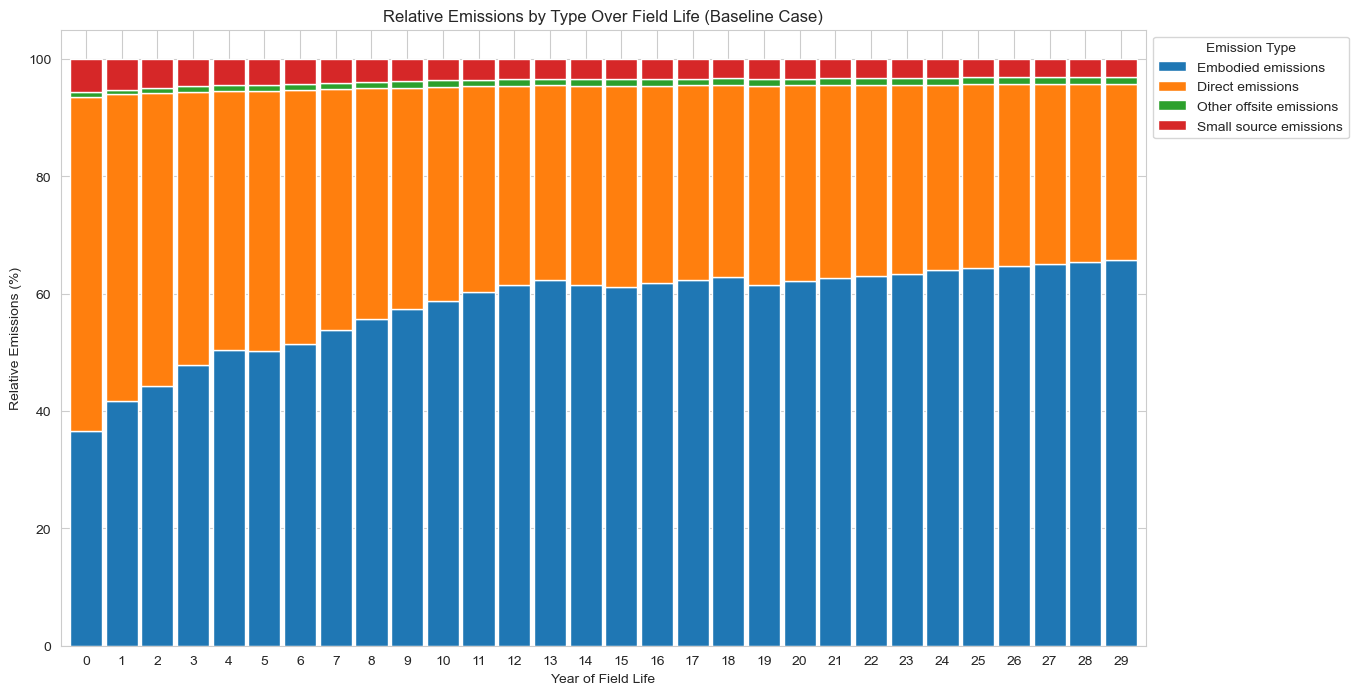

In [ ]:
# Now create a function to show the relative contribution of each emission type to the total annual for each year of the field's life:

def plot_relative_emissions_by_case(case):
    if case not in emissions_df.index:
        print("Case not found in the DataFrame.")
        return

    # Access the DataFrame row corresponding to the case
    case_data = emissions_df.loc[case]
    
    # Initialize a DataFrame to store the percentage values
    emissions_percentage_df = pd.DataFrame()

    # Calculate the total emissions for each year by summing over rows
    total_emissions_per_year = case_data.sum()

    # Calculate the relative contribution of each type of emission
    for col in case_data.index:
        emissions_percentage_df[col] = case_data[col] / total_emissions_per_year * 100

    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    emissions_percentage_df.plot(kind='bar', stacked=True, ax=ax, width=0.9)
    ax.set_title(f'Relative Emissions by Type Over Field Life ({case} Case)')
    ax.set_xlabel('Year of Field Life')
    ax.set_ylabel('Relative Emissions (%)')
    ax.legend(title='Emission Type', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=0)  # Ensure year labels are horizontal for readability

    plt.show()

# Example usage
plot_relative_emissions_by_case('Baseline')

# #Plots for all cases:
# for case in cases:
#     plot_relative_emissions_by_case(case)


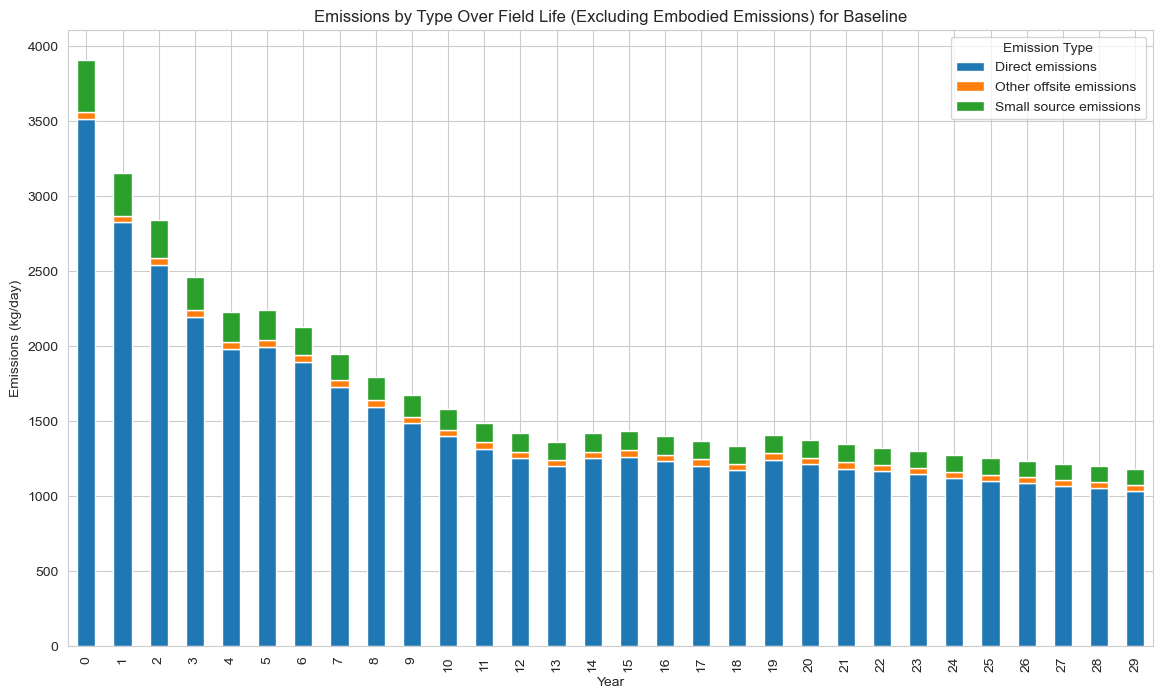

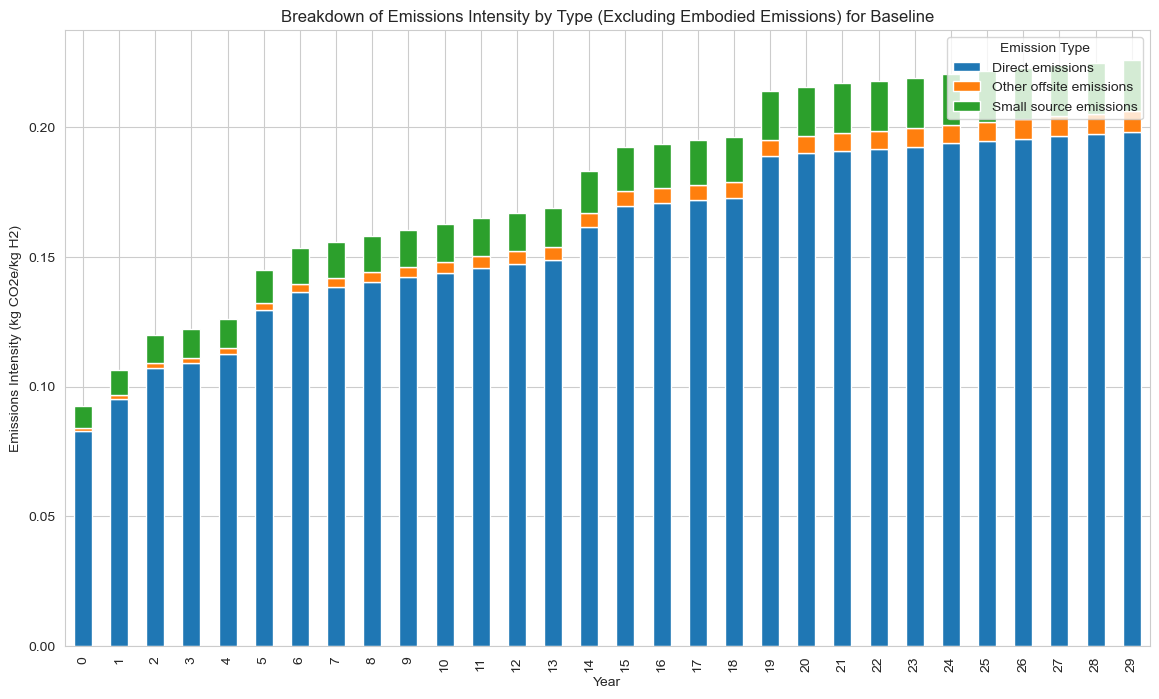

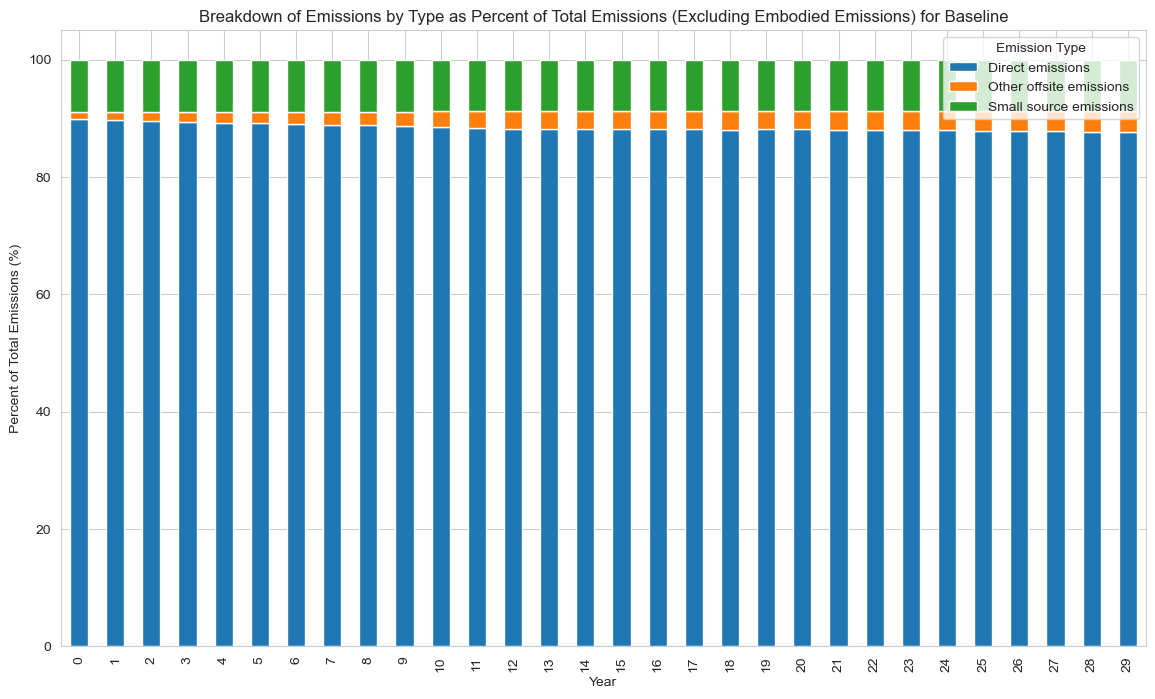

In [ ]:
### Now creating a function to inspect the results EXCLUDING embodied emissions for each case:

def plot_emissions_excluding_embodied(case):
    if case not in emissions_df.index:
        print("Case not found in the DataFrame.")
        return
    
    # Fetch daily_field_H2_exported series for the given case
    daily_field_H2_exported = calculate_exploration_emissions(case)['daily_field_H2_exported']

    # Ensure it's properly formatted
    if not isinstance(daily_field_H2_exported, pd.Series) or len(daily_field_H2_exported) != 30:
        print("Daily H2 exported data is not correctly formatted or has incorrect length.")
        return

    # Extract the case data for emissions, dropping 'Embodied emissions'
    case_data = emissions_df.loc[case].drop('Embodied emissions')

    # Ensure the data is aligned properly: case_data should have the same length as daily_field_H2_exported
    if any(len(data) != 30 for data in case_data):
        print("Emissions data does not match expected yearly format.")
        return
    
    # Check structure and reformat if necessary
    if isinstance(case_data, pd.Series):
        # Assuming each element in the Series is another Series of yearly data
        # Convert the series of series into a DataFrame
        formatted_data = pd.DataFrame({etype: data.values for etype, data in case_data.items()})

    # Transpose so that rows are years and columns are emission types
    # formatted_data = formatted_data.T

    # Plot
    ax = formatted_data.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.ylabel('Emissions (kg/day)')
    plt.xlabel('Year')
    plt.title(f'Emissions by Type Over Field Life (Excluding Embodied Emissions) for {case}')
    plt.legend(title='Emission Type')
    plt.show()

    # Normalize emissions by daily_field_H2_exported to get intensity
    emissions_intensity_df = case_data.apply(lambda x: x / (daily_field_H2_exported * 1000))

    # Plot the emissions intensity by type for each year
    ax = emissions_intensity_df.T.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.ylabel('Emissions Intensity (kg CO2e/kg H2)')
    plt.xlabel('Year')
    plt.title(f'Breakdown of Emissions Intensity by Type (Excluding Embodied Emissions) for {case}')
    plt.legend(title='Emission Type', loc='upper right')
    plt.show()

    # Calculate the relative contributions of each emission type to the total emissions per year
    total_emissions_no_embodied = case_data.sum()
    emissions_percent_df = case_data.apply(lambda x: (x / total_emissions_no_embodied) * 100)
    ax = emissions_percent_df.T.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.ylabel('Percent of Total Emissions (%)')
    plt.xlabel('Year')
    plt.title(f'Breakdown of Emissions by Type as Percent of Total Emissions (Excluding Embodied Emissions) for {case}')
    plt.legend(title='Emission Type', loc='upper right')
    plt.show()

# Example usage:
plot_emissions_excluding_embodied('Baseline')

#Plots for all cases:
# for case in cases:
#     plot_emissions_excluding_embodied(case)


In [ ]:
# #Print minimum, mean, median, and maximum production-weighted emissions, excluding embodied emissions
# production_weighted_emissions_no_embodied = total_emissions_no_embodied / (daily_field_H2_exported * 1000)

# print(f'Minimum (Year 1) production-weighted emissions (excluding embodied emissions): {min(production_weighted_emissions_no_embodied):.3g} kgCO2e/kgH2')
# print(f'Mean production-weighted emissions (excluding embodied emissions): {statistics.mean(production_weighted_emissions_no_embodied):.3g} kgCO2e/kgH2')
# print(f'Median production-weighted emissions (excluding embodied emissions): {statistics.median(production_weighted_emissions_no_embodied):.3g} kgCO2e/kgH2')
# print(f'Maximum (Year 30) production-weighted emissions (excluding embodied emissions): {max(production_weighted_emissions_no_embodied):.3g} kgCO2e/kgH2')

#Create a function to calculate summary statistics for each case:
def calculate_emissions_statistics_excluding_embodied(case):
    if case not in emissions_df.index:
        print("Case not found in the DataFrame.")
        return
    
    # Fetch daily_field_H2_exported series for the given case
    daily_field_H2_exported = calculate_exploration_emissions(case)['daily_field_H2_exported']

    # Ensure it's properly formatted
    if not isinstance(daily_field_H2_exported, pd.Series) or len(daily_field_H2_exported) != 30:
        print("Daily H2 exported data is not correctly formatted or has incorrect length.")
        return

    # Extract the case data for emissions, dropping 'Embodied emissions'
    case_data = emissions_df.loc[case].drop('Embodied emissions')

    # Ensure the data is aligned properly: case_data should have the same length as daily_field_H2_exported
    if any(len(data) != 30 for data in case_data):
        print("Emissions data does not match expected yearly format.")
        return
    
    # Check structure and reformat if necessary
    if isinstance(case_data, pd.Series):
        # Assuming each element in the Series is another Series of yearly data
        # Convert the series of series into a DataFrame
        formatted_data = pd.DataFrame({etype: data.values for etype, data in case_data.items()})

    # Transpose so that rows are years and columns are emission types
    # formatted_data = formatted_data.T

    # Calculate the total emissions for each year by summing over rows
    total_emissions_per_year = case_data.sum()

    # Normalize emissions by daily_field_H2_exported to get intensity
    emissions_intensity_df = case_data.apply(lambda x: x / (daily_field_H2_exported * 1000))

    # Calculate the relative contributions of each emission type to the total emissions per year
    total_emissions_no_embodied = case_data.sum()
    emissions_percent_df = case_data.apply(lambda x: (x / total_emissions_no_embodied) * 100)

    # Calculate the production-weighted emissions:
    production_weighted_emissions_no_embodied = total_emissions_no_embodied / (daily_field_H2_exported * 1000)

    # Calculate statistics
    min_production_weighted_emissions = min(production_weighted_emissions_no_embodied)  # Convert Series to list
    mean_production_weighted_emissions = statistics.mean(production_weighted_emissions_no_embodied)  # Convert Series to list
    median_production_weighted_emissions = statistics.median(production_weighted_emissions_no_embodied)  # Convert Series to list
    max_production_weighted_emissions = max(production_weighted_emissions_no_embodied)  # Convert Series to list
    
    return {
        'case': case,
        'Min (Year 1) Emissions kgCO2e/kgH2 (excluding embodied)': min_production_weighted_emissions,
        'Mean Emissions kgCO2e/kgH2 (excluding embodied)': mean_production_weighted_emissions,
        'Median Emissions kgCO2e/kgH2 (excluding embodied)': median_production_weighted_emissions,
        'Max (Year 30) Emissions kgCO2e/kgH2 (excluding embodied)': max_production_weighted_emissions
    }

# Example usage:
calculate_emissions_statistics_excluding_embodied('Baseline')

{'case': 'Baseline',
 'Min (Year 1) Emissions kgCO2e/kgH2 (excluding embodied)': 0.09239047977458262,
 'Mean Emissions kgCO2e/kgH2 (excluding embodied)': 0.17949821687218107,
 'Median Emissions kgCO2e/kgH2 (excluding embodied)': 0.18776295243804497,
 'Max (Year 30) Emissions kgCO2e/kgH2 (excluding embodied)': 0.22601481772596987}

In [ ]:
production_profile_df.head()

,Year,"Baseline Raw Gas Rate, MSCFD","Baseline Wellhead Pressure, PSI","Deep Pressure, PSI","Shallow Pressure, PSI","Low Pressure Wellhead Pressure, PSI","High Pressure Wellhead Pressure, PSI","Low Productivity Raw Gas Rate, MSCFD","High Productivity Raw Gas Rate, MSCFD","Baseline GOR, SCF/BBL",...,"Low H2 GOR, SCF/BBL","High CH4 GOR, SCF/BBL","Mixed GOR, SCF/BBL","Low H2 w/ CH4 GOR, SCF/BBL","Low H2 w/ N2 GOR, SCF/BBL","High H2 GOR, SCF/BBL","Deep GOR, SCF/BBL","Shallow GOR, SCF/BBL","Water Production, BBL/D",Baseline WOR
0,1,23100.00,2520.00000,5160.00000,645.000000,1890.000000,3150.000000,5775.0000,46200.0,231000000.0,...,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,231000000.0,23.10000,231.0000
1,2,16170.00,2394.00000,4902.00000,612.750000,1795.500000,2992.500000,4042.5000,32340.0,161700000.0,...,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,161700000.0,16.17000,161.7000
2,3,12936.00,2274.30000,4656.90000,582.112500,1705.725000,2842.875000,3234.0000,25872.0,129360000.0,...,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,129360000.0,12.93600,129.3600
3,4,10995.60,2160.58500,4424.05500,553.006875,1620.438750,2700.731250,2748.9000,21991.2,109956000.0,...,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,109956000.0,10.99560,109.9560
4,5,9621.15,2052.55575,4202.85225,525.356531,1539.416812,2565.694687,2405.2875,19242.3,96211500.0,...,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,96211500.0,9.62115,96.2115


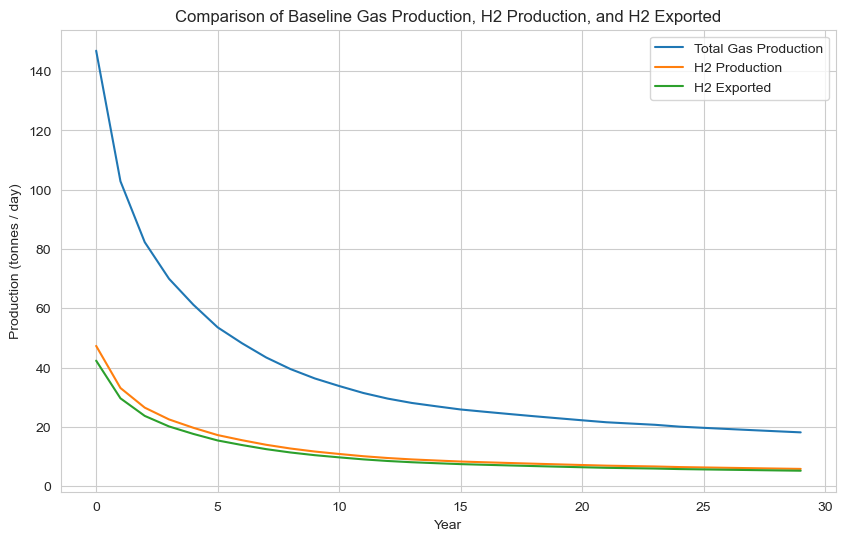

In [ ]:

def plot_gas_production(case):
    #Convert baseline gas production from MMSCF/day to tonnes/day
    MMSCF_to_tonnes = 0.178107606679035 #tonnes/MMSCF. Conversion factor from MMSCF to tonnes.

    total_gas_mass_flow_upstream_separator[case]= calculate_development_drilling_emissions(case)['total_gas_mass_flow_upstream_separator']
    H2_after_separator = calculate_total_production_vent_emissions(case)['H2_after_separator']
    daily_field_H2_exported = calculate_exploration_emissions(case)['daily_field_H2_exported']    

    #Give me a line plot of baseline gas production, H2 production, and H2 exported
    plt.figure(figsize=(10,6))
    plt.plot(total_gas_mass_flow_upstream_separator[case], label='Total Gas Production')
    plt.plot(H2_after_separator, label='H2 Production')
    plt.plot(daily_field_H2_exported, label='H2 Exported')
    plt.xlabel('Year')
    plt.ylabel('Production (tonnes / day)')
    plt.title('Comparison of Baseline Gas Production, H2 Production, and H2 Exported')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_gas_production('Baseline')

# # #Plots for all cases:
# for case in cases:
#     plot_gas_production(case)



In [ ]:
total_steel_emissions = (calculate_well_steel_mass_MC('Baseline')['total_steel_mass_all_wells'] * steel_emissions_intensity)/1000 #kgCO2e. This is the total emissions associated with steel use in well construction.

total_steel_emissions

19424364.283473592

In [ ]:
# Create a function to calculate the total amount of emissions in the steel and cement needed to make the wells, and express this as a percentage of all embodied emissions for each case:
# Need to update embodied emissions calculations to consider case differences before this function is necessary.

def calculate_steel_and_cement_emissions(case):
    #Calculate the total mass of steel needed for all wells:
    # total_steel_mass_all_wells = calculate_development_drilling_emissions(case)['total_steel_mass_all_wells'] #kg. This is the total mass of steel needed for all wells in the field.

    #Calculate the total amount of emissions in the steel needed to make the wells:
    total_steel_emissions = (calculate_well_steel_mass_MC(case)['total_steel_mass_all_wells'] * steel_emissions_intensity)/1000 #kgCO2. This is the total emissions associated with the steel used in the wells.

    #Calculate the total amount of emissions in the cement needed to make the wells:
    total_cement_emissions_kg = calculate_total_cement_emissions(case)['total_cement_emissions']/1000 #kgCO2. This is the total emissions associated with the cement used in the wells.

    #Calculate this as a percentage of all embodied emissions:
    total_steel_and_cement_emissions_percent = (total_steel_emissions + total_cement_emissions_kg) / calculate_total_embodied_emissions(case)['total_embodied_emissions'] * 100

    return {
        'case': case,
        'total_steel_and_cement_emissions': total_steel_emissions + total_cement_emissions_kg,
        'total_steel_and_cement_emissions_percent': total_steel_and_cement_emissions_percent
    }


check_case = 'Baseline'
steel_and_cement_emissions = calculate_steel_and_cement_emissions(check_case)

# Total embodied emissions in tonnes CO2
total_emissions_tonnes = steel_and_cement_emissions['total_steel_and_cement_emissions'] / 1000
# Percentage of total embodied emissions
total_emissions_percent = steel_and_cement_emissions['total_steel_and_cement_emissions_percent']

print(f"Total embodied emissions associated with steel and cement in wells in {check_case}: {total_emissions_tonnes:.2f} tonnes CO2")
print(f"Total embodied emissions associated with steel and cement in wells as a percentage of total embodied emissions in {check_case}: {total_emissions_percent:.2f}%")

# print(f"'Total embodied emissions associated with steel and cement in wells in", check_case,': '{calculate_steel_and_cement_emissions(check_case)['total_steel_and_cement_emissions']/1000} tonnes CO2")
# print(f"'Total embodied emissions associated with steel and cement in wells as a percentage of total embodied emissions in", check_case,': {calculate_steel_and_cement_emissions('Baseline')['total_steel_and_cement_emissions_percent']:.2f}%")



Total embodied emissions associated with steel and cement in wells in Baseline: 22029.23 tonnes CO2
Total embodied emissions associated with steel and cement in wells as a percentage of total embodied emissions in Baseline: 88.99%


In [ ]:
# Define a function that calculates the percentage of VFF emissions relative to total emissions for a given case:


def calculate_VFF_emissions_percentage(case):
    # Calculate the total emissions for the given case
    total_emissions = np.array(calculate_total_emissions(case)['Total Emissions kgCO2e/day'])

    # Calculate the VFF emissions for the given case
    VFF_emissions = np.array(calculate_total_operational_VFF_emissions(case)['total_operational_VFF_emissions'])

    # Handle cases where total emissions might be zero to avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        VFF_emissions_percentage = np.where(total_emissions != 0, (VFF_emissions / total_emissions) * 100, 0)

    return VFF_emissions_percentage, VFF_emissions

# Example usage
VFF_emissions_percentage, VFF_emissions = calculate_VFF_emissions_percentage('Baseline')

# Print the result
print(f"VFF emissions as a percentage of total emissions in the 'Baseline' case: {VFF_emissions_percentage}")


VFF emissions as a percentage of total emissions in the 'Baseline' case: [54.6249456  49.55275356 47.04391995 43.50303827 41.03330206 41.17979136
 39.9487278  37.73132831 35.78842851 34.1096824  32.6820479  31.28832662
 30.12855867 29.18803718 30.14393415 30.34620207 29.78274458 29.22607327
 28.6763198  29.9830326  29.42390824 28.87165661 28.50921696 28.1498905
 27.61409767 27.28361867 26.93526345 26.59015166 26.24830768 25.90975408]


# 9. Cost Estimation

## 9.1 Cost Assumptions

In [ ]:
# Establish key assumptions regarding development and operating costs for the hydrogen production facility. For the time being, do this both on a 'cost of materials' basis (i.e. cost allowance
# per mass of material used) and on a 'historical average cost' basis (i.e. CAPEX & OPEX per ft of well depth).git

# Define the cost of materials for the hydrogen production facility
cost_of_steel_per_lb = 1.5 # USD/lb. DUMMY VALUE ONLY!!! This is the cost of steel per kg.
cost_of_cement_per_volume = 0.1 # USD/ft^3. This is the cost of cement per kg. 

# Define the historical average costs for the hydrogen production facility
cost_per_ft_drilling = 1000 # USD/ft. This is the cost per foot of drilling.
cost_per_ft_completion = 50 # USD/ft. This is the cost per foot of completion.
cost_per_ft_production = 25 # USD/ft. This is the cost per foot of production.



## 9.2 Cost Estimate Calculations

In [ ]:
# Estimate the total cost on a 'cost of materials' basis by case and sensitivity values:
def calculate_cost_materials_basis(case,sensitivity_variables=None):
    # if sensitivity_variables:
    #     cost_of_steel_per_lb = sensitivity_variables.get('cost_of_steel_per_lb', cost_of_steel_per_lb)
    #     cost_of_cement_per_volume = sensitivity_variables.get('cost_of_cement_per_volume', cost_of_cement_per_volume)
    # else:
    #     cost_of_steel_per_lb = cost_of_steel_per_lb
    #     cost_of_cement_per_volume = cost_of_cement_per_volume

    total_steel_cost_materials_basis = calculate_total_steel_mass(case, sensitivity_variables)['total_steel_mass'] * cost_of_steel_per_lb
    total_cement_cost_materials_basis = calculate_cement_volume_mass(case,sensitivity_variables)['total_well_cement_volume'] * cost_of_cement_per_volume

    total_cost_materials_basis = total_steel_cost_materials_basis + total_cement_cost_materials_basis

    return {
        'case': case,
        'total_steel_cost_materials_basis': total_steel_cost_materials_basis,
        'total_cement_cost_materials_basis': total_cement_cost_materials_basis,
        'total_cost_materials_basis': total_cost_materials_basis
    }

# Estimate the total cost on a 'historical average cost' basis by case and sensitivity values:

def calculate_cost_historical_basis(case,sensitivity_variables=None):
    # if sensitivity_variables:
    #     cost_per_ft_drilling = sensitivity_variables.get('cost_per_ft_drilling', cost_per_ft_drilling)
    #     cost_per_ft_completion = sensitivity_variables.get('cost_per_ft_completion', cost_per_ft_completion)
    #     cost_per_ft_production = sensitivity_variables.get('cost_per_ft_production', cost_per_ft_production)
    # else:
    #     cost_per_ft_drilling = cost_per_ft_drilling
    #     cost_per_ft_completion = cost_per_ft_completion
    #     cost_per_ft_production = cost_per_ft_production

    total_drilling_cost_historical_basis = depths[case]* cost_per_ft_drilling
    total_surface_equipment_cost_historical_basis = 0 #Need to determine a valid method for estimating this cost.

    total_cost_historical_basis = total_drilling_cost_historical_basis + total_surface_equipment_cost_historical_basis

    return {
        'case': case,
        'total_drilling_cost_historical_basis': total_drilling_cost_historical_basis,
        'total_surface_equipment_cost_historical_basis': total_surface_equipment_cost_historical_basis,
        'total_cost_historical_basis': total_cost_historical_basis
    }

In [ ]:
# Example usage:
cost_materials_basis = calculate_cost_materials_basis('Baseline')['total_cost_materials_basis']
cost_historical_basis = calculate_cost_historical_basis('Baseline')['total_cost_historical_basis']

print('Estimated total cost on a "cost of materials" basis for the Baseline case: $' , cost_materials_basis)
print('Estimated total cost on a "historical average cost" basis for the Baseline case: $' , cost_historical_basis)


Estimated total cost on a "cost of materials" basis for the Baseline case: $ 24950433.21513451
Estimated total cost on a "historical average cost" basis for the Baseline case: $ 6000000


# 10. Production Tax Credit (PTC) Estimates